# Higgs Analysis:

>This notebook contains work performed on coffea-casa cloud server. 
> Work in progress

In [1]:
from datetime import datetime
import pytz

ist = pytz.timezone('Asia/Kolkata')
print(f"Last modified: {datetime.now(ist).strftime('%d %B %Y, %H:%M')} IST")

Last modified: 14 February 2026, 03:45 IST


# Imports 

In [2]:
import time
import gc
import pandas as pd
from IPython.display import display
from tqdm.auto import tqdm  

# import psutil
from dask.distributed import Client, LocalCluster, progress, as_completed

%matplotlib inline

from hww_tools import *

print(" \n All imports loaded")

hww_tools loaded successfully.
- Config
- Efficiency_data
- Physics_selection
- Plots_config
- calculations
- cross_section
- cutflow_utils
- cuts
- helper
- json_validation
- dask_utils
- plotting
- processor
 
 All imports loaded


# Setting up dask client

In [3]:
client = get_client("tls://localhost:8786")
display(client)

<Client: 'tls://192.168.235.124:8786' processes=0 threads=0, memory=0 B>

## Preparing Dask workers with all the modules

In [4]:
prepare_workers(client)

Zipping hww_tools from /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Run_analysis...
Uploading hww_tools.zip to cluster...
Upload complete. Workers can now import hww_tools.
Verifying import on workers...


# Loading Files

In [5]:
# files = load_all_files(DATA_DIR, MC_DIR, max_per_sample=1)  # TESTING
files = load_all_files(DATA_DIR, MC_DIR)  # FULL 

samples_to_process(files)


FILES TO PROCESS
Data                :   48 files
VG                  :   32 files
ggH_HWW             :   40 files
WW                  :    7 files
Fakes               :  206 files
Diboson             :   73 files
DY_to_Tau_Tau       :   61 files
ggWW                :  112 files
Top_antitop         :  197 files
______________________________________________________________________
TOTAL               :  776 files


# Run Analysis

In [ ]:
print("\n" + "="*70)
print("PROCESSING START!! ")
print(f"Output Directory: {Config.OUTPUT_DIR}")
print("="*70)

project_path = os.getcwd()

# Load Configuration
stage_names = Config.stage_names
cutflow_stages = Config.cutflow_stages
VARIATIONS = Config.VARIATIONS
variables_to_plots = Plots_config.variables_to_plots

# Load Golden JSON
golden_json_data = None
if Config.GOLDEN_JSON_PATH.exists():
    with open(Config.GOLDEN_JSON_PATH, 'r') as f:
        golden_json_data = json.load(f)
    # print(f"Loaded Golden JSON: {len(golden_json_data)} runs")

# 2. PREPARE PROCESSOR
processing_task = processor.make_processor(
    golden_json_data=golden_json_data,
    sample_info_detailed=cross_section.sample_info_detailed, 
    luminosity=cross_section.LUMINOSITY,                        
    run_periods=Config.RUN_PERIODS_2016,
    project_dir=project_path 
)

# 3. PREPARE ACCUMULATORS
print("Initializing storage...")
hist_data_final = {}
cutflow_final = {}
weighted_cutflow_final = {}

for label in files.keys():
    # Use helper to initialize structure
    hist_data_final[label] = helper.initialize_stage_histograms(stage_names, variables_to_plots, VARIATIONS)
    cutflow_final[label] = {stage: 0 for stage in cutflow_stages}
    weighted_cutflow_final[label] = {stage: 0.0 for stage in cutflow_stages}

# 4. SUBMIT TO CLUSTER
arg_labels = []
arg_urls = []
arg_indices = []

for label, urls in files.items():
    for file_idx, file_url in enumerate(urls):
        arg_labels.append(label)
        arg_urls.append(file_url)
        arg_indices.append(file_idx)

print(f"\nSubmitting {len(arg_urls)} files to the cluster...")
start_time = time.perf_counter()

futures = client.map(
    processing_task, 
    arg_labels, arg_urls, arg_indices,
    retries=1  
)

# 5. STREAMING MERGE LOOP
print("Processing and merging results as they arrive...")
error_count = 0

# Progress bar
for future in tqdm(as_completed(futures), total=len(futures), unit="file"):
    try:
        result = future.result()
        if not result: continue
        
        label, stage_histograms, cutflow, weighted_cutflow, error = result
        
        if error:
            error_count += 1
            print(f" ERROR: {error}")
            continue

        # A. Merge Cutflows
        if cutflow:
            for stage, count in cutflow.items():
                cutflow_final[label][stage] += count
        
        if weighted_cutflow:
            for stage, count in weighted_cutflow.items():
                weighted_cutflow_final[label][stage] += count
        
        # B. Merge Histograms
        if stage_histograms:
            for stage, vars_dict in stage_histograms.items():
                for var, syst_dict in vars_dict.items():
                    for syst, hist_obj in syst_dict.items():
                        # In-place addition
                        hist_data_final[label][stage][var][syst] += hist_obj
        
        # clear memory
        del result, stage_histograms, cutflow, weighted_cutflow

    except Exception as e:
        print(f"CRITICAL CLIENT ERROR: {e}")
        error_count += 1

elapsed = time.perf_counter() - start_time

# 6. SAVE RESULTS 
helper.save_root_file(hist_data_final, Config.OUTPUT_DIR / "HWW_analysis_output.root")

cutflow_utils.save_cutflows(cutflow_final, weighted_cutflow_final, Config.OUTPUT_DIR)

# 7. FINAL REPORT
print("\n" + "="*70)
print(f"{'SAMPLE':20s} | {'EVENTS':>12s}")
print("-" * 35)
total_events = 0
for label in sorted(files.keys()):
    events = cutflow_final[label].get('total', 0)
    total_events += events
    print(f"{label:20s} | {events:>12,}")
print("-" * 35)
print(f"{'TOTAL':20s} | {total_events:>12,}")
print("="*70)

if error_count > 0:
    print(f"\n WARNING: {error_count} files failed processing.")

print(f"\nTotal Time: {elapsed:.1f}s ({elapsed/60:.1f} min)")
if len(futures) > 0:
    print(f"Rate: {total_events/elapsed:,.0f} events/sec")

# Cleanup
del futures, arg_urls, arg_labels, arg_indices
gc.collect()


PROCESSING START!! 
Output Directory: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs
Initializing storage...

Submitting 776 files to the cluster...
Processing and merging results as they arrive...


  0%|          | 0/776 [00:00<?, ?file/s]

# Outputs

## Cutflow

In [44]:
rows_to_highlight = [df.index[0], df.index[-1]]
styled_df = df.style.format("{:,.2f}") \
    .background_gradient(cmap="Blues", axis=0) \
    .set_properties(
        subset=pd.IndexSlice[rows_to_highlight, :], 
        **{'font-weight': 'bold'}
    )

display(styled_df)

## Plots

> Restoring the histogram data from the `HWW_analysis_output.root`

In [45]:
hist_data_final = helper.restore_histograms(
    sample_list=sorted(files.keys()),       
    stage_names=Config.stage_names,
    vars_dict=Plots_config.variables_to_plots,
    variations=Config.VARIATIONS,
    root_file_path=Config.OUTPUT_DIR / "HWW_analysis_output.root"
)

Restoring histograms from: HWW_analysis_output.root
Successfully restored data for 9 samples.


### Superimposed plots

Saving superimposed plots to: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Kinematics
Processing mass...
Saved plot: mass_stages.png


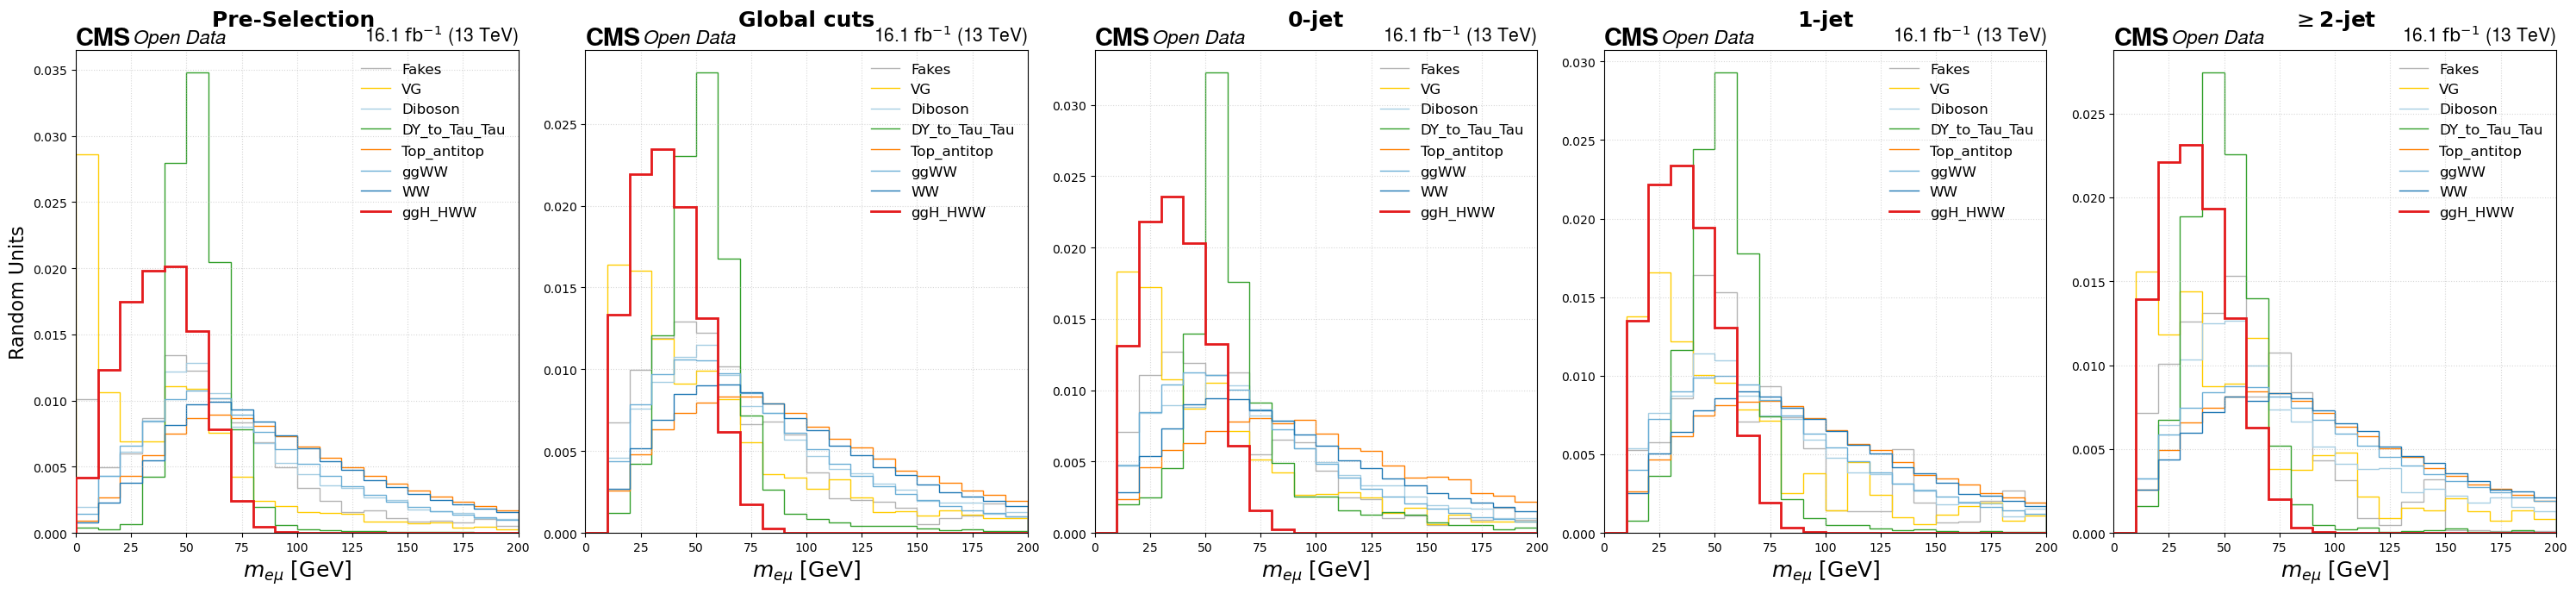

Processing met...
Saved plot: met_stages.png


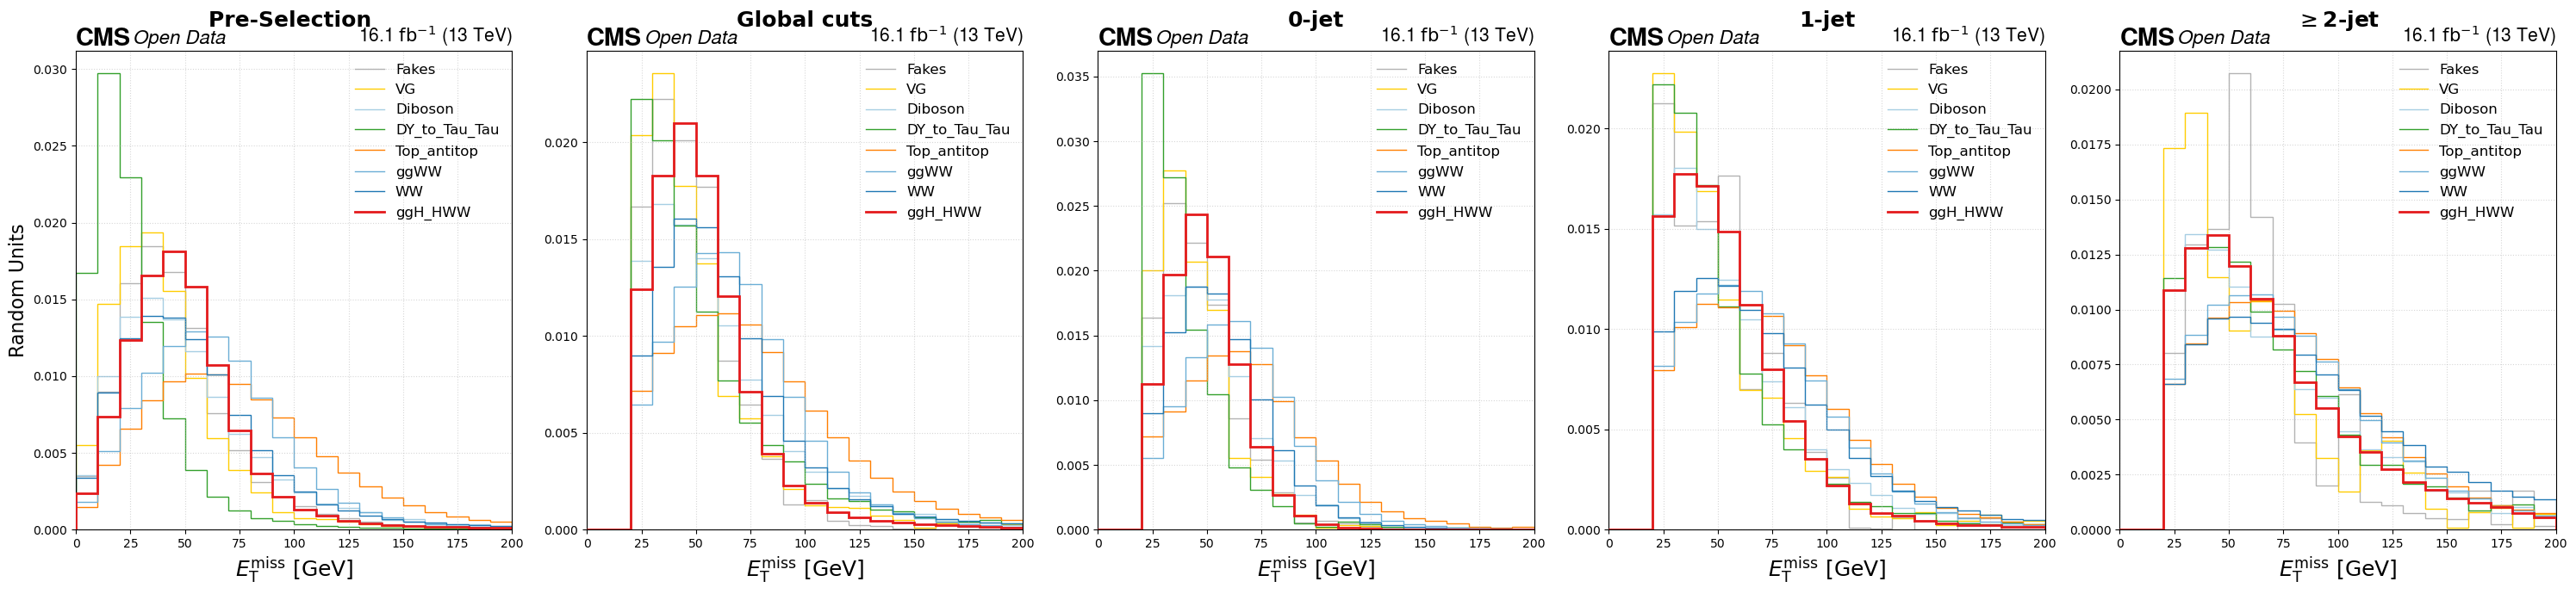

Processing dphi...
Saved plot: dphi_stages.png


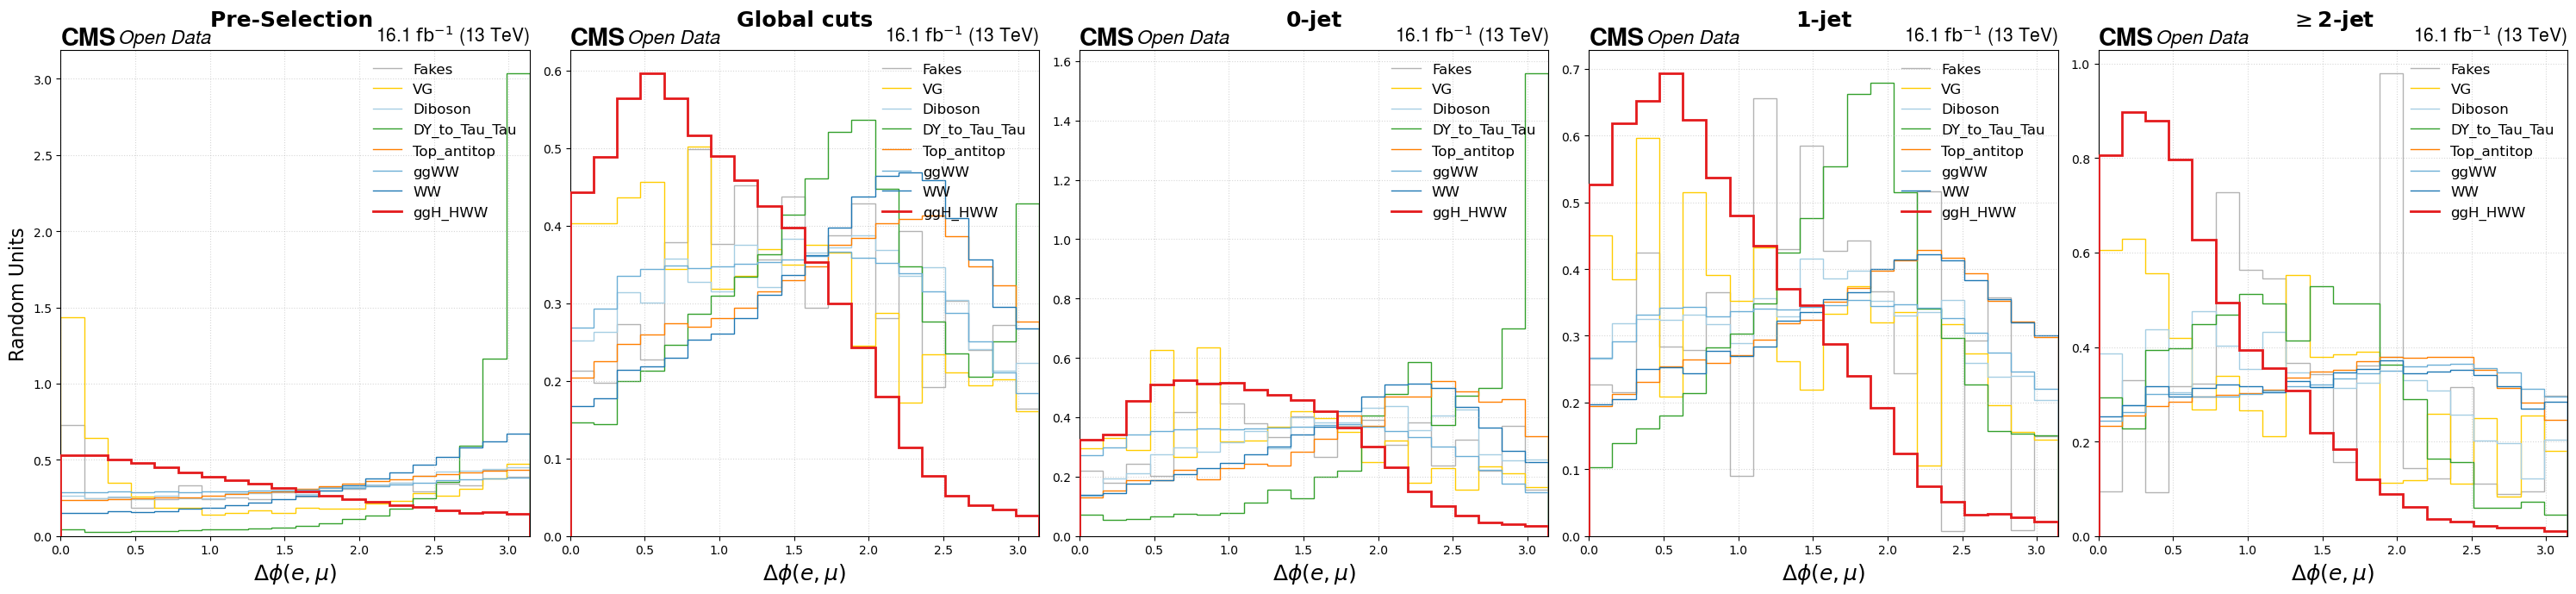

Processing ptll...
Saved plot: ptll_stages.png


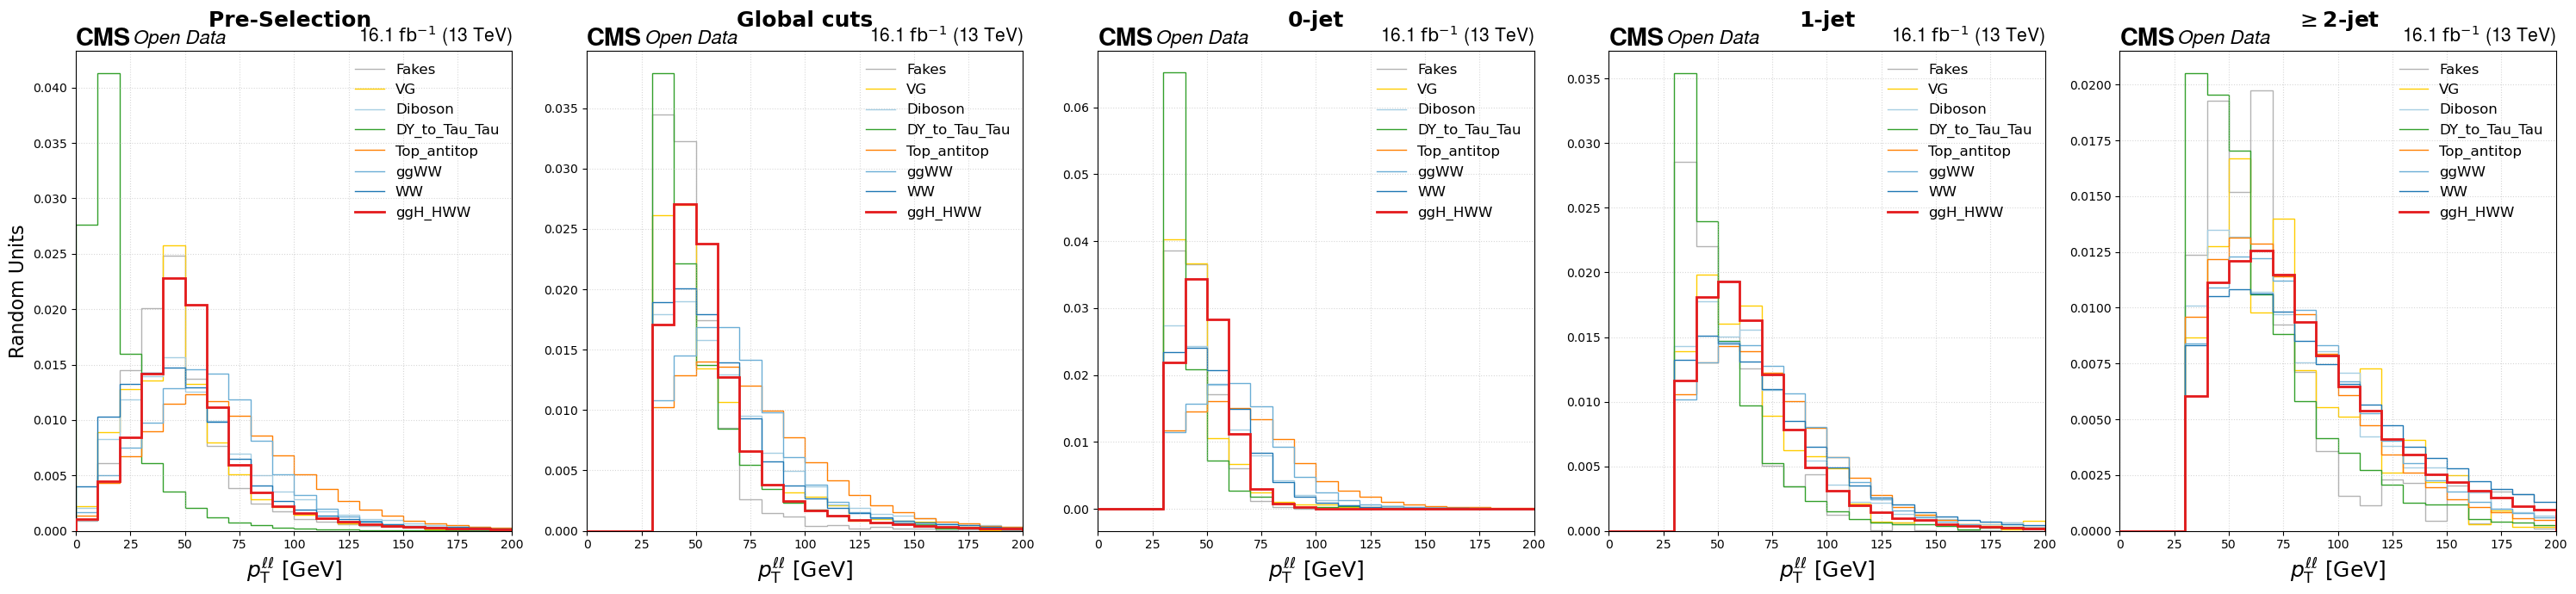

Processing mt_higgs...
Saved plot: mt_higgs_stages.png


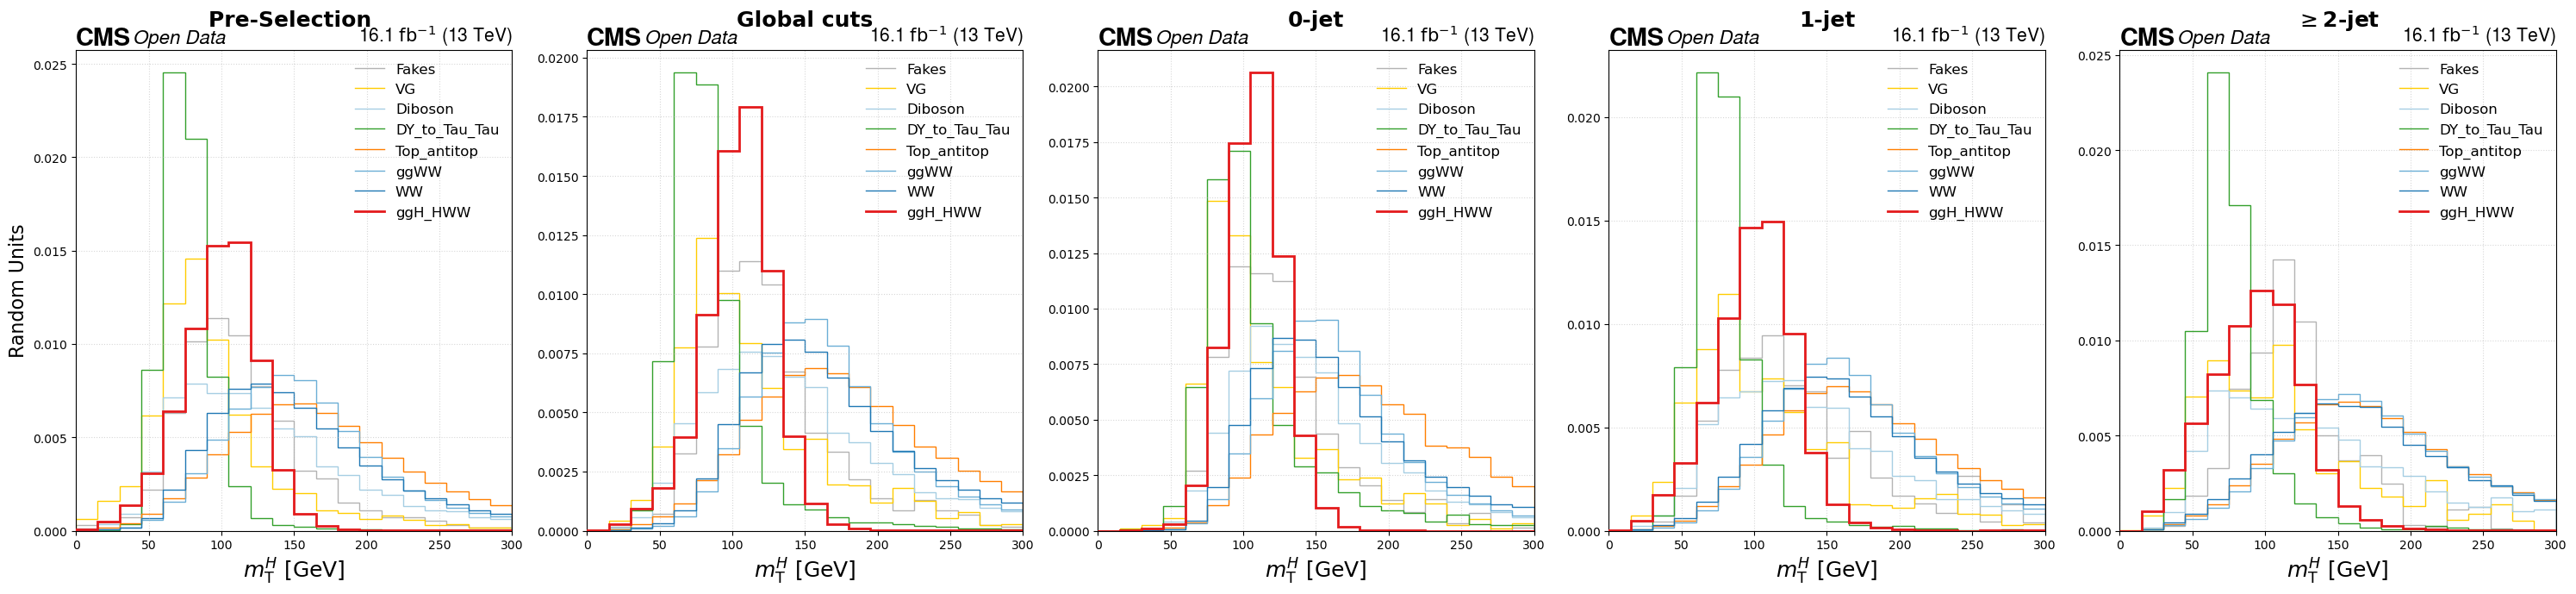

Processing mt_l2_met...
Saved plot: mt_l2_met_stages.png


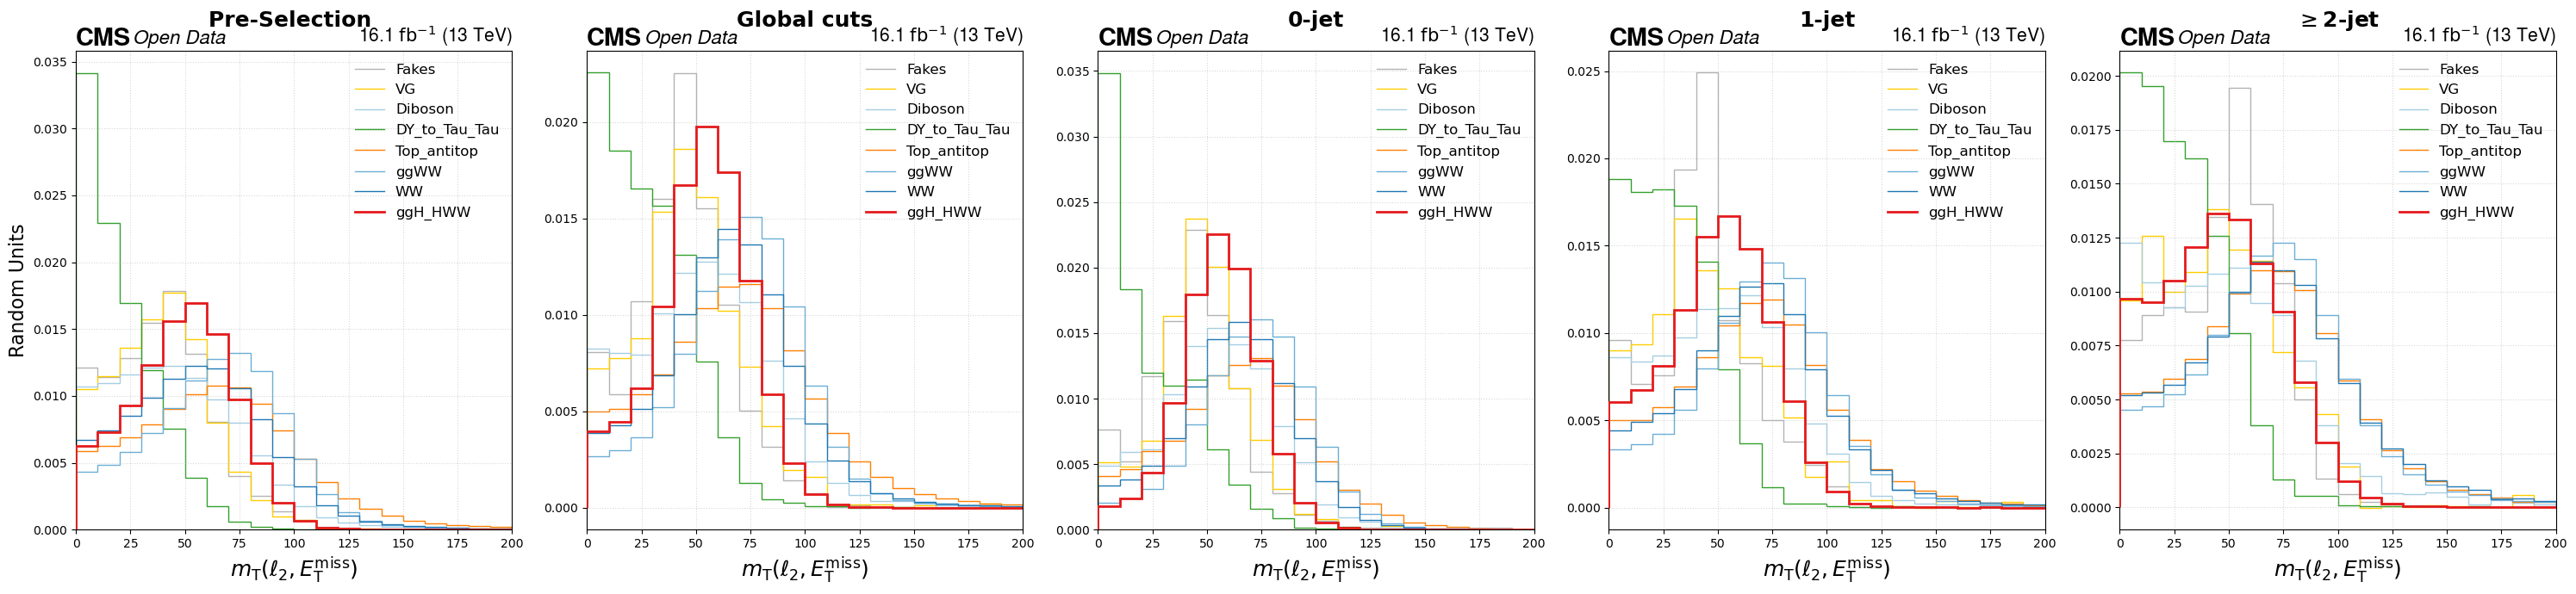

Processing mjj...
Saved plot: mjj_stages.png


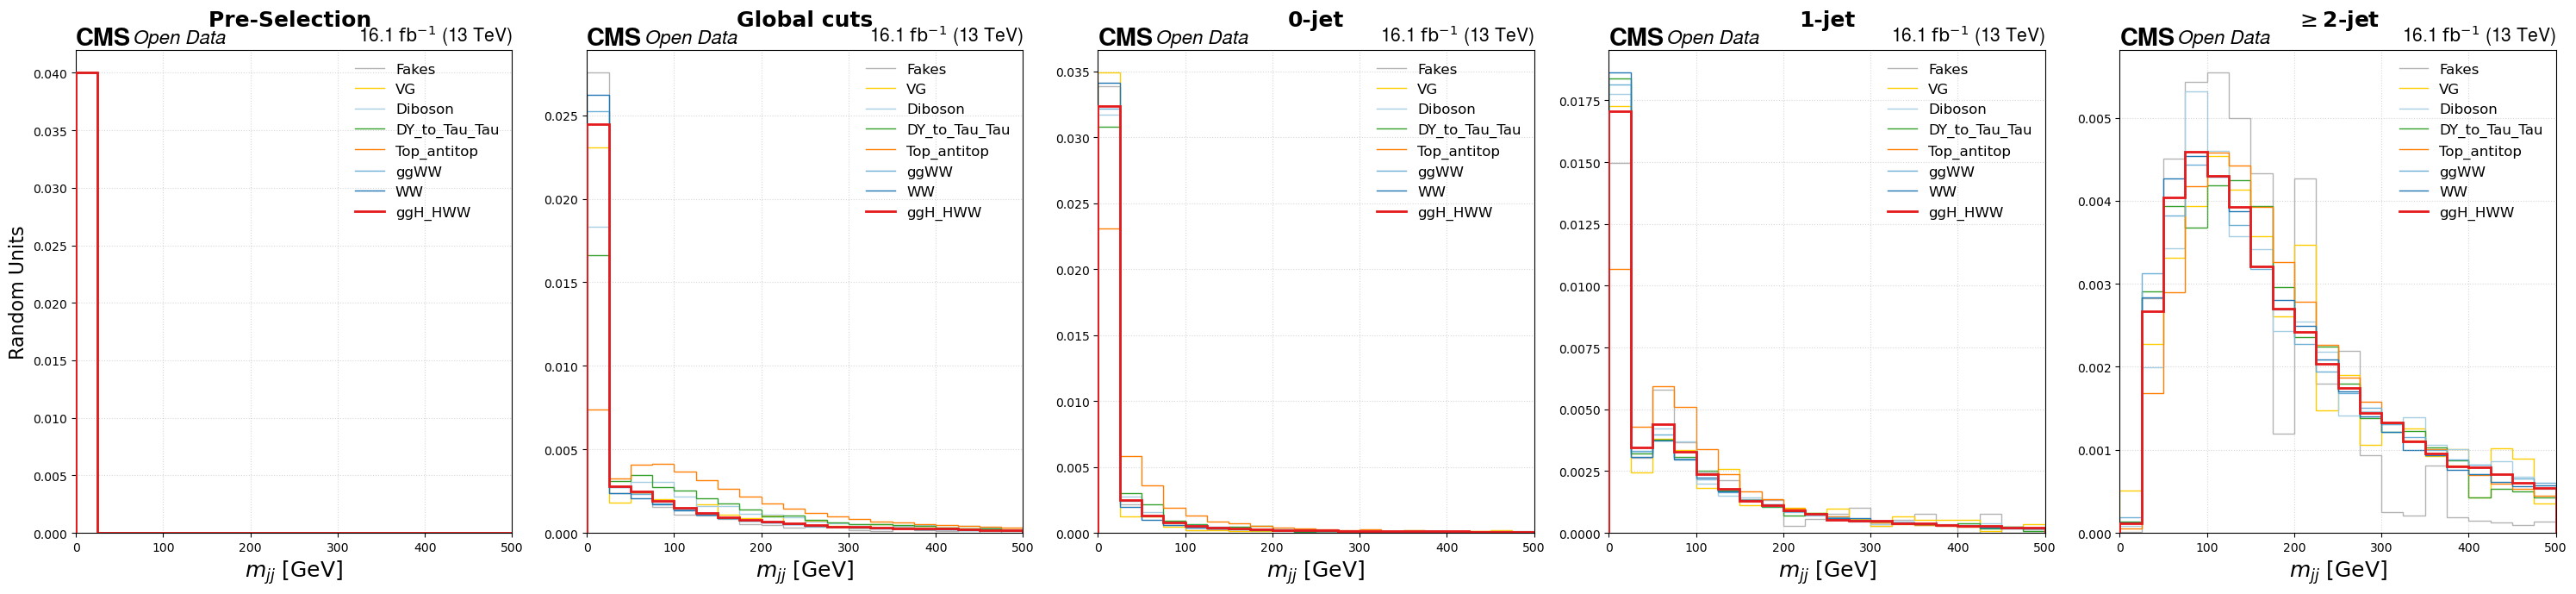

Processing leading_pt...
Saved plot: leading_pt_stages.png


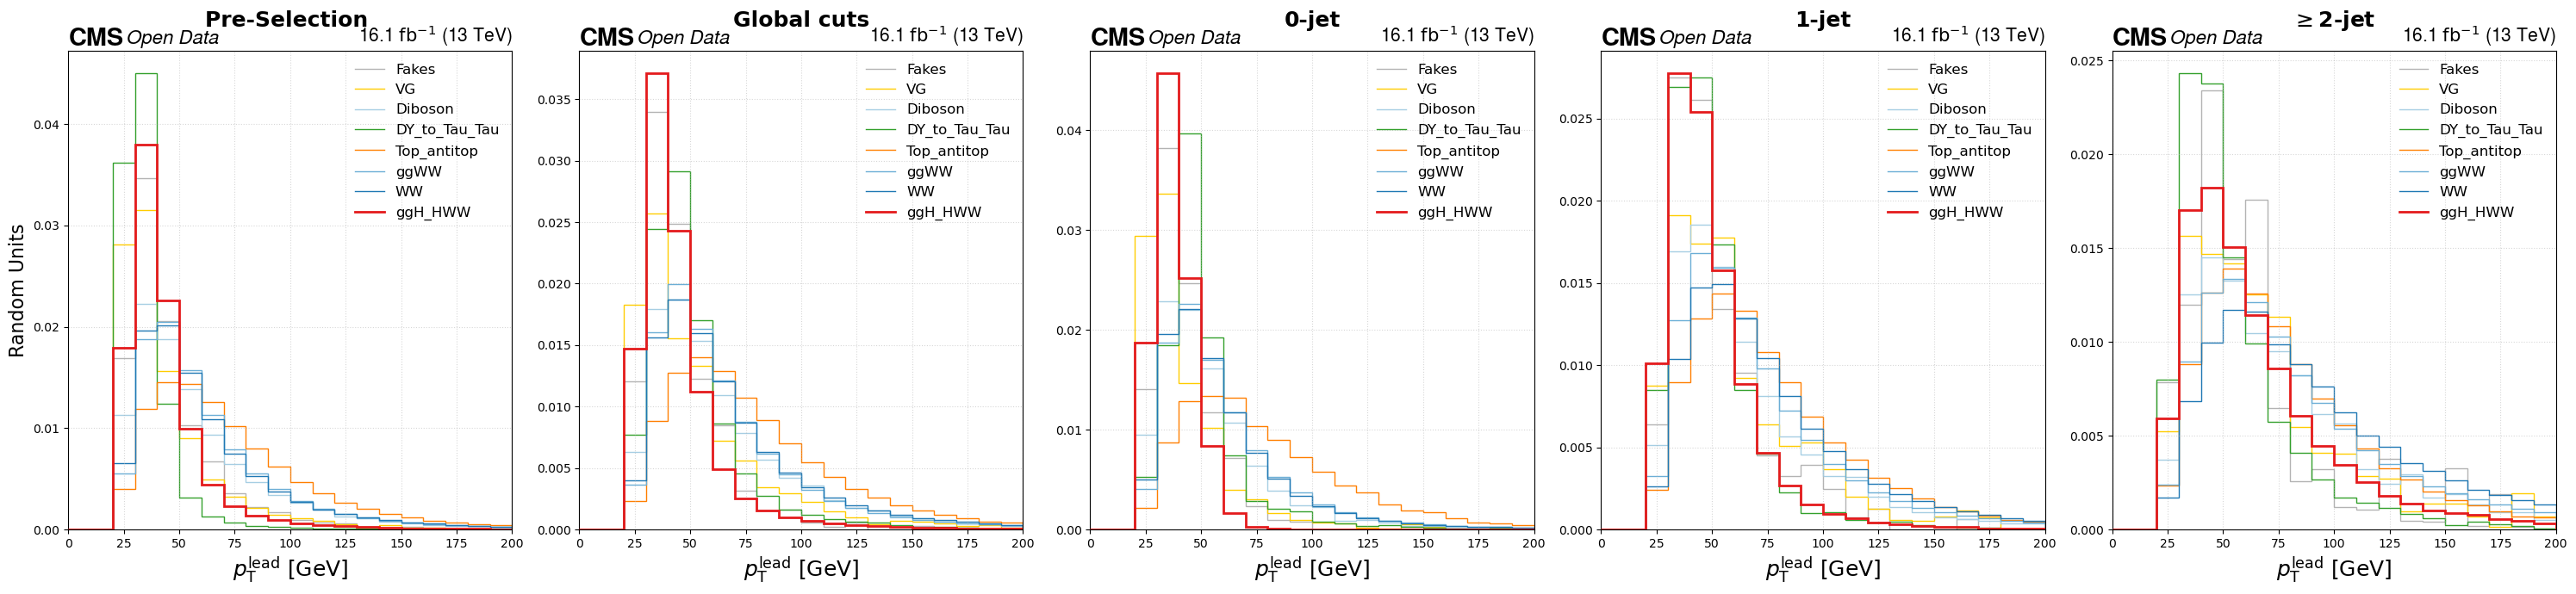

Processing subleading_pt...
Saved plot: subleading_pt_stages.png


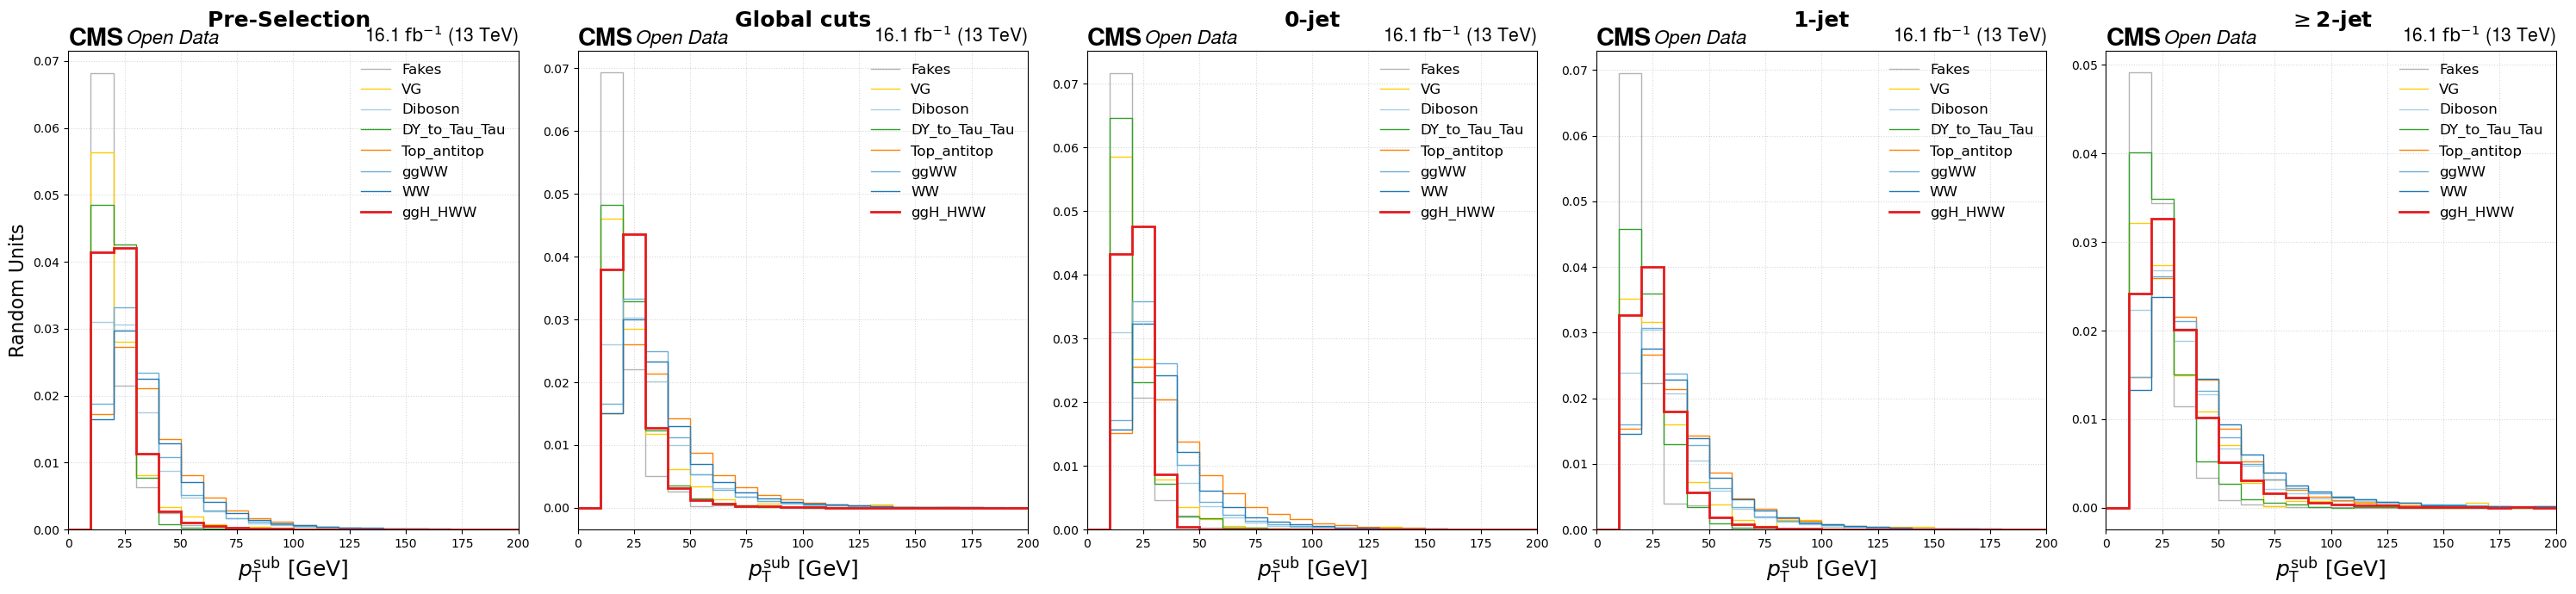

In [46]:
kinematics_dir = PLOTS_DIR / "Kinematics"
kinematics_dir.mkdir(parents=True, exist_ok=True)
print(f"Saving superimposed plots to: {kinematics_dir}")

for var_name, var_props in variables_to_plots.items():
    print(f"Processing {var_name}...")
    fig = create_superimposed_plots(var_name, var_props, hist_data_final, output_dir=PLOTS_DIR / "Kinematics")
    
    plt.show()
    plt.close(fig)

### Stacked plots


GENERATING STACKED PLOTS...
Plotting mass in Signal_Region...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Signal_Region_mass.png


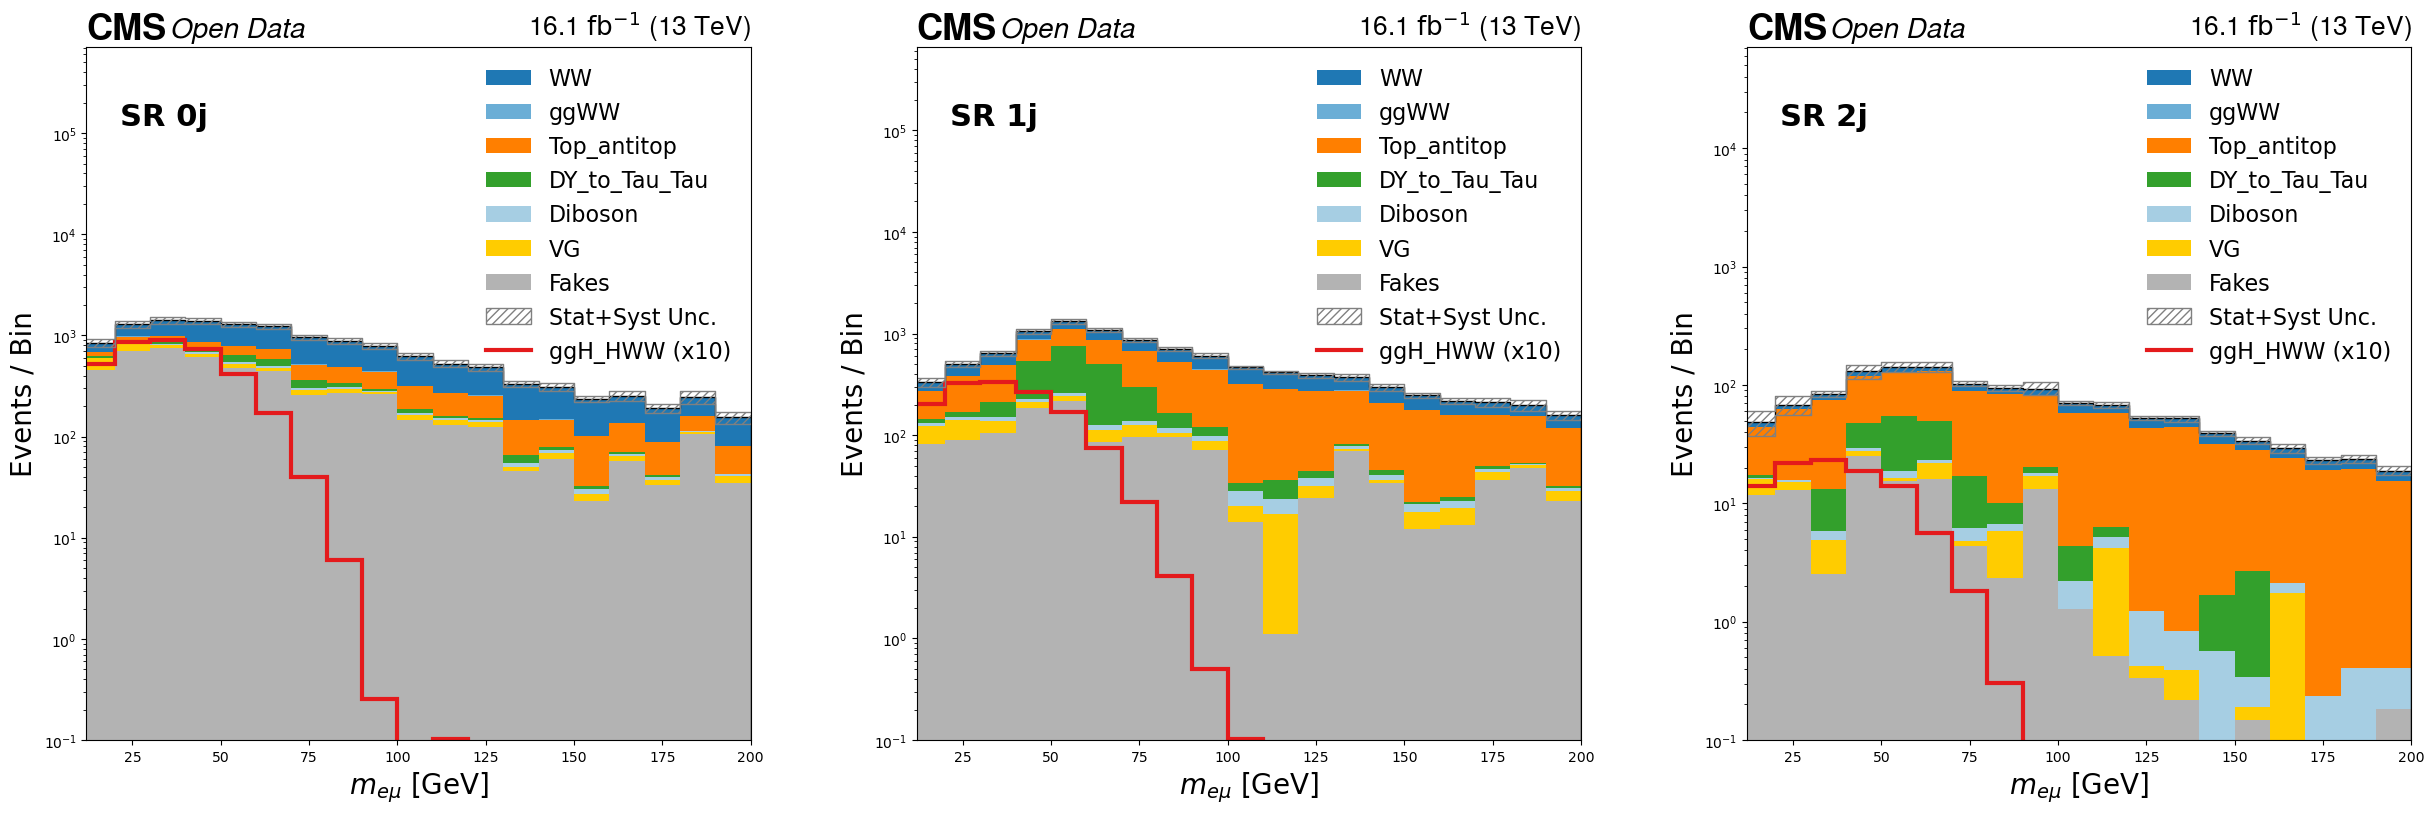

Plotting mass in Control_Region_Top...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Control_Region_Top_mass.png


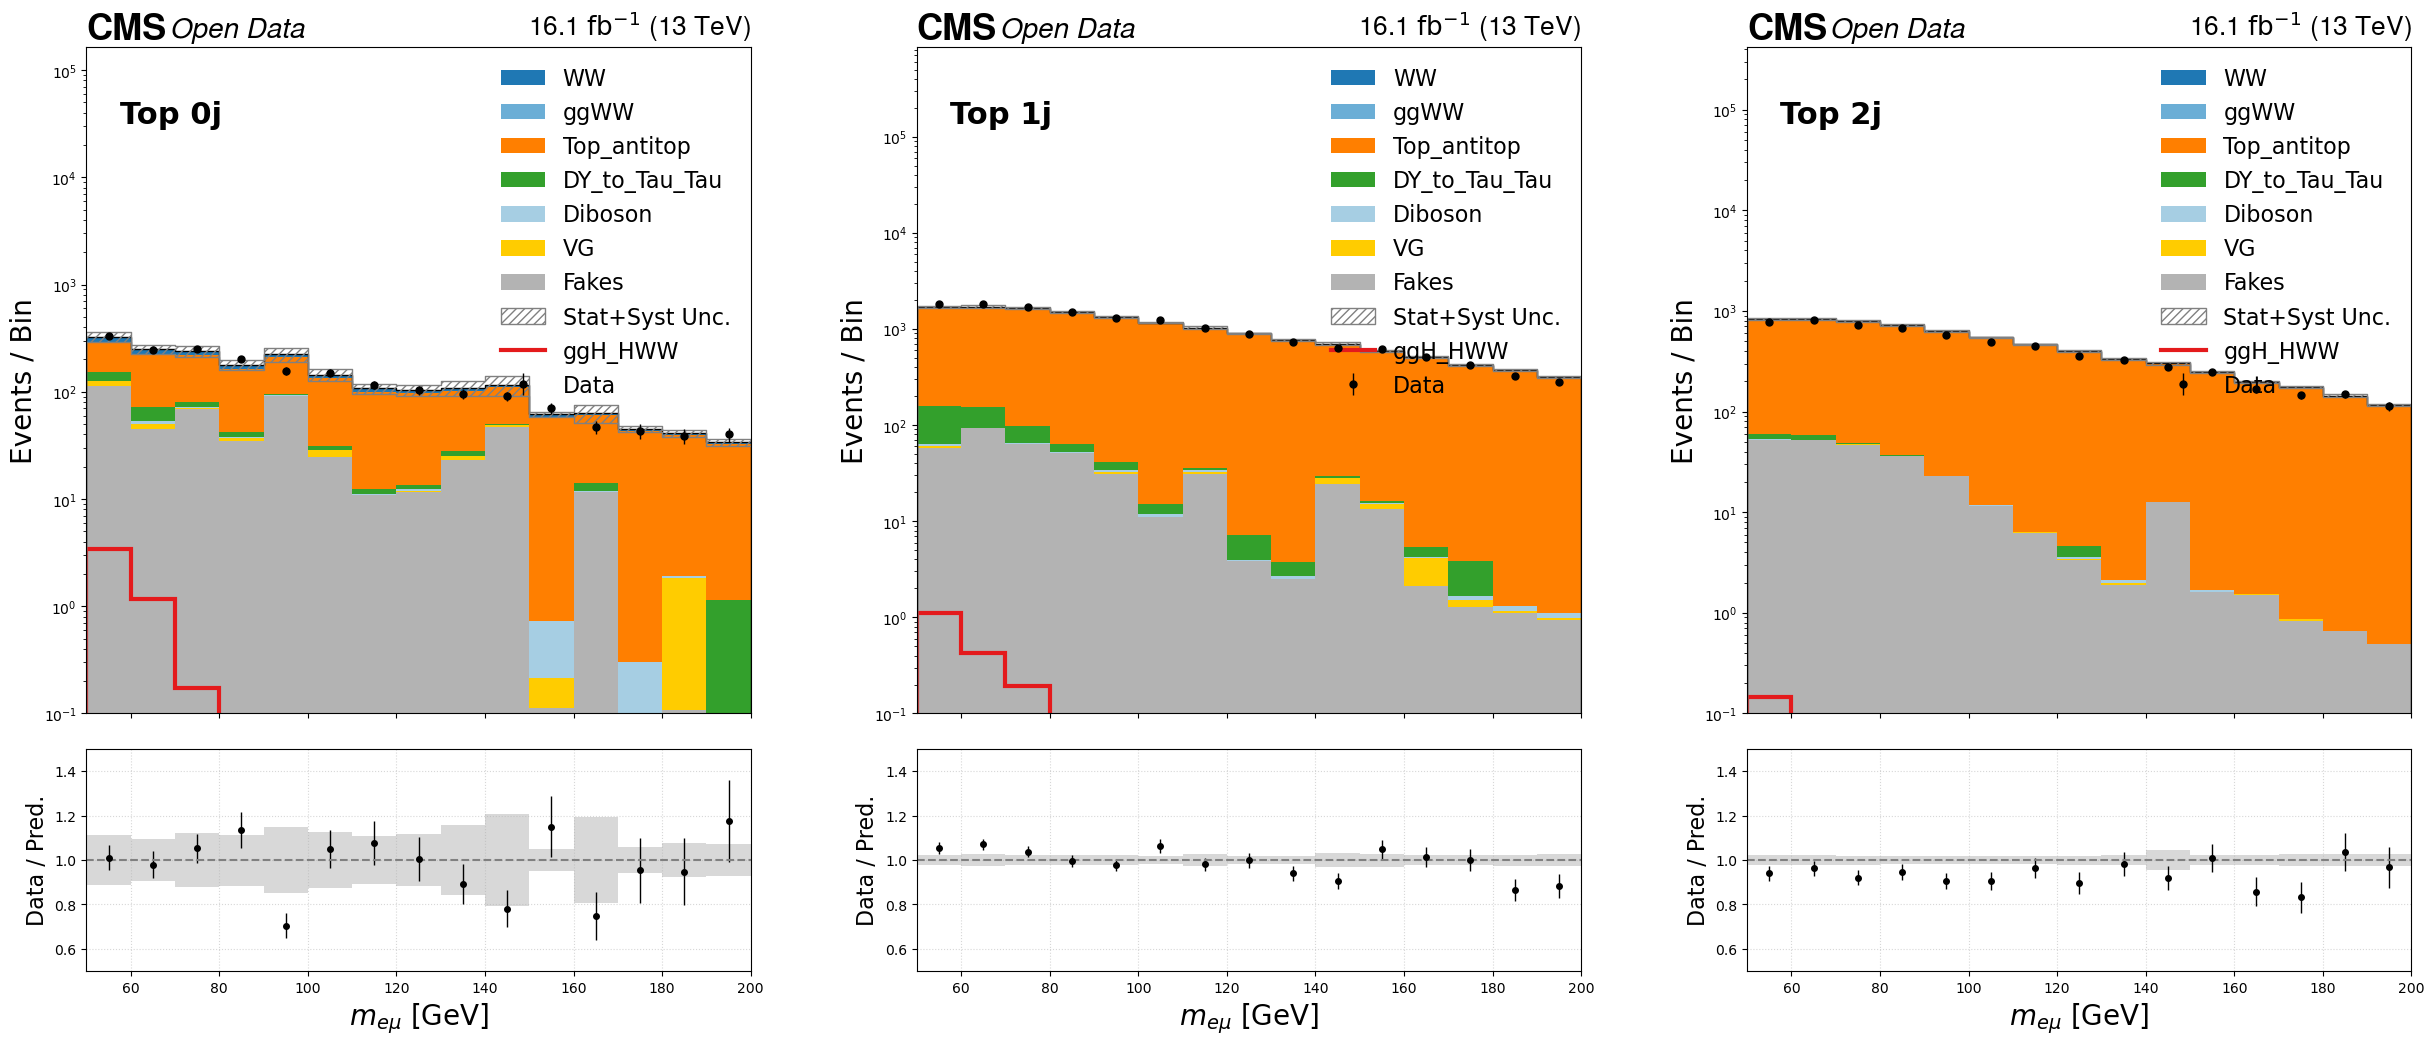

Plotting mass in Control_Region_Tau...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Control_Region_Tau_mass.png


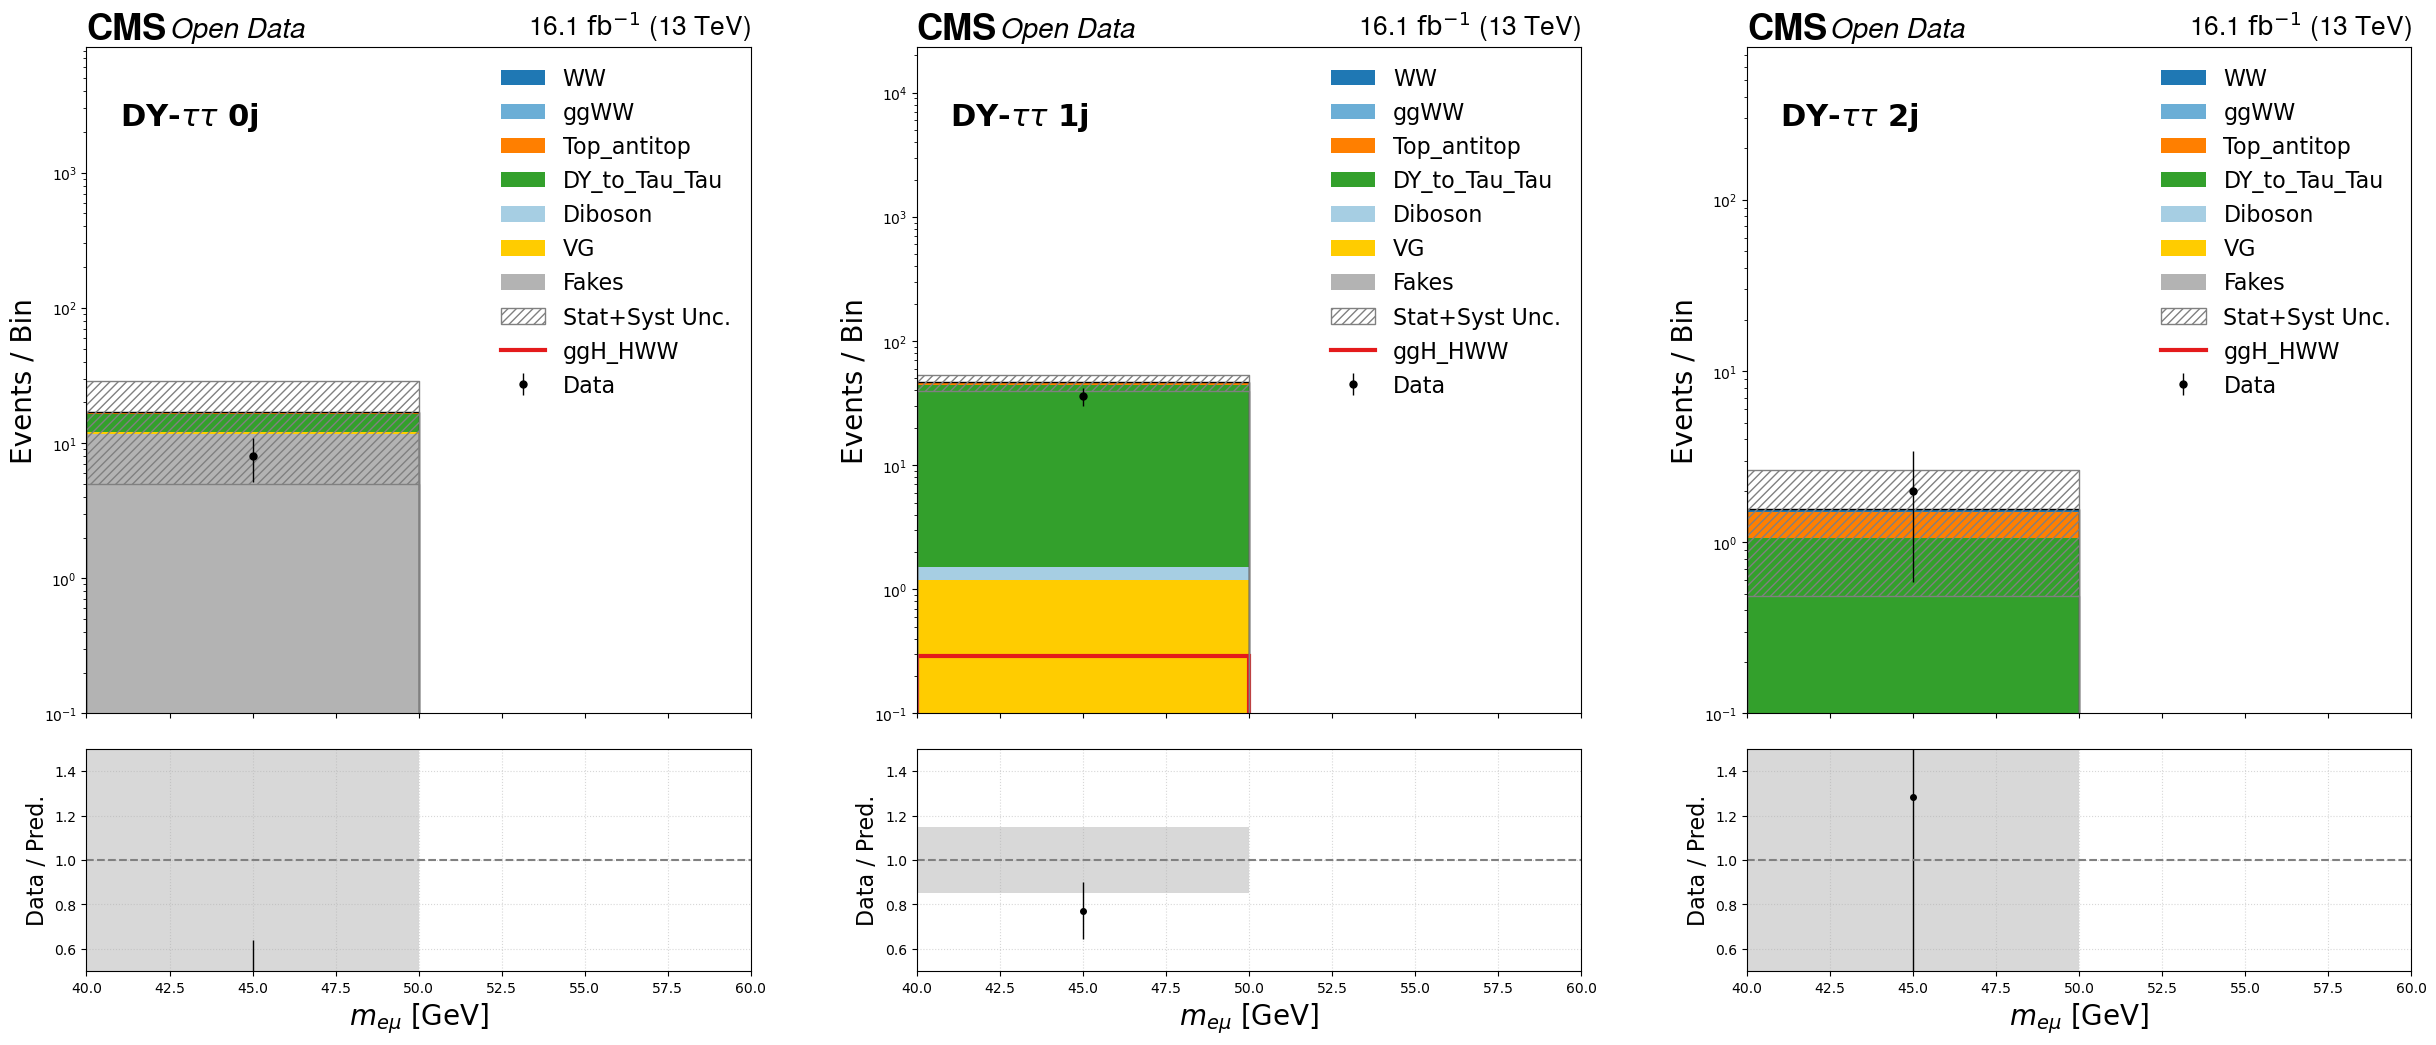

Plotting met in Signal_Region...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Signal_Region_met.png


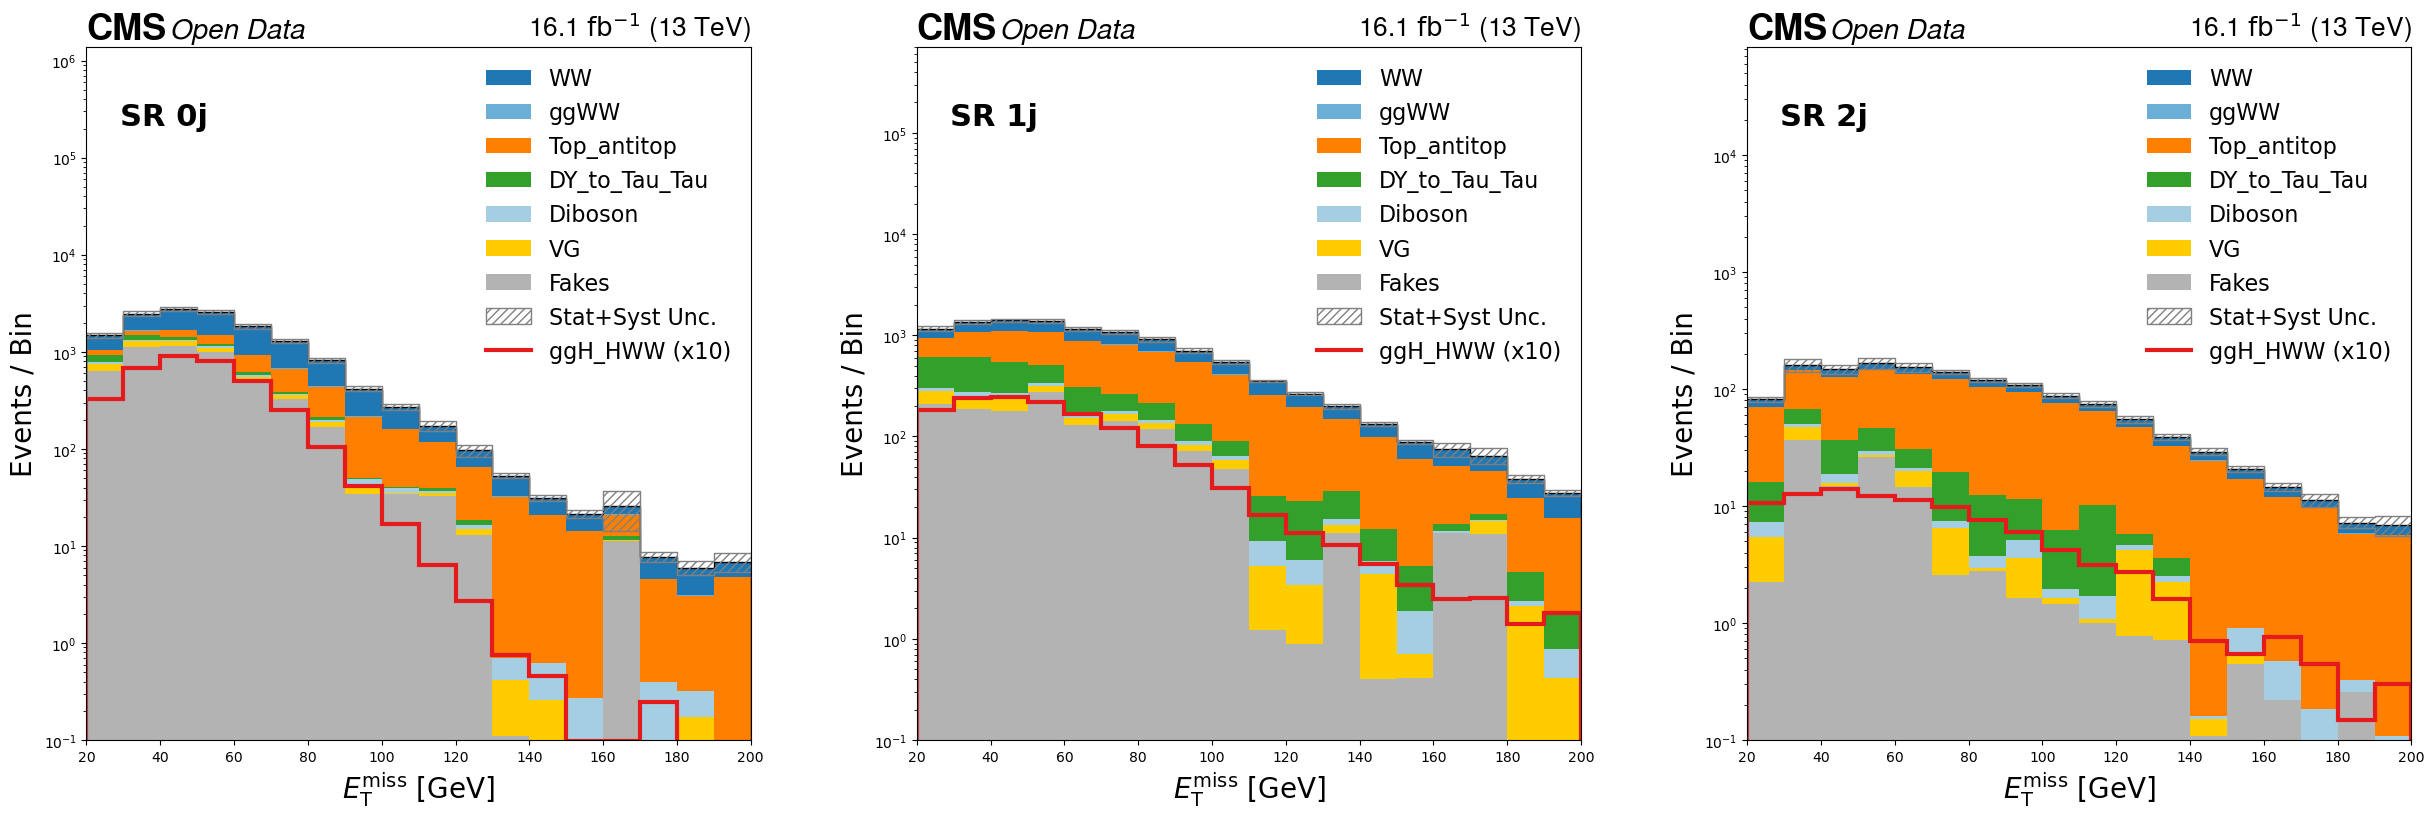

Plotting met in Control_Region_Top...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Control_Region_Top_met.png


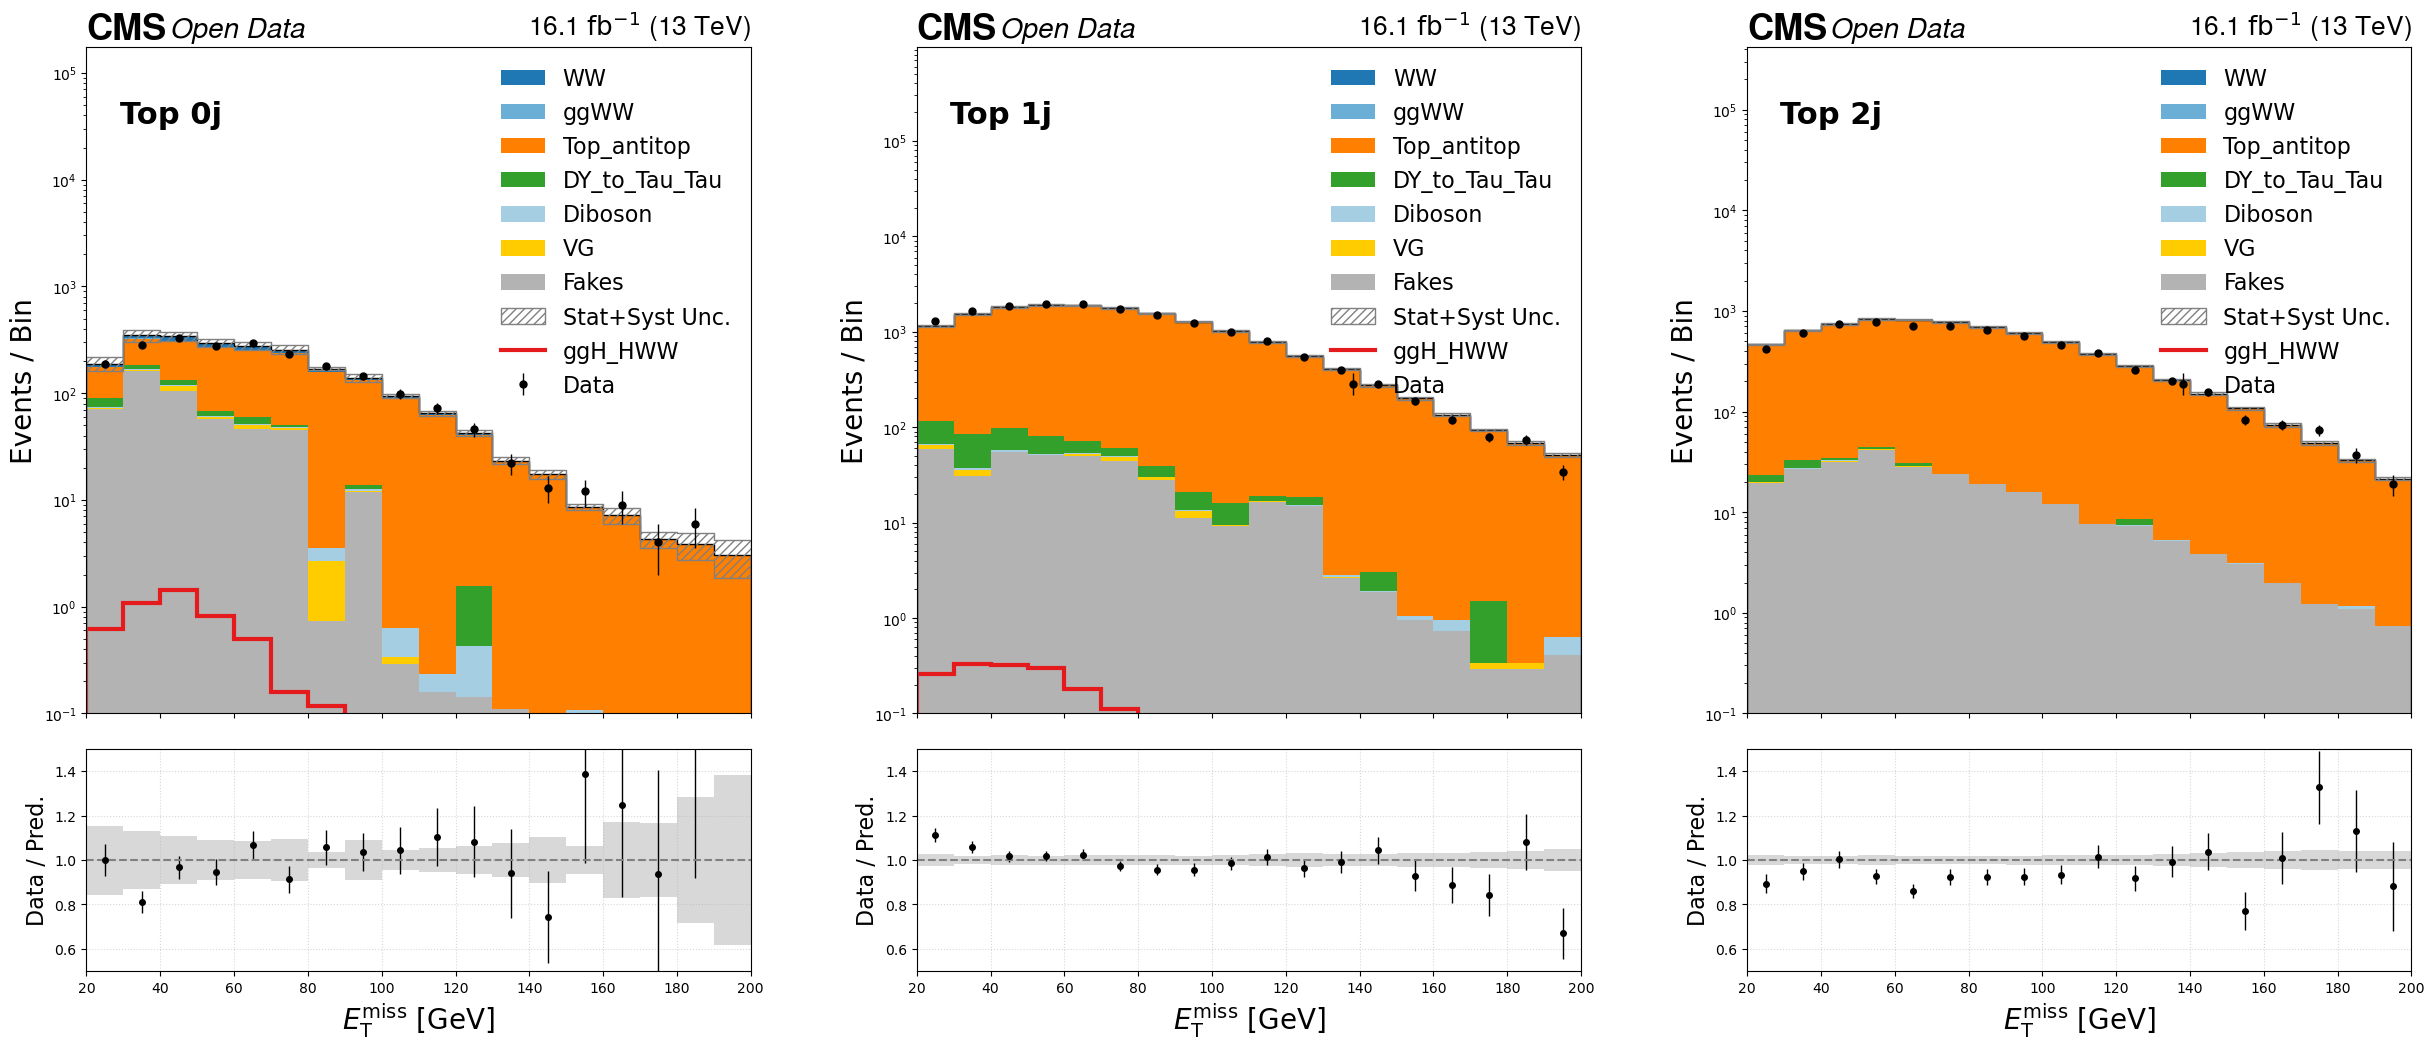

Plotting met in Control_Region_Tau...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Control_Region_Tau_met.png


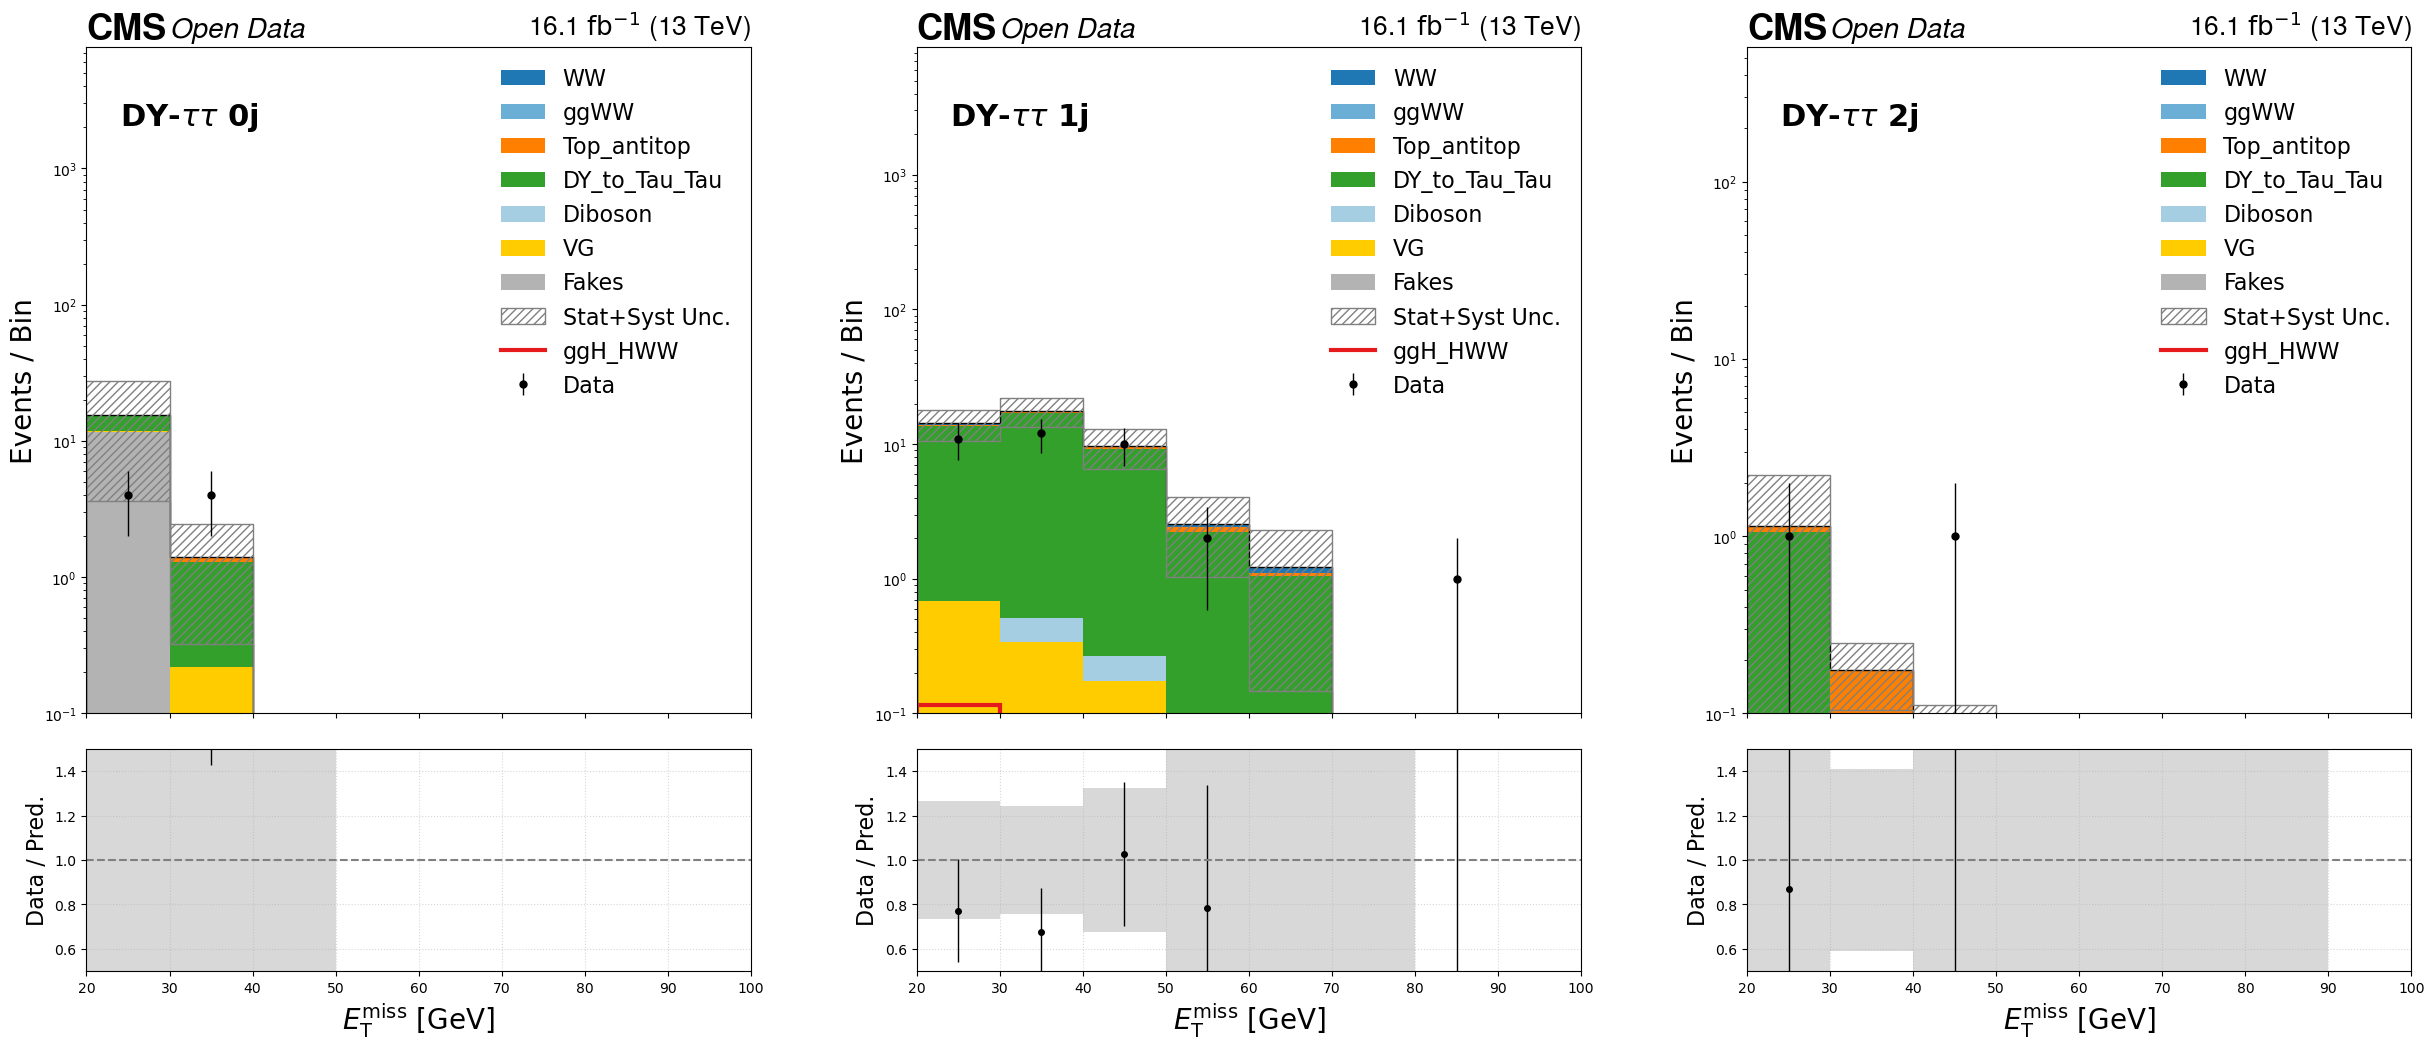

Plotting ptll in Signal_Region...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Signal_Region_ptll.png


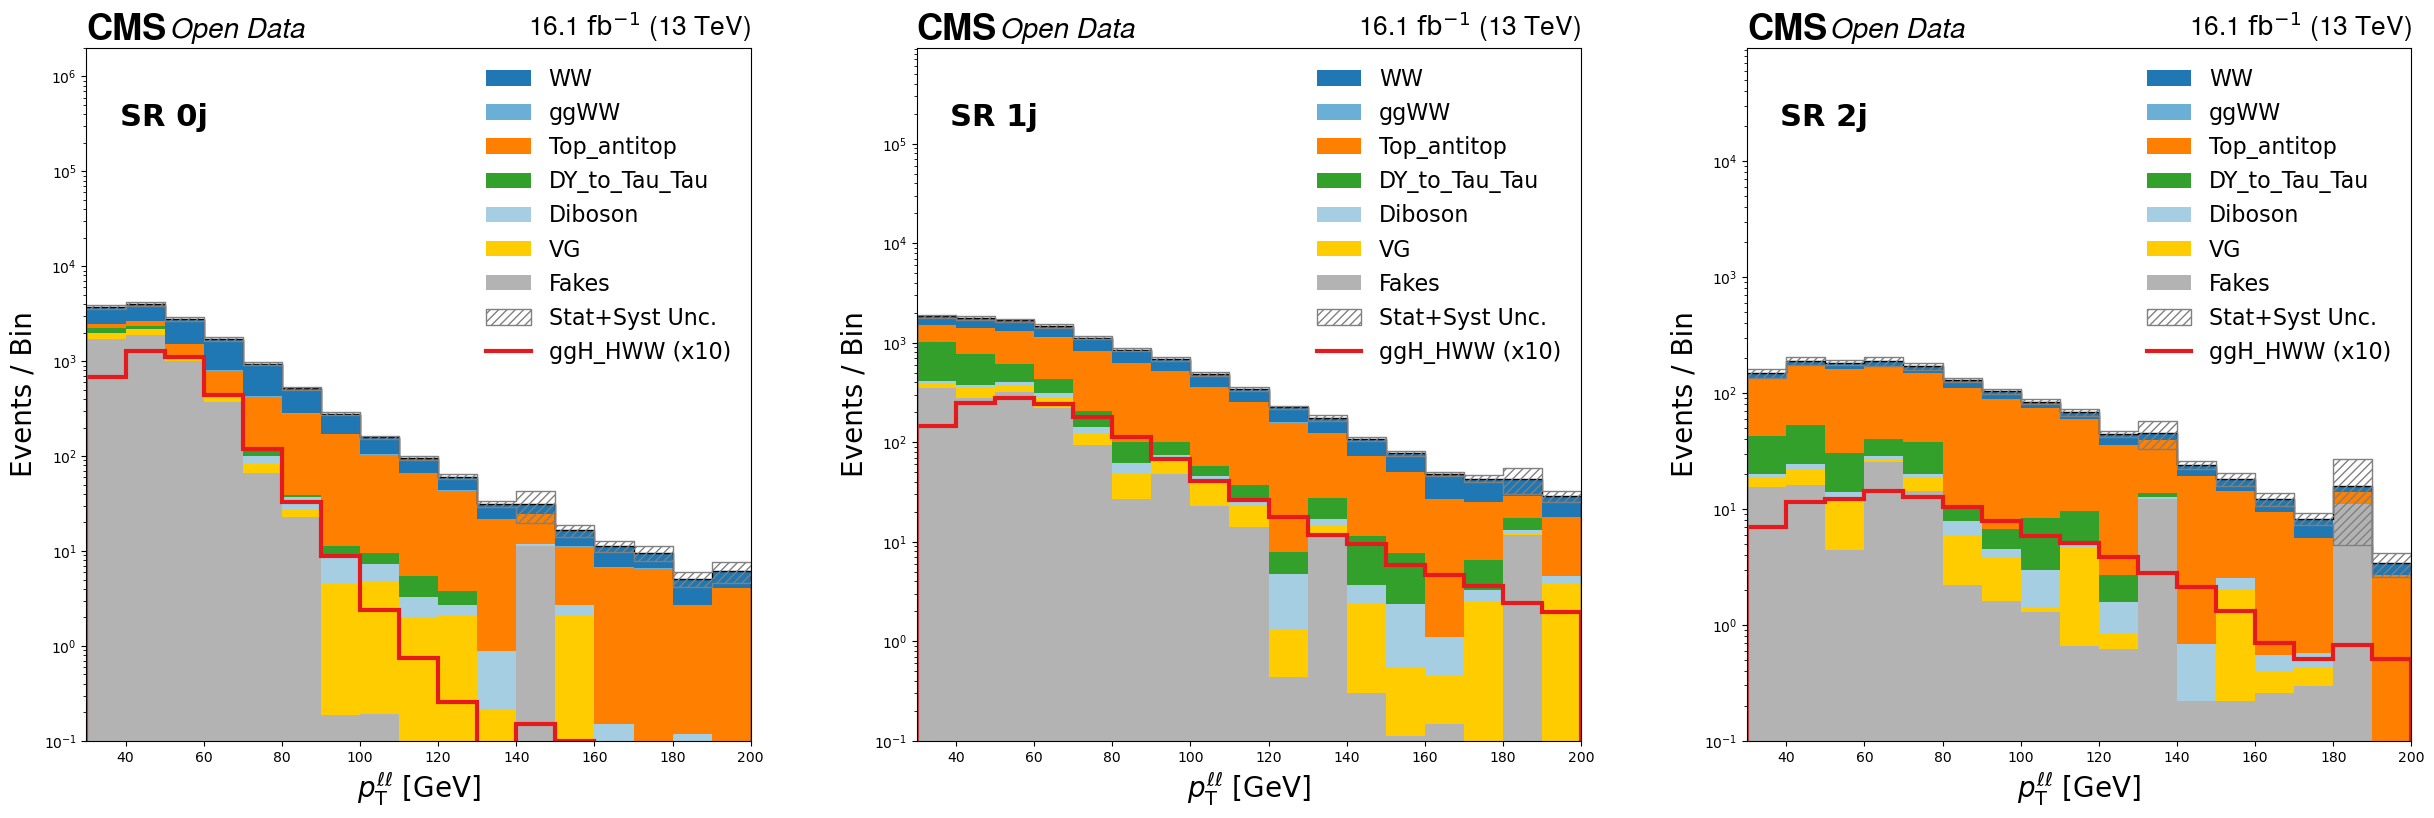

Plotting ptll in Control_Region_Top...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Control_Region_Top_ptll.png


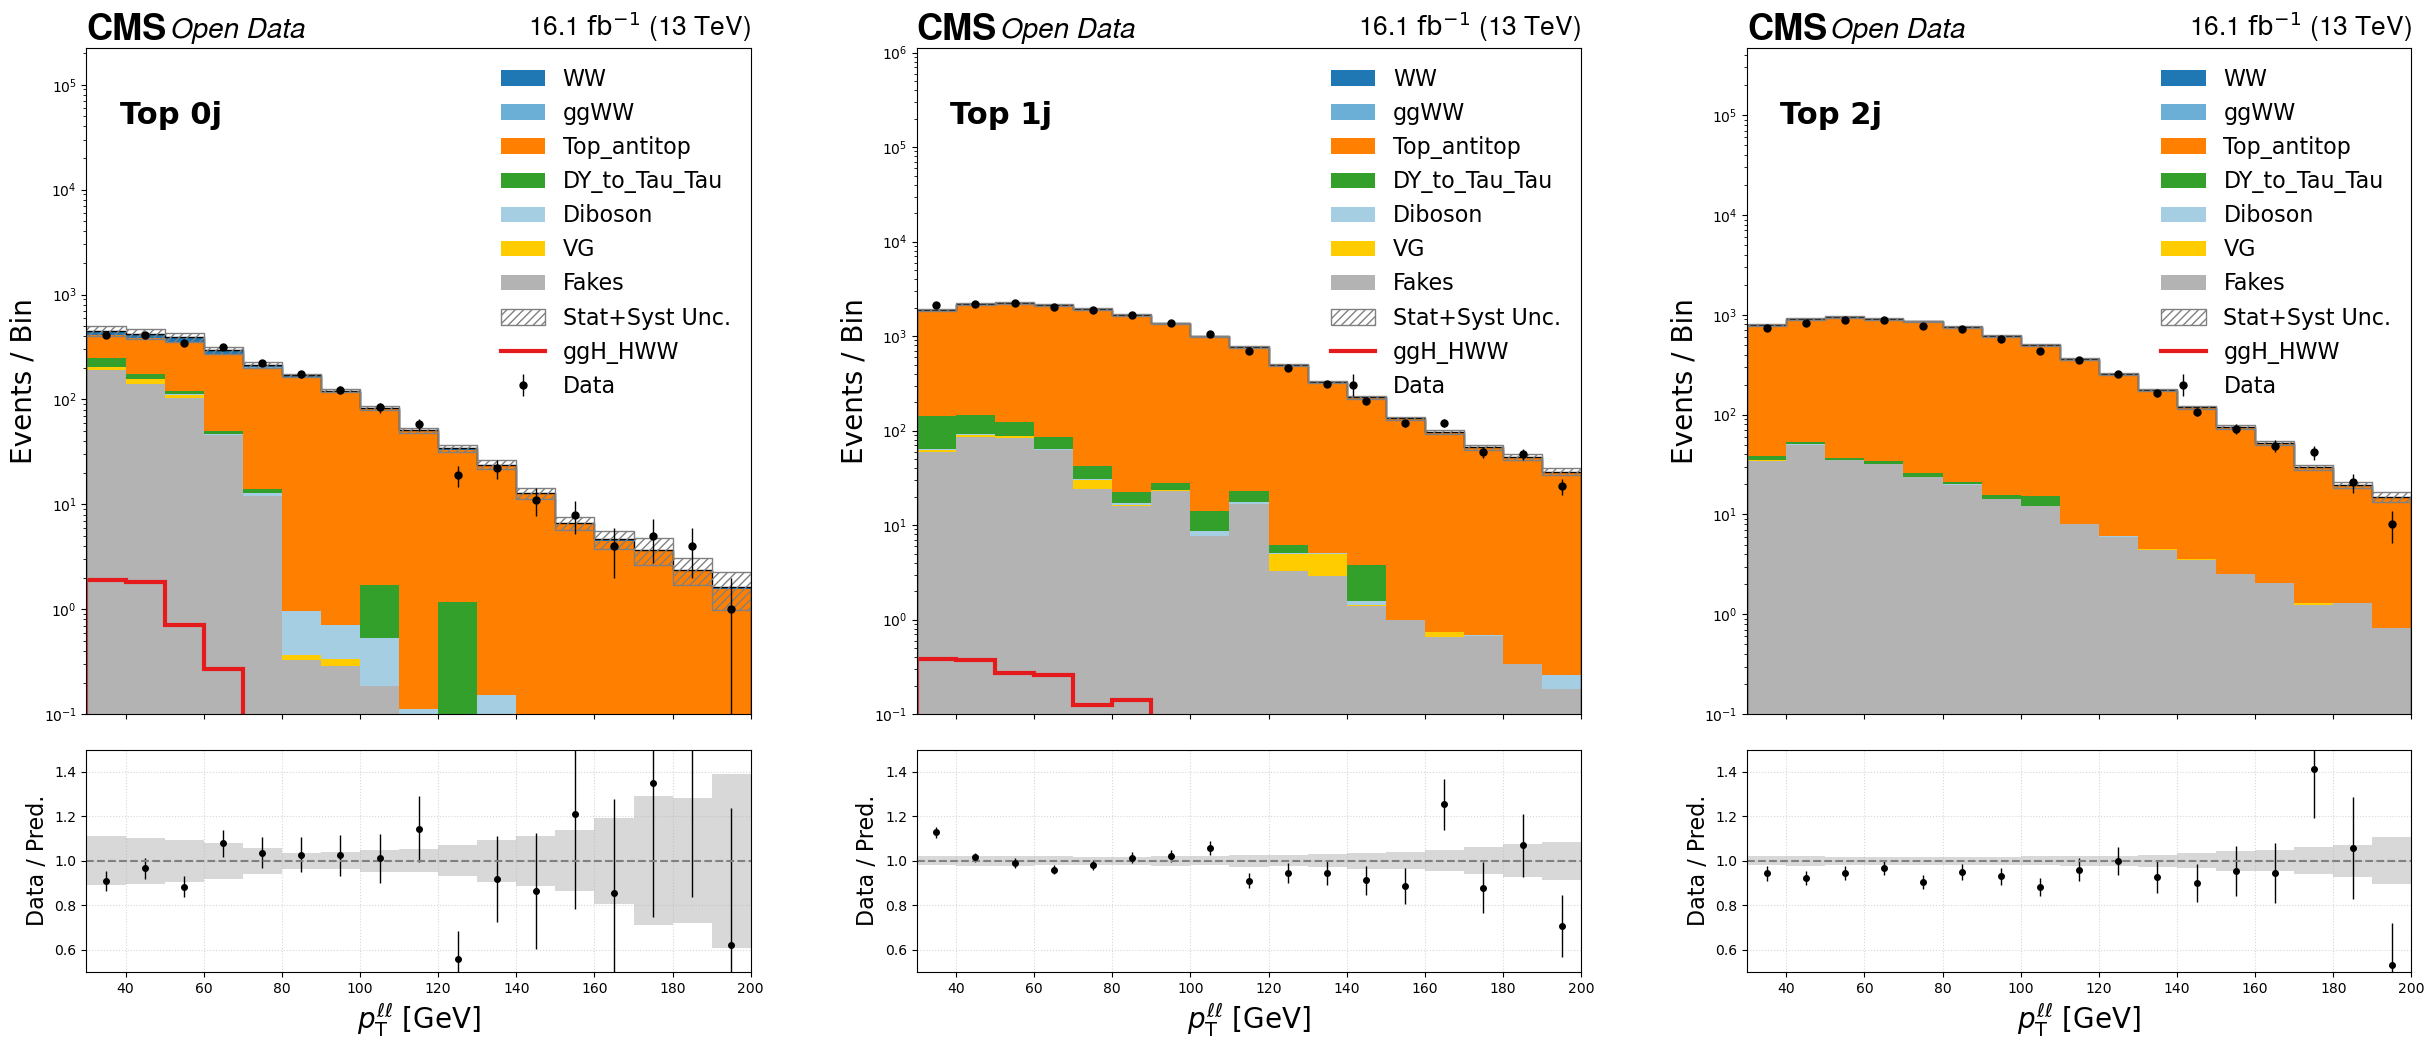

Plotting ptll in Control_Region_Tau...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Control_Region_Tau_ptll.png


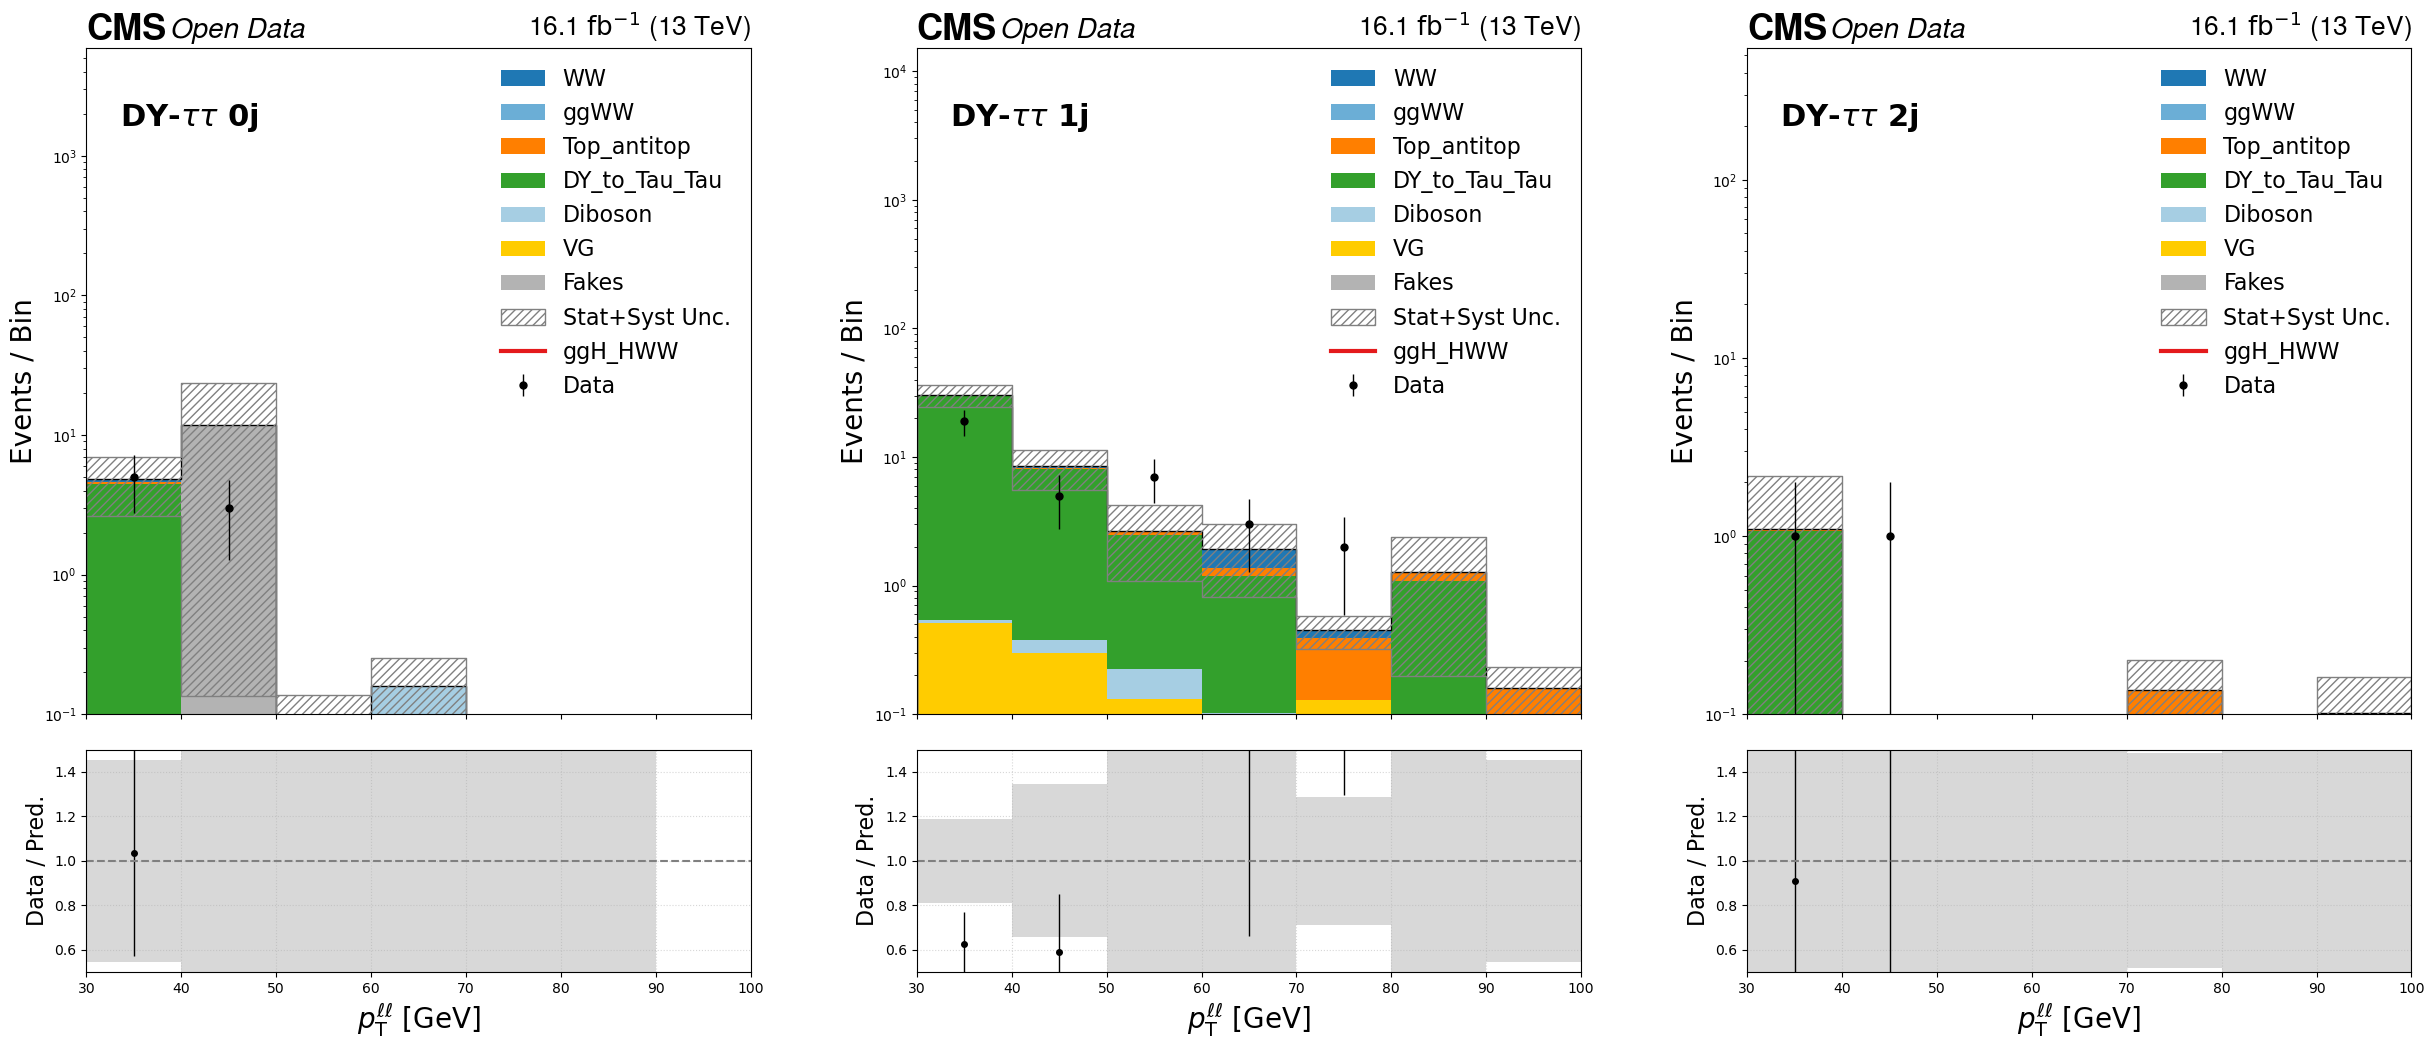

Plotting dphi in Signal_Region...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Signal_Region_dphi.png


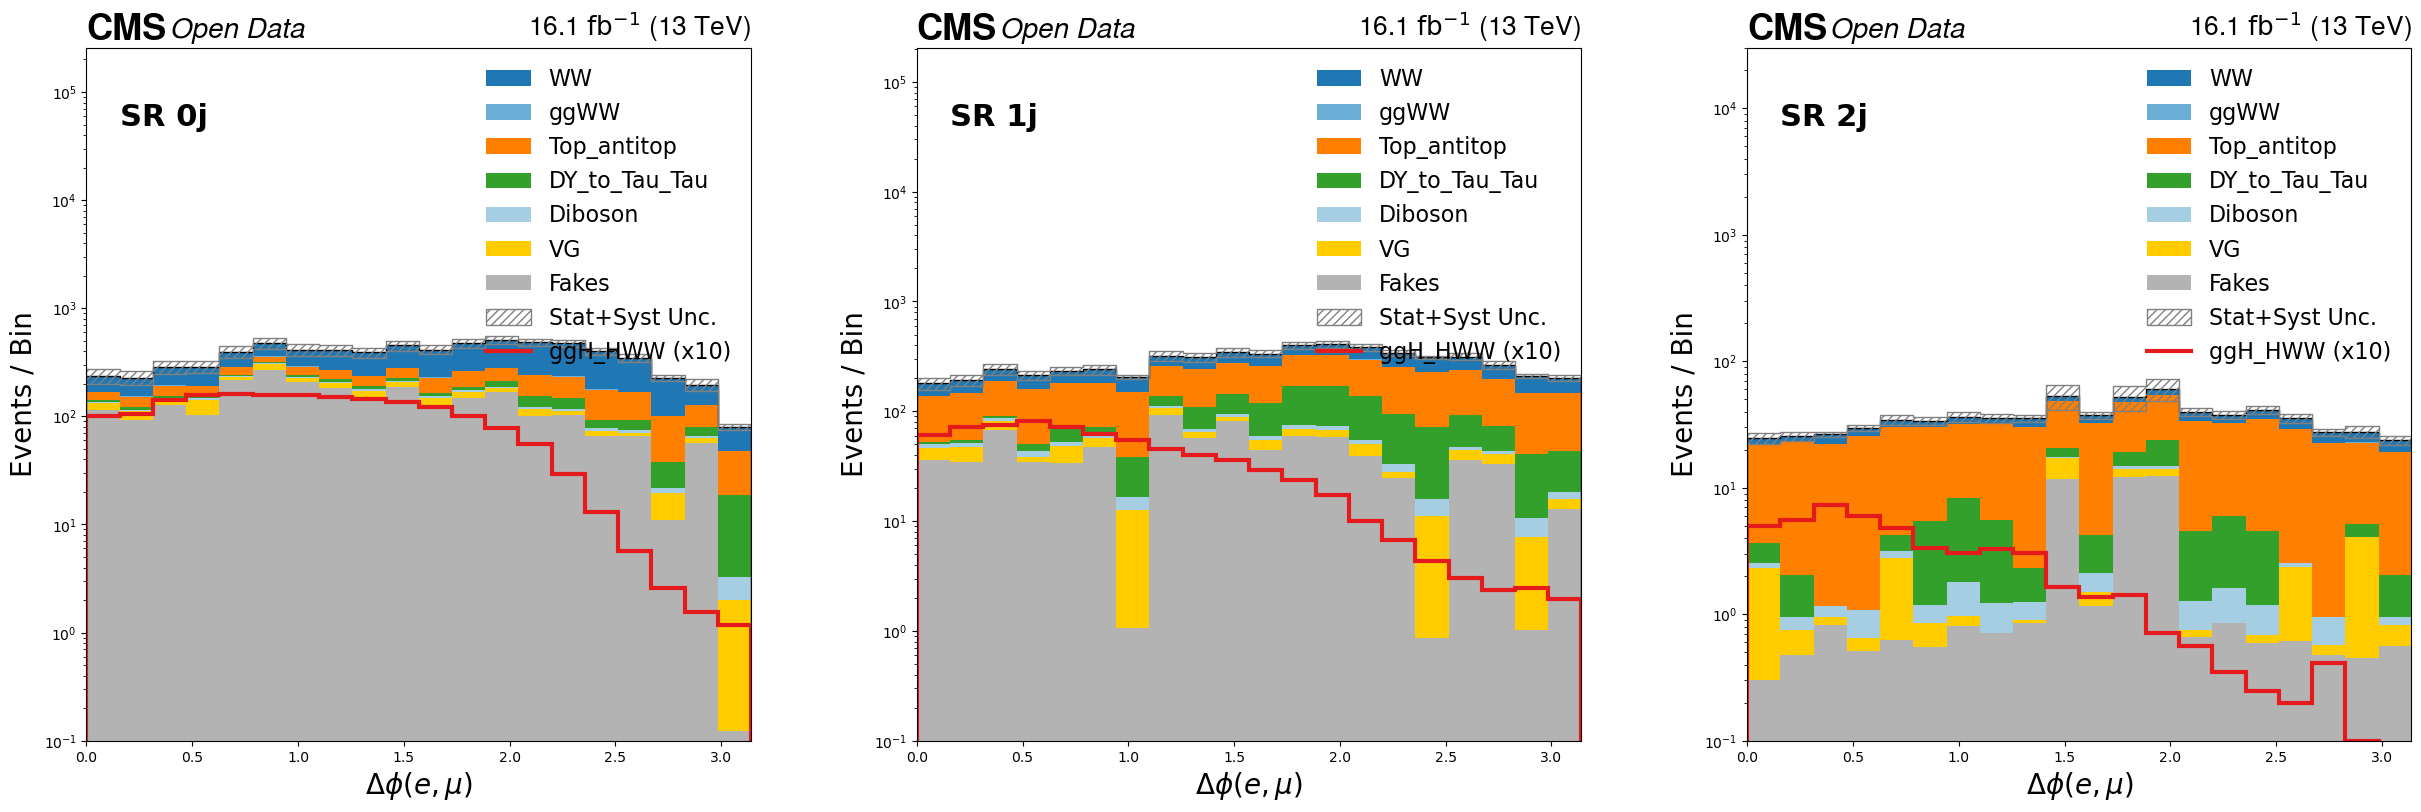

Plotting dphi in Control_Region_Top...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Control_Region_Top_dphi.png


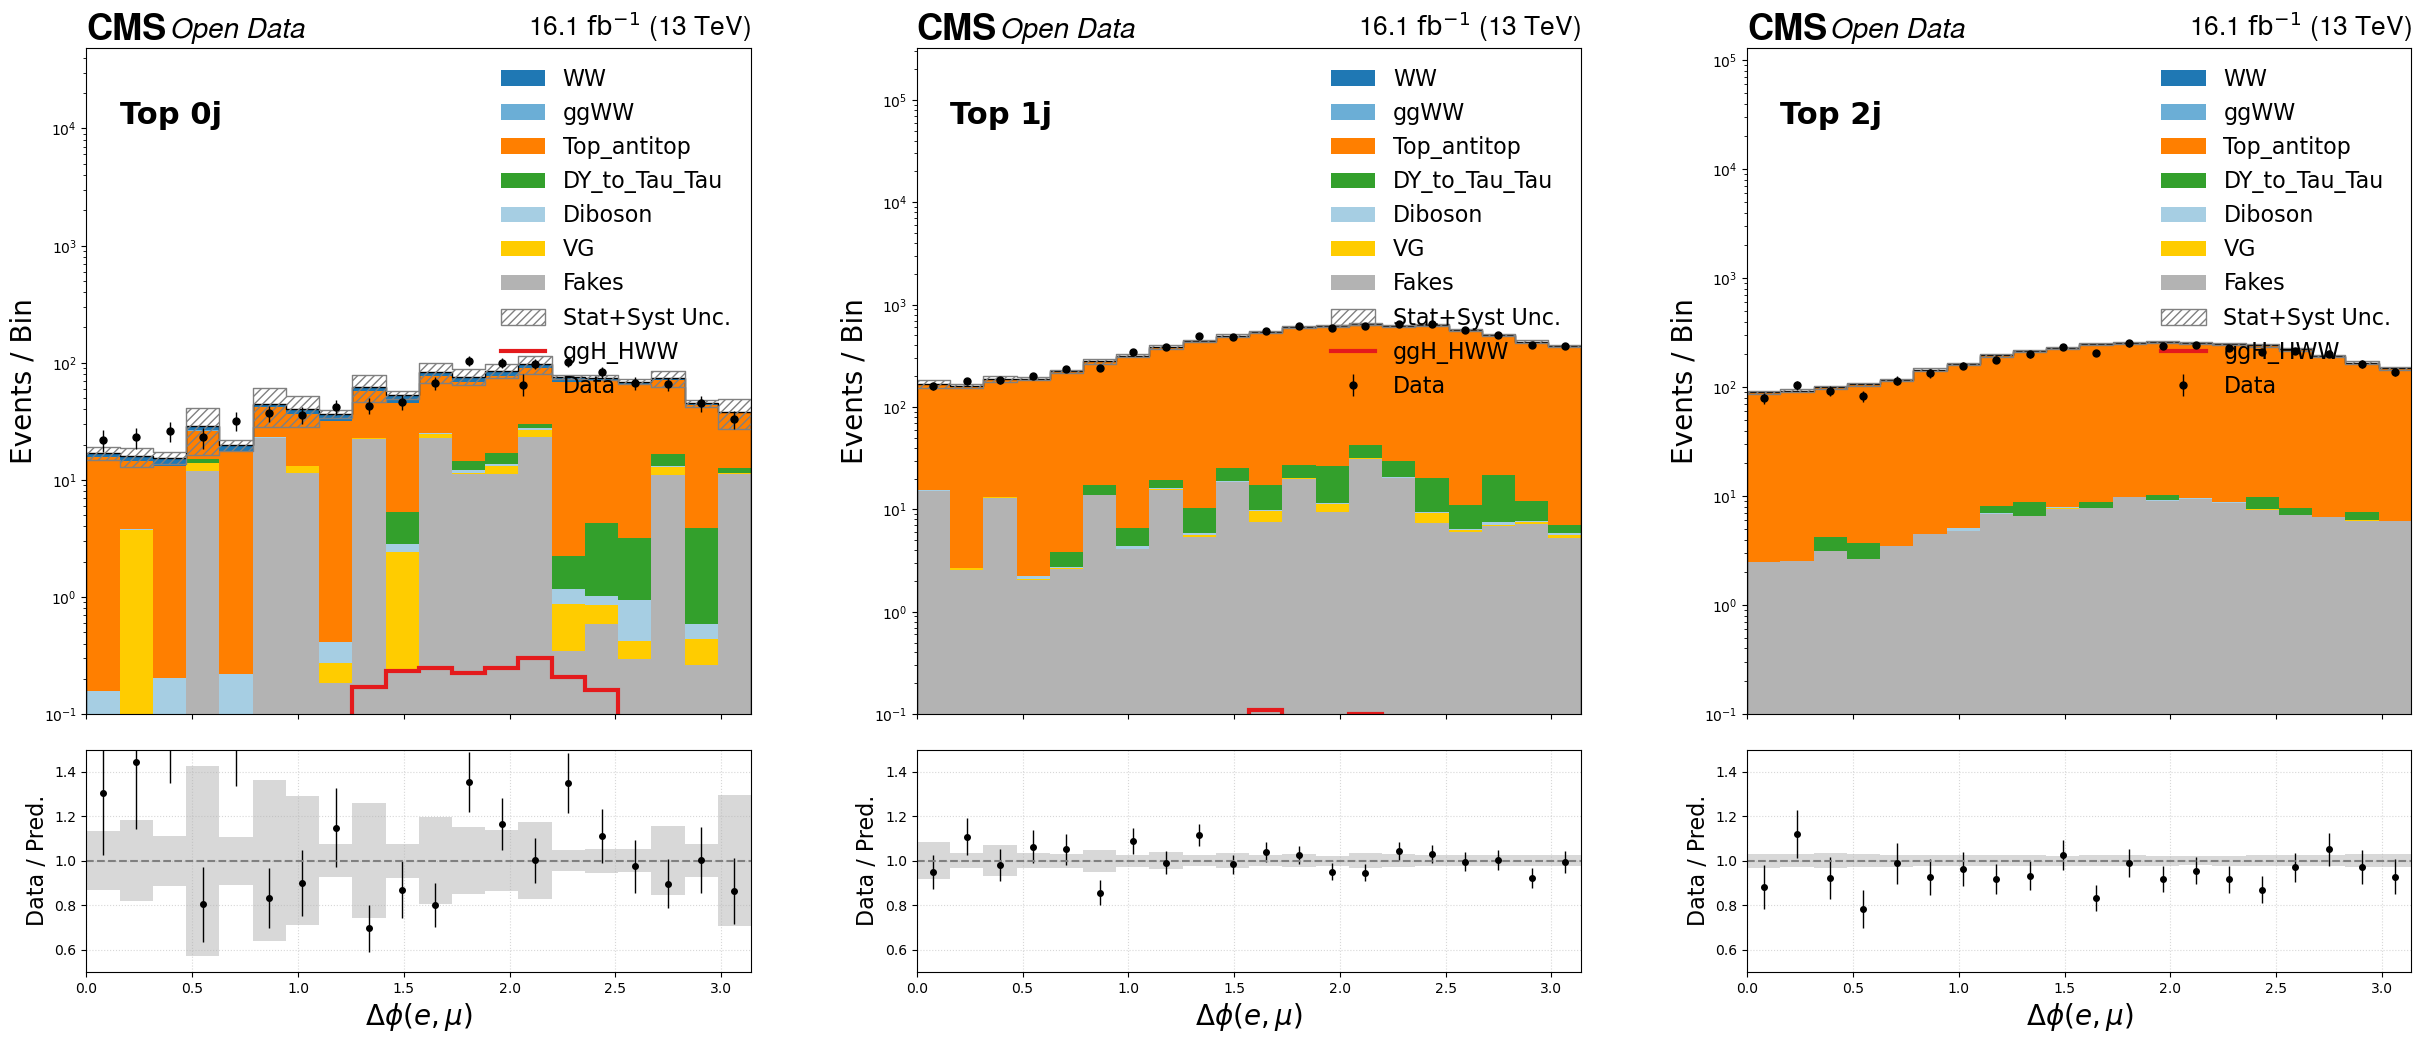

Plotting dphi in Control_Region_Tau...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Control_Region_Tau_dphi.png


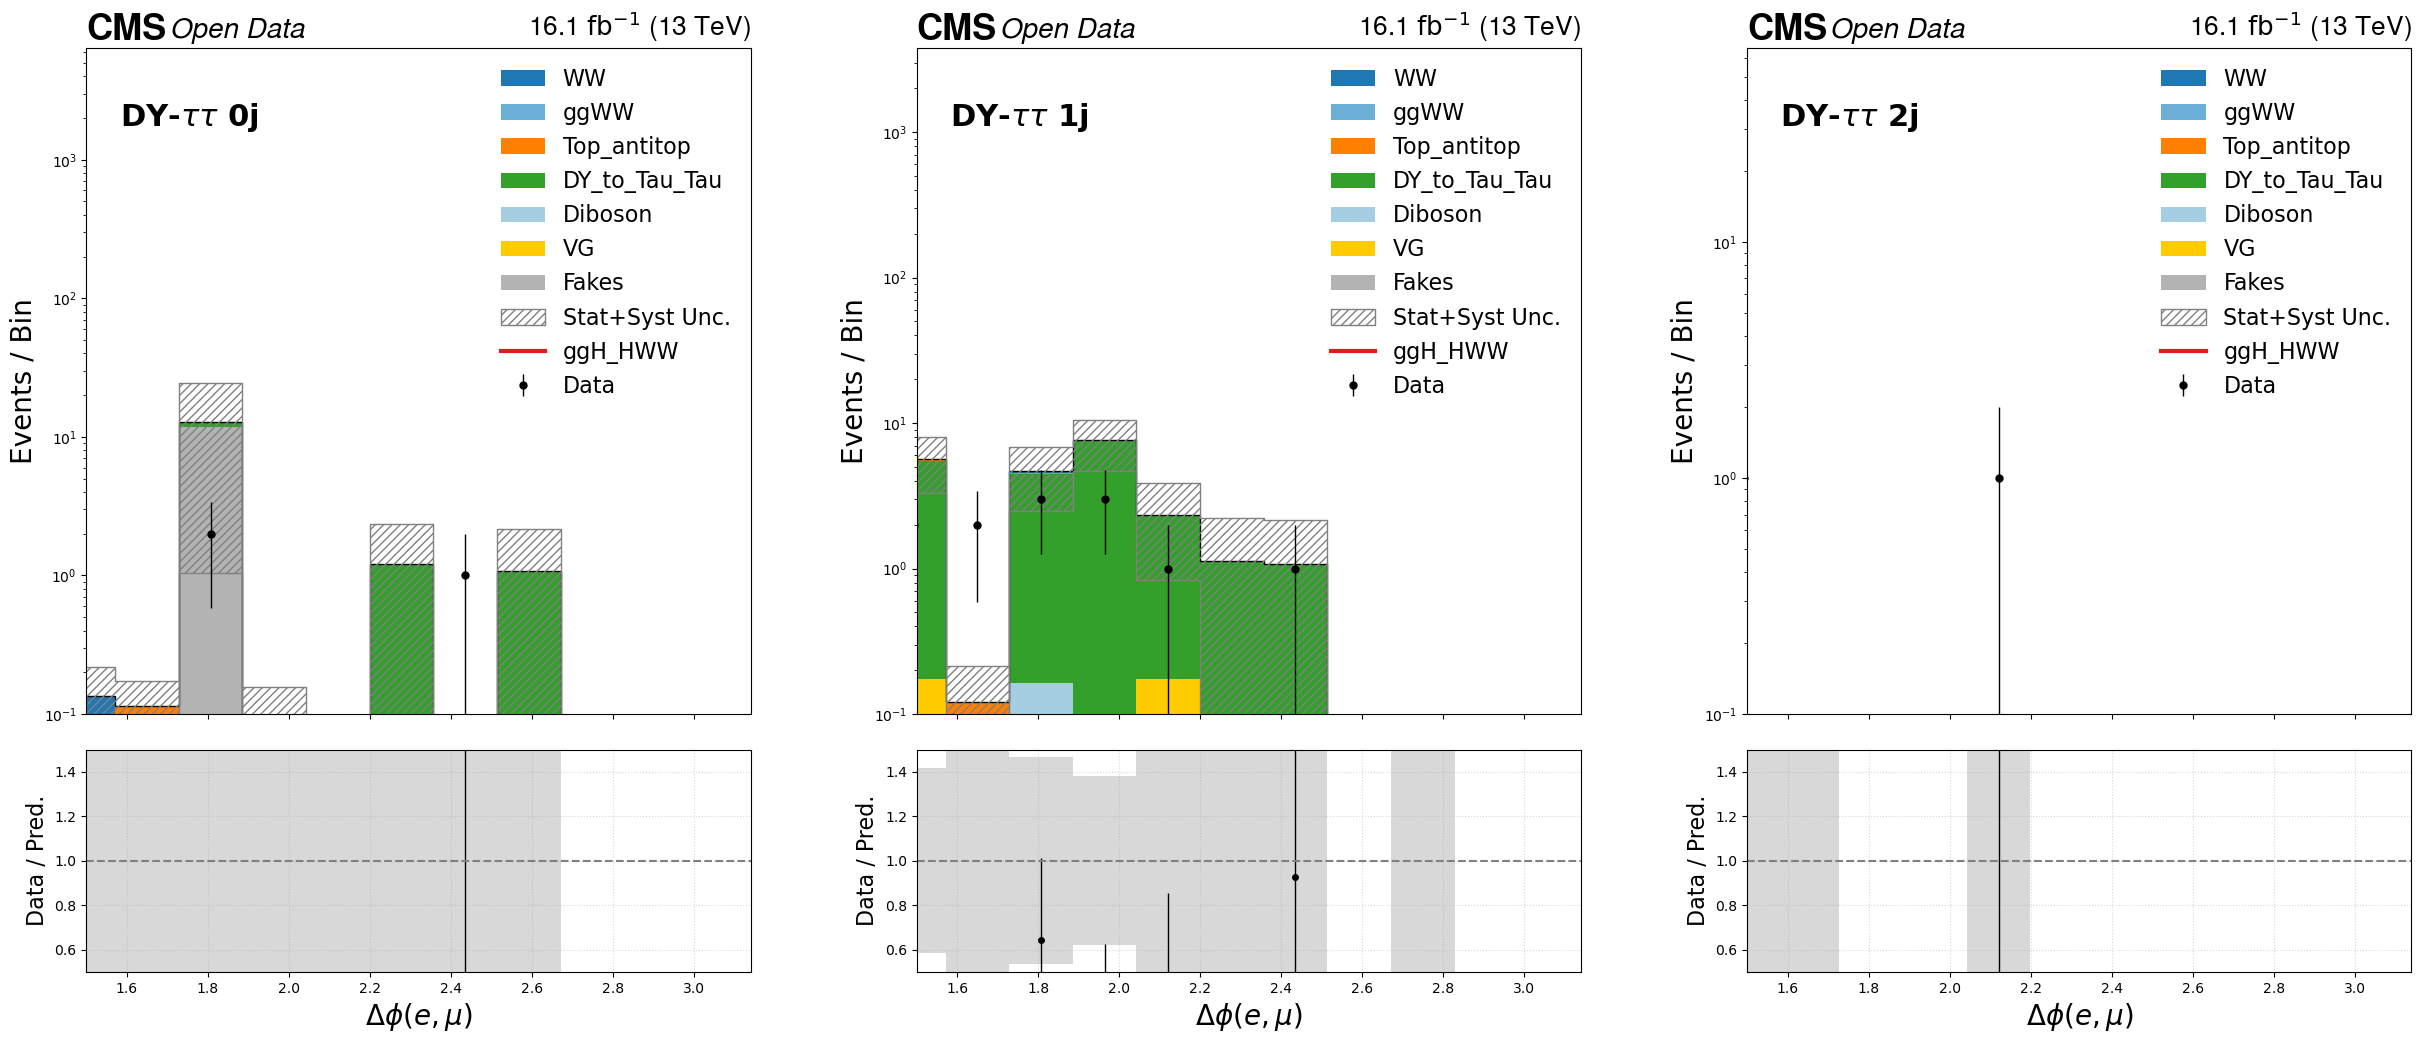

Plotting mt_higgs in Signal_Region...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Signal_Region_mt_higgs.png


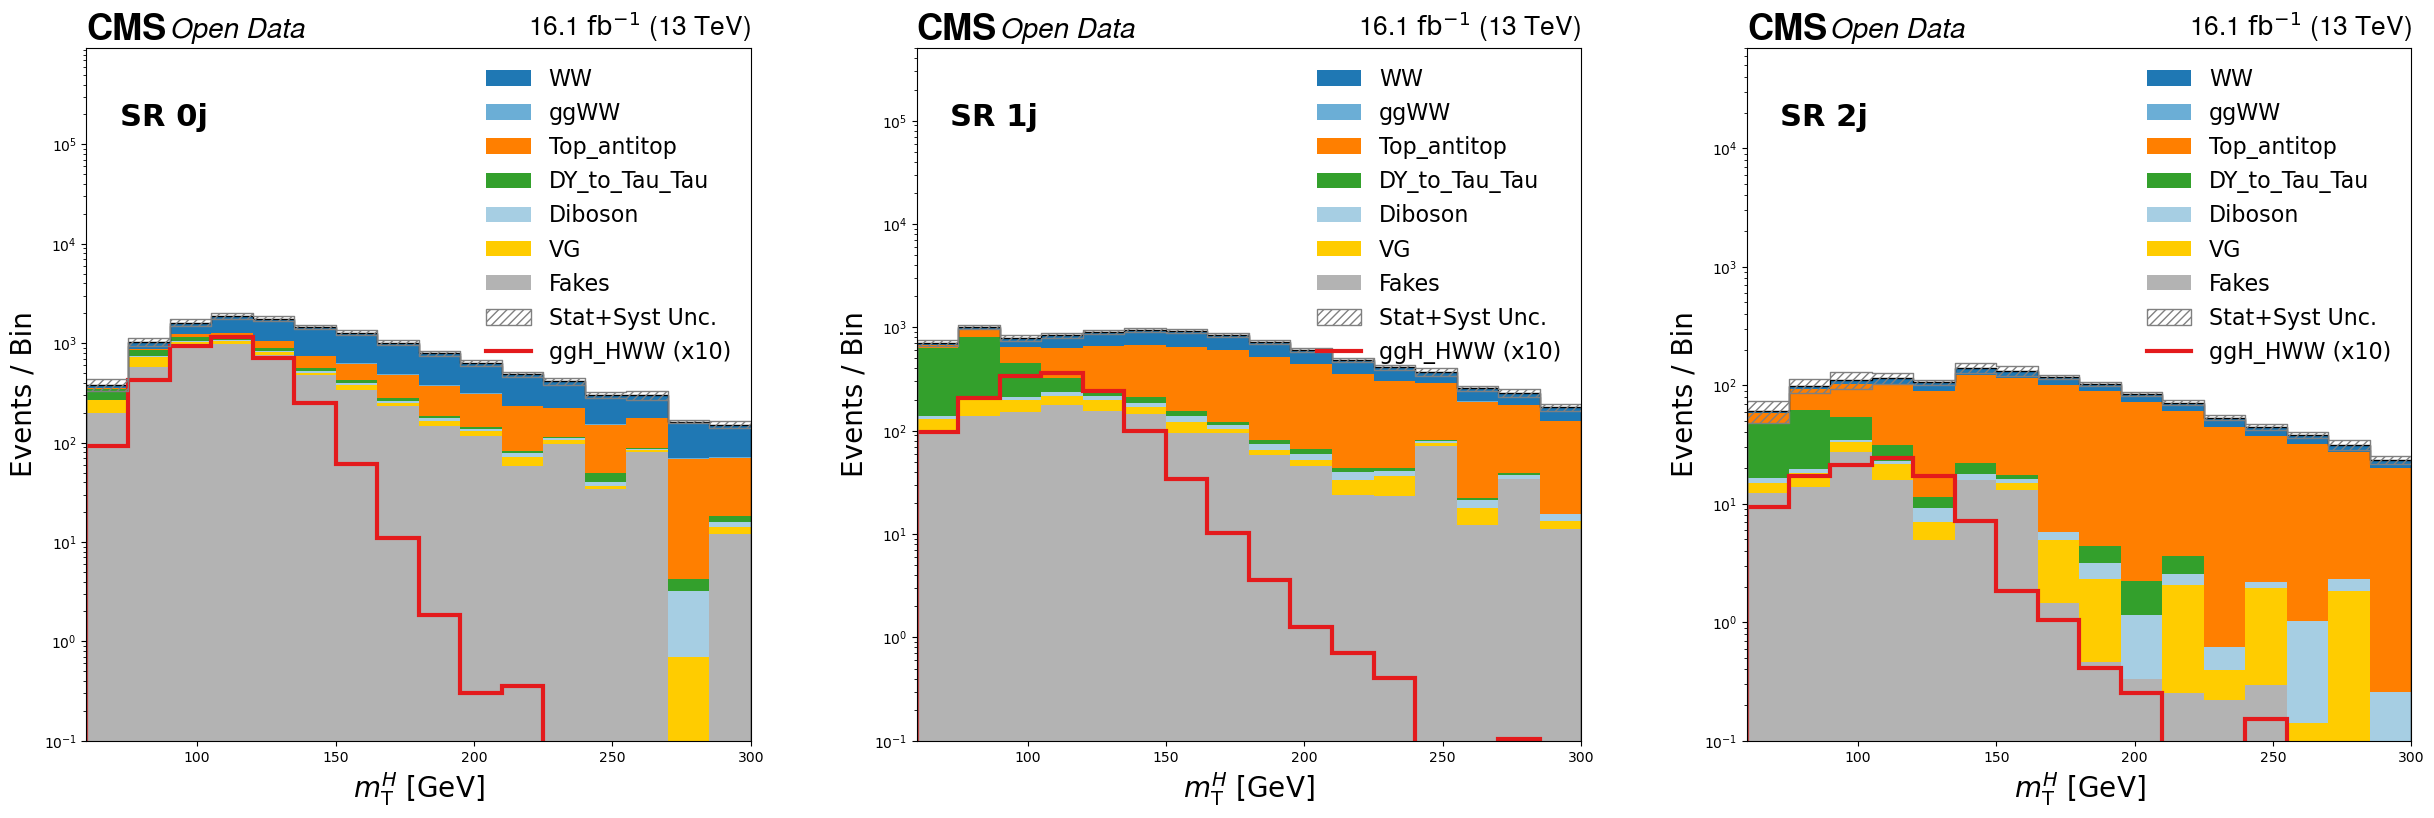

Plotting mt_higgs in Control_Region_Top...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Control_Region_Top_mt_higgs.png


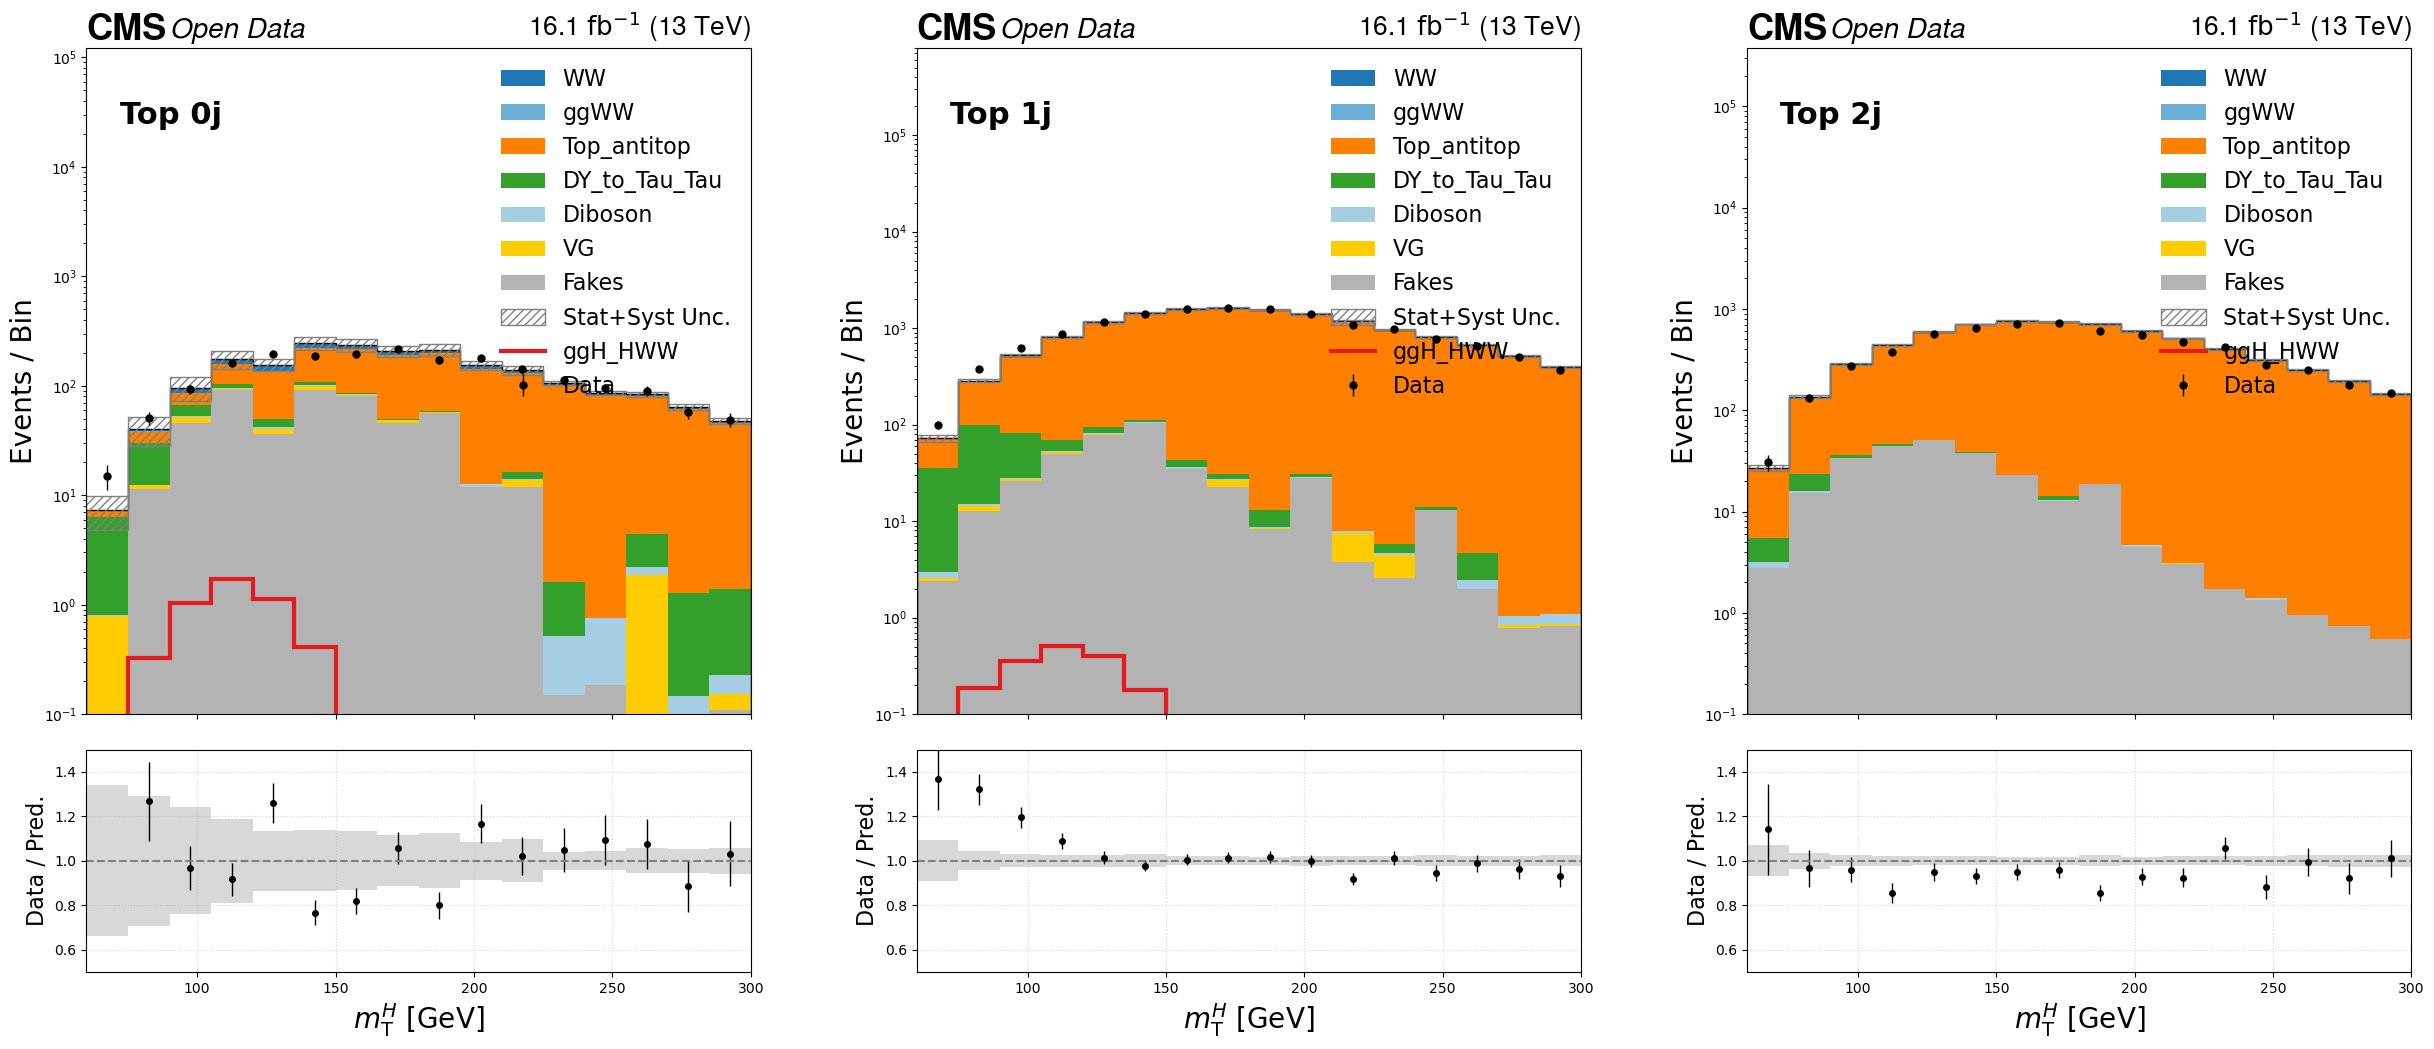

Plotting mt_higgs in Control_Region_Tau...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Control_Region_Tau_mt_higgs.png


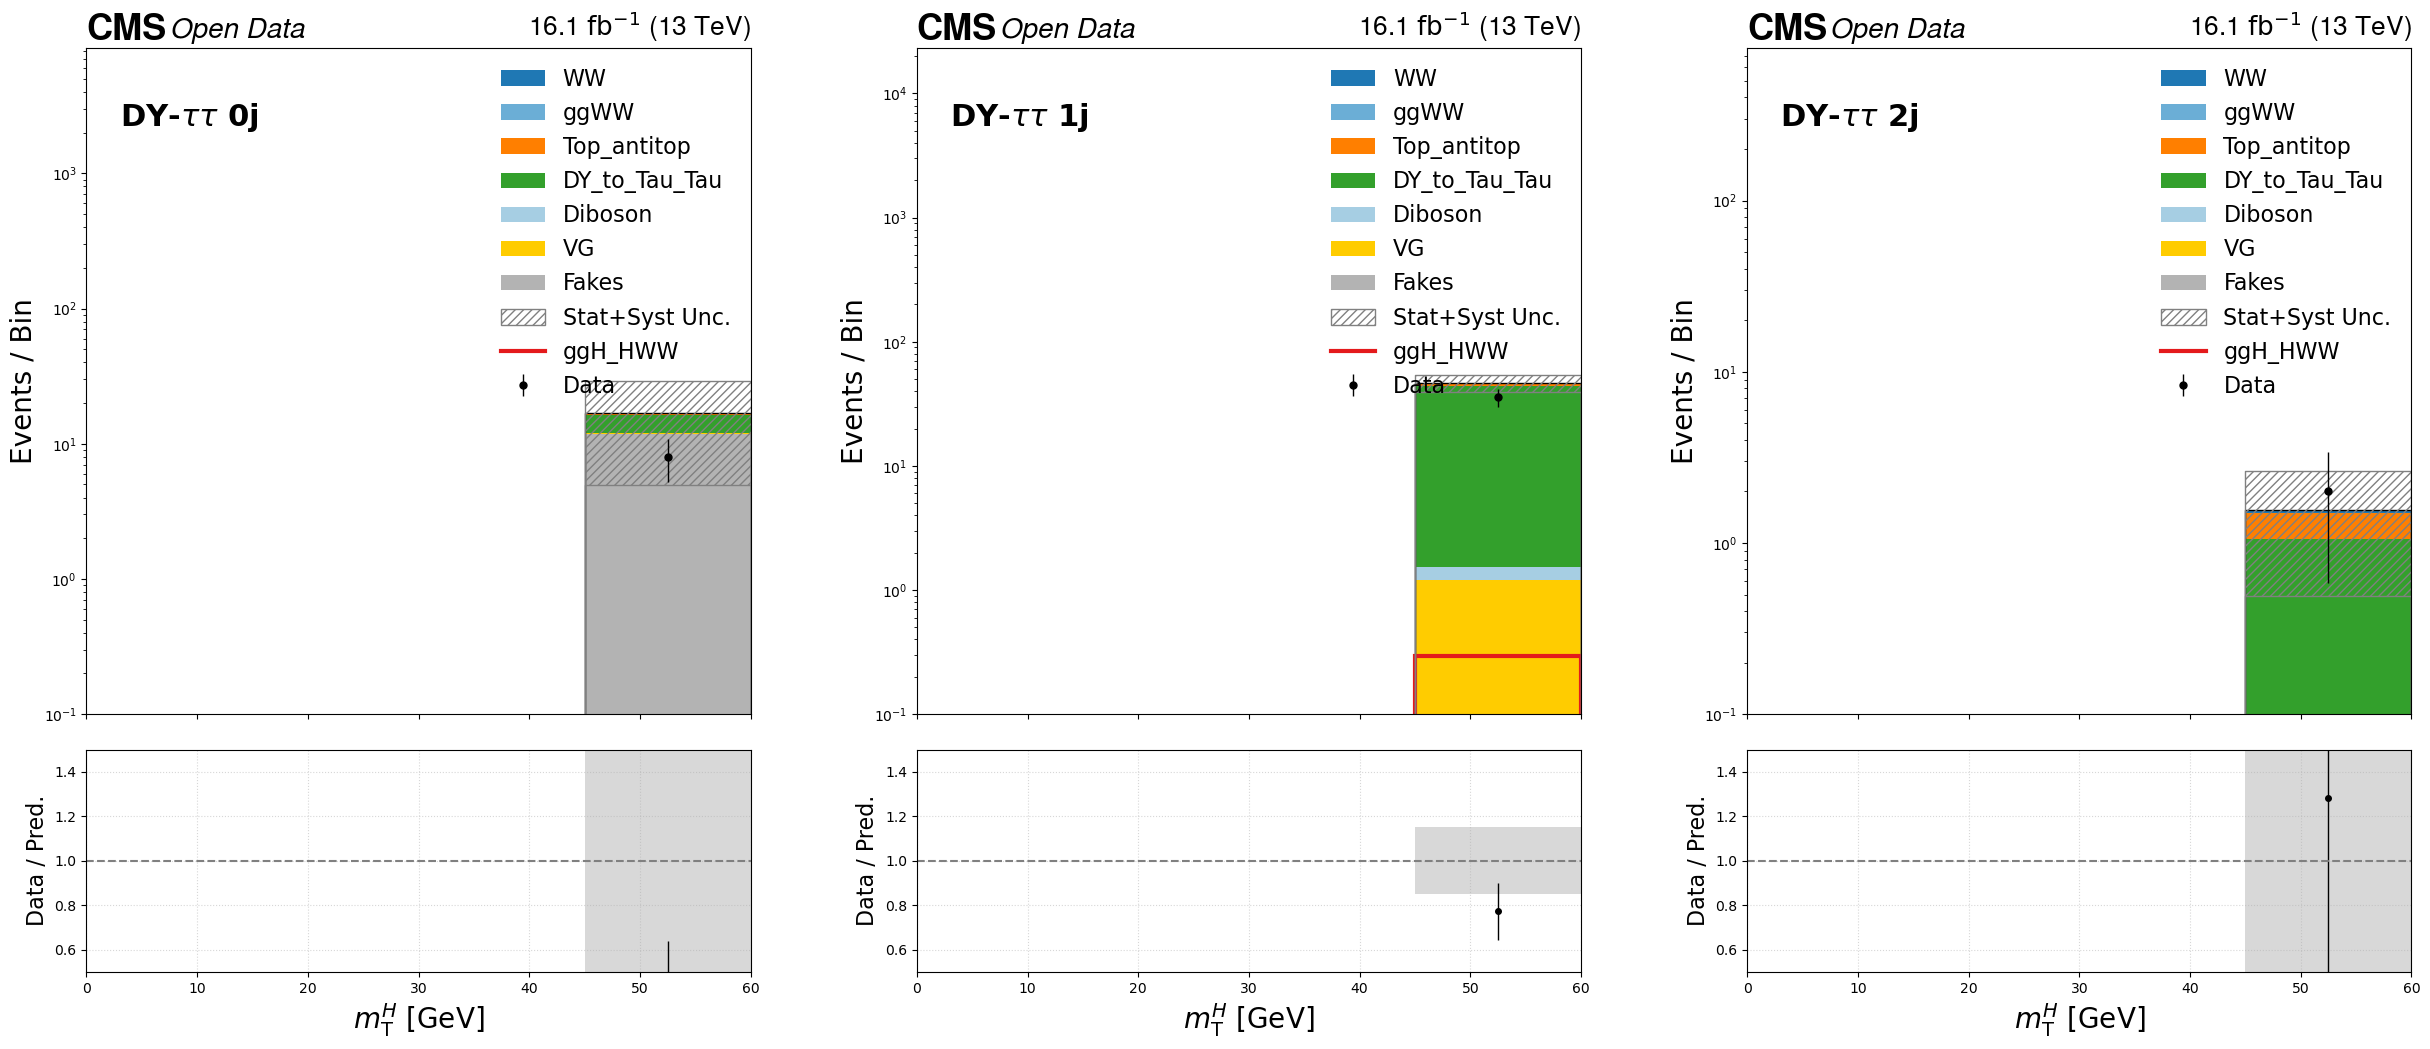

Plotting mt_l2_met in Signal_Region...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Signal_Region_mt_l2_met.png


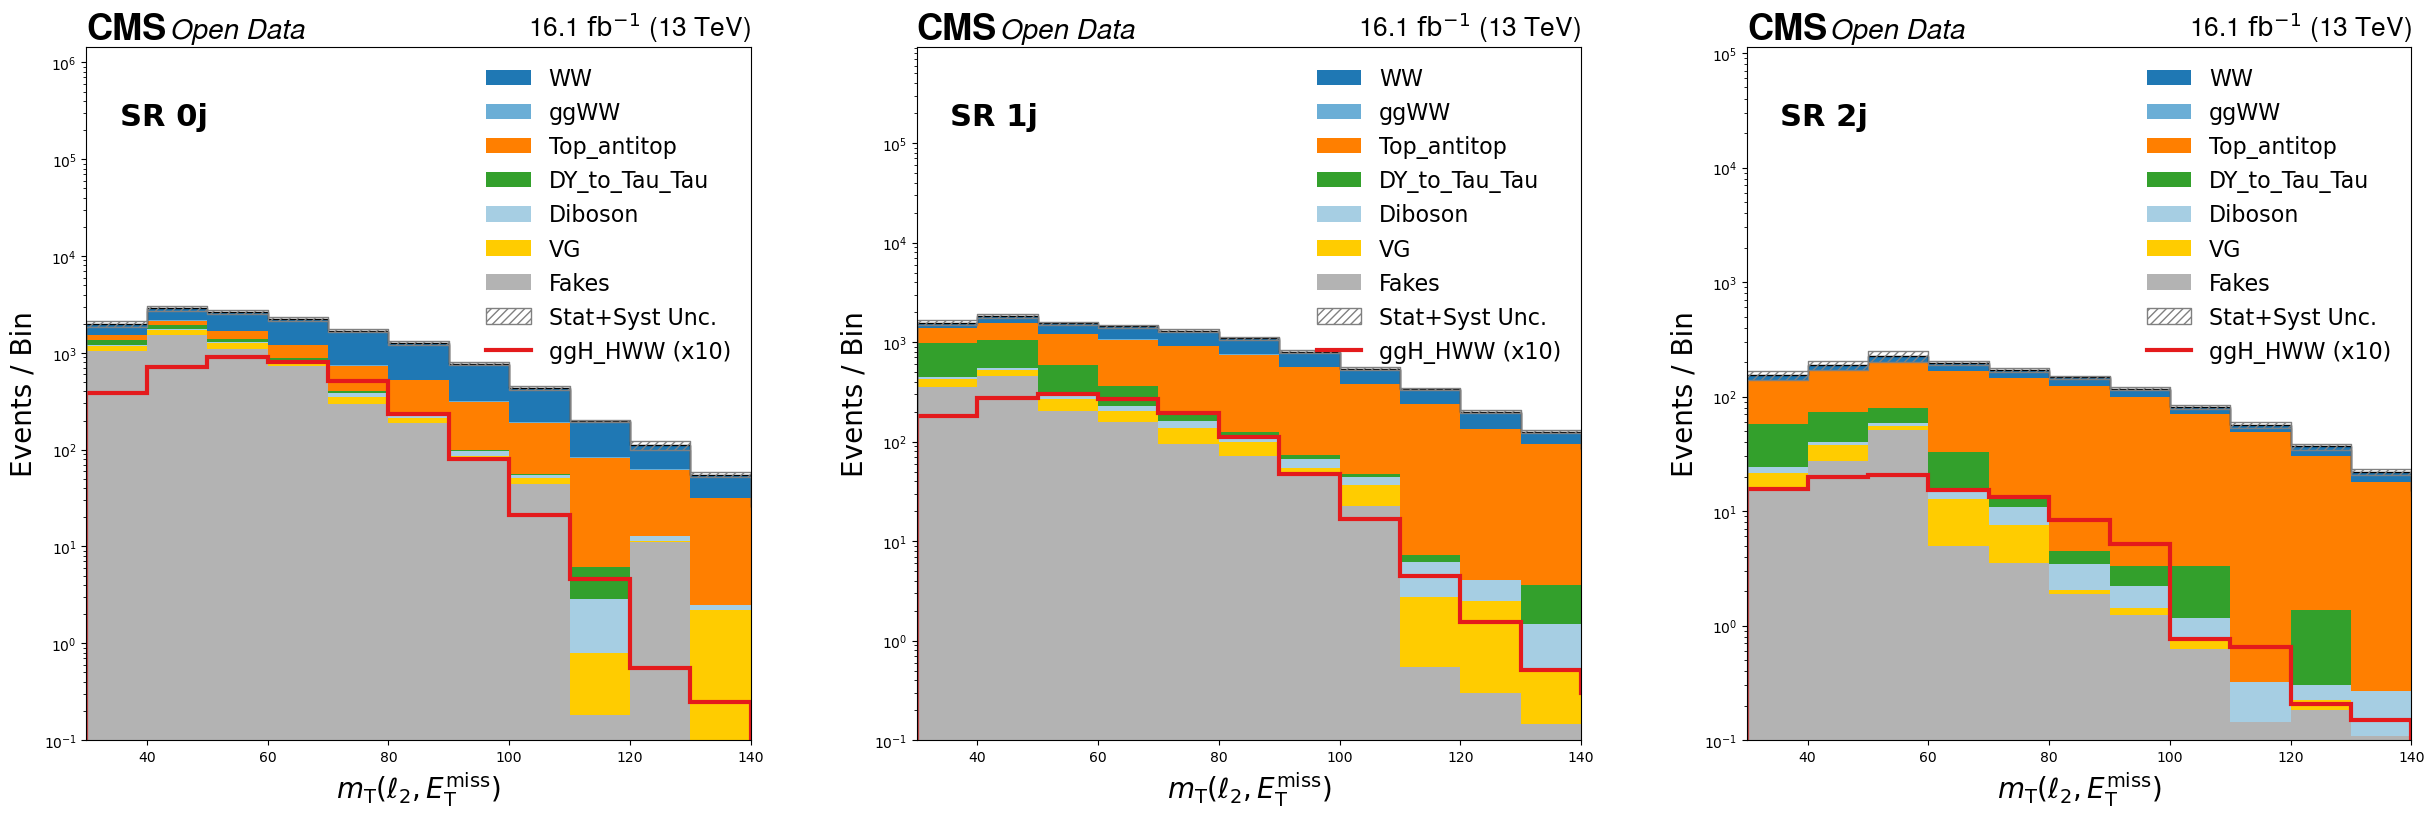

Plotting mt_l2_met in Control_Region_Top...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Control_Region_Top_mt_l2_met.png


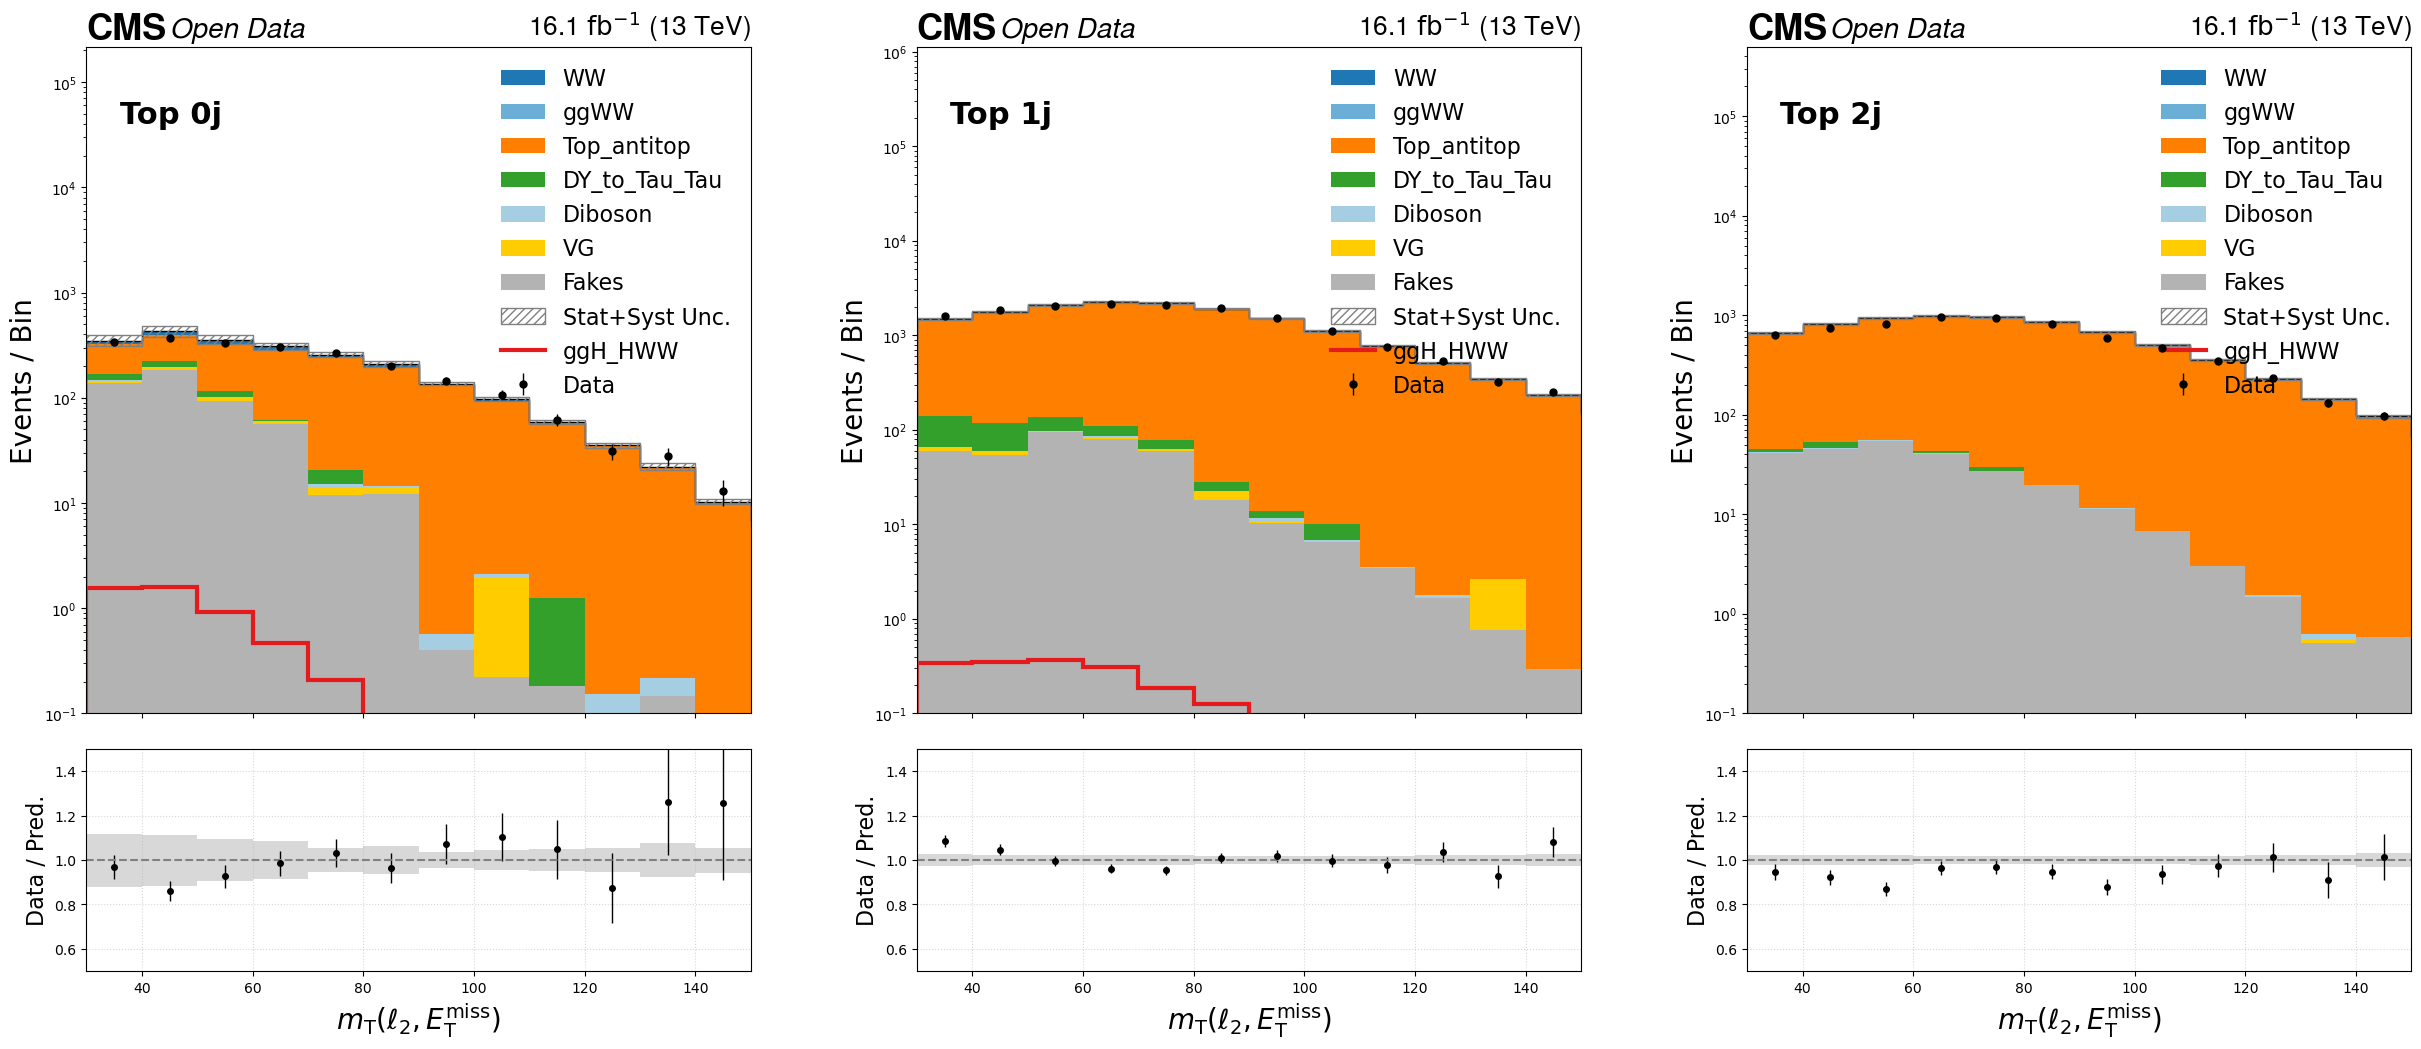

Plotting mt_l2_met in Control_Region_Tau...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Control_Region_Tau_mt_l2_met.png


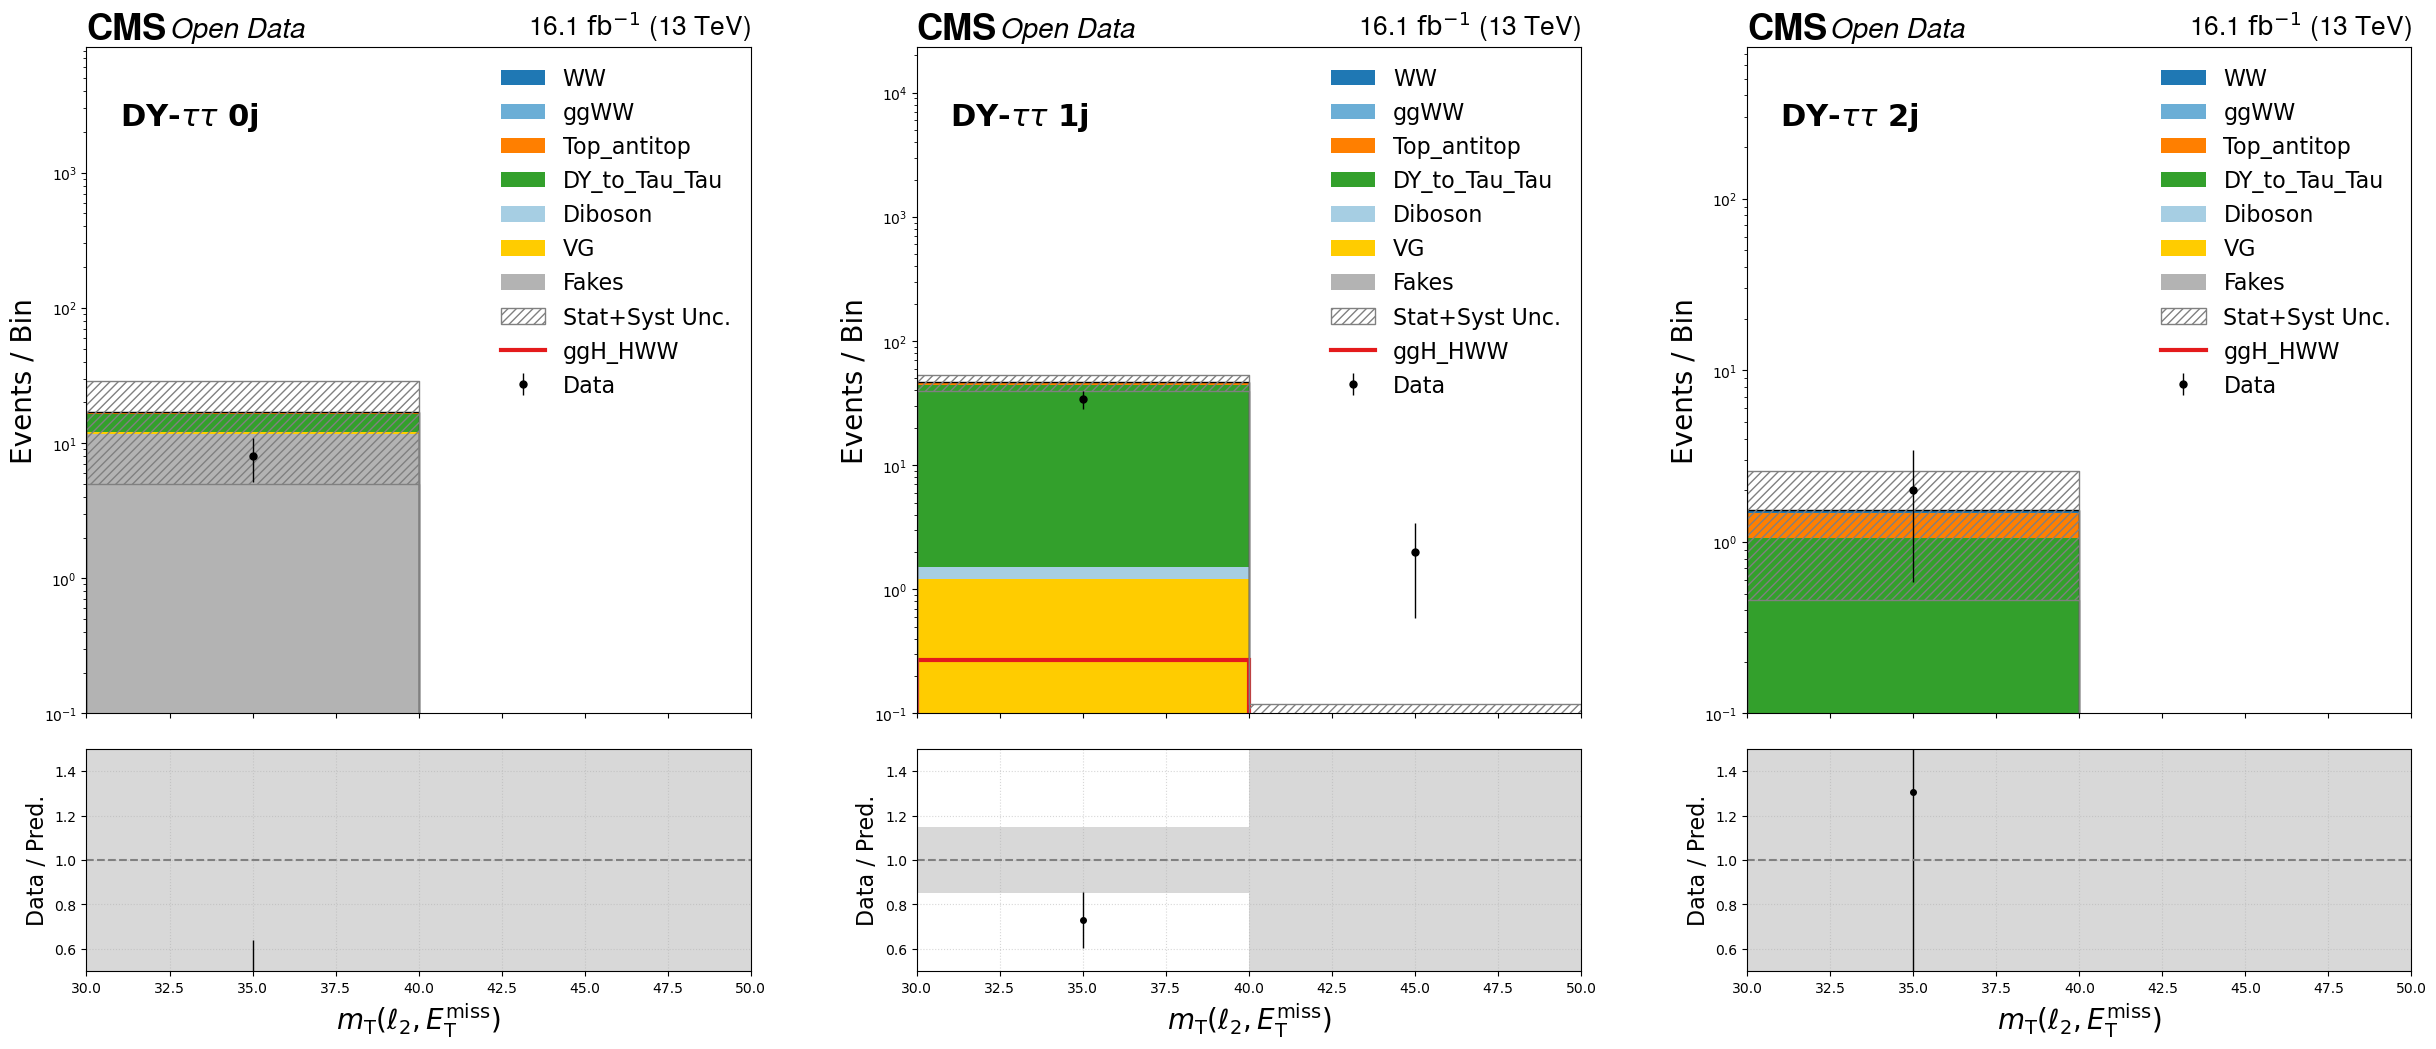

Plotting mjj in Signal_Region...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Signal_Region_mjj.png


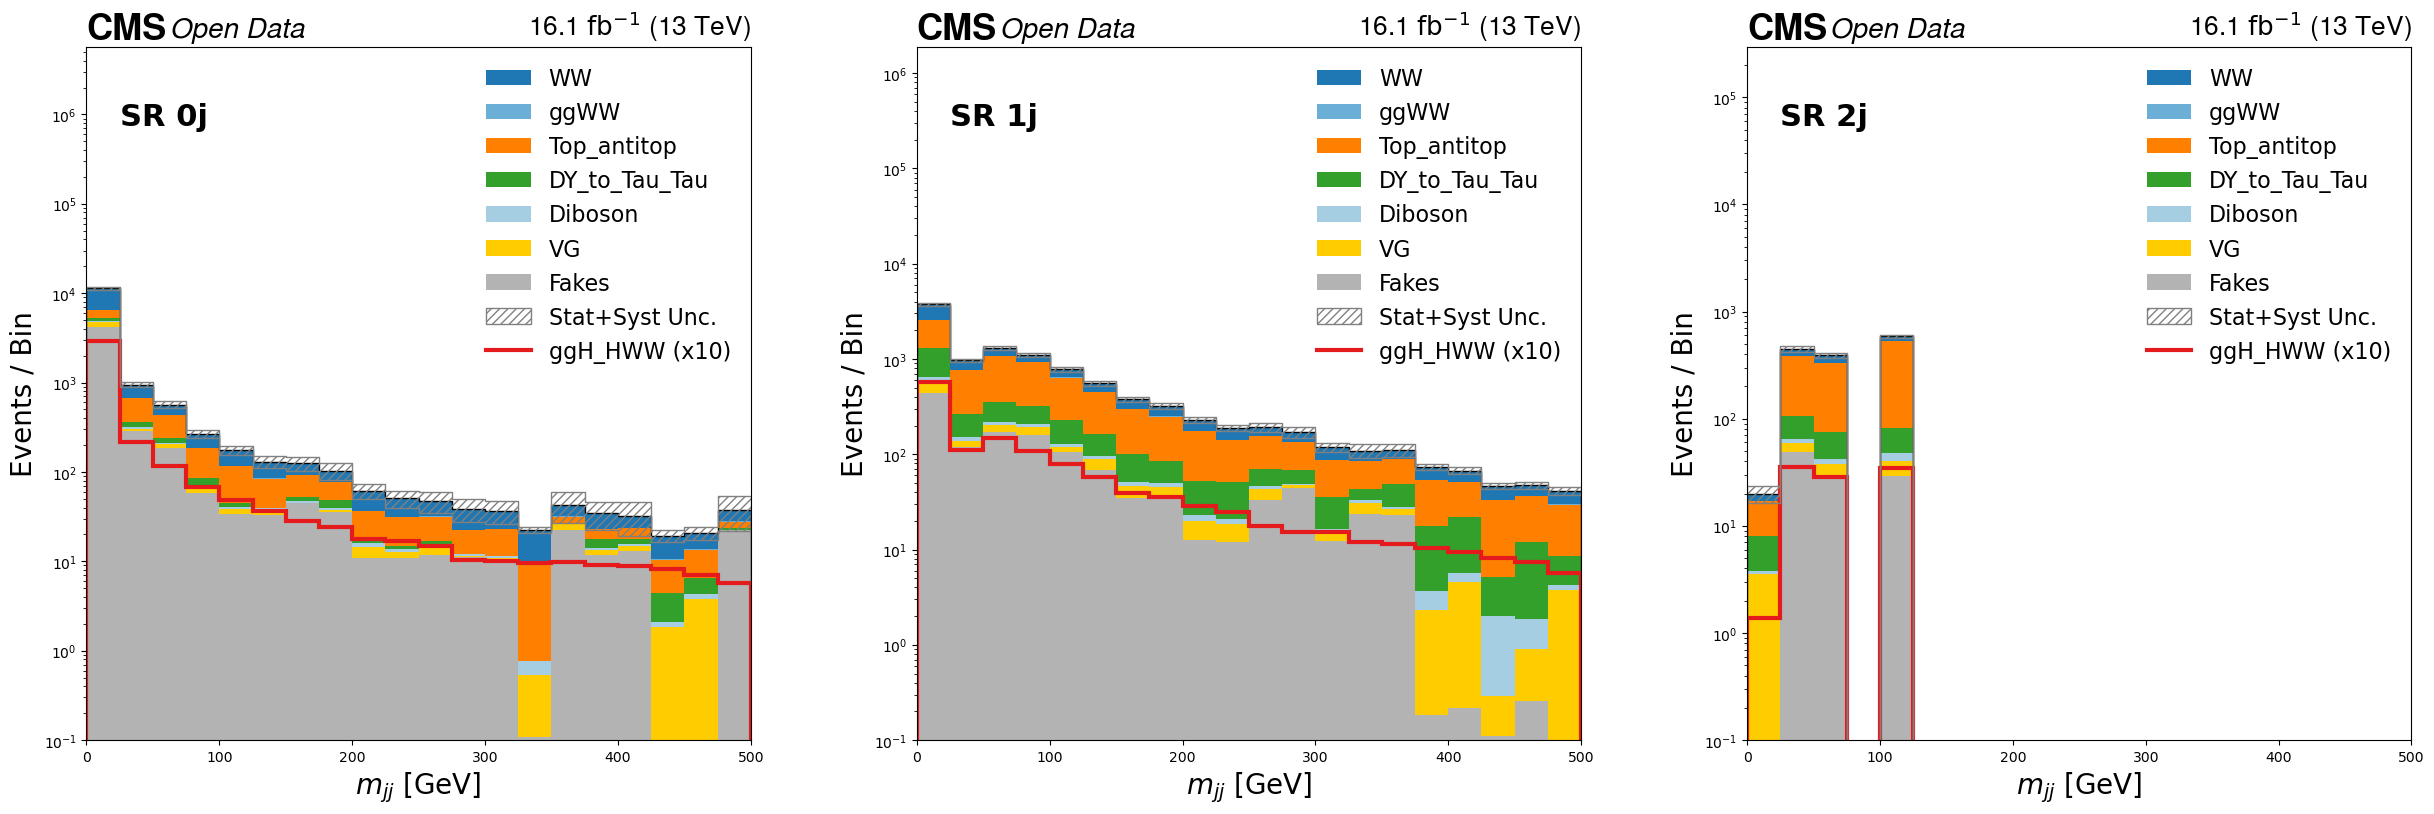

Plotting mjj in Control_Region_Top...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Control_Region_Top_mjj.png


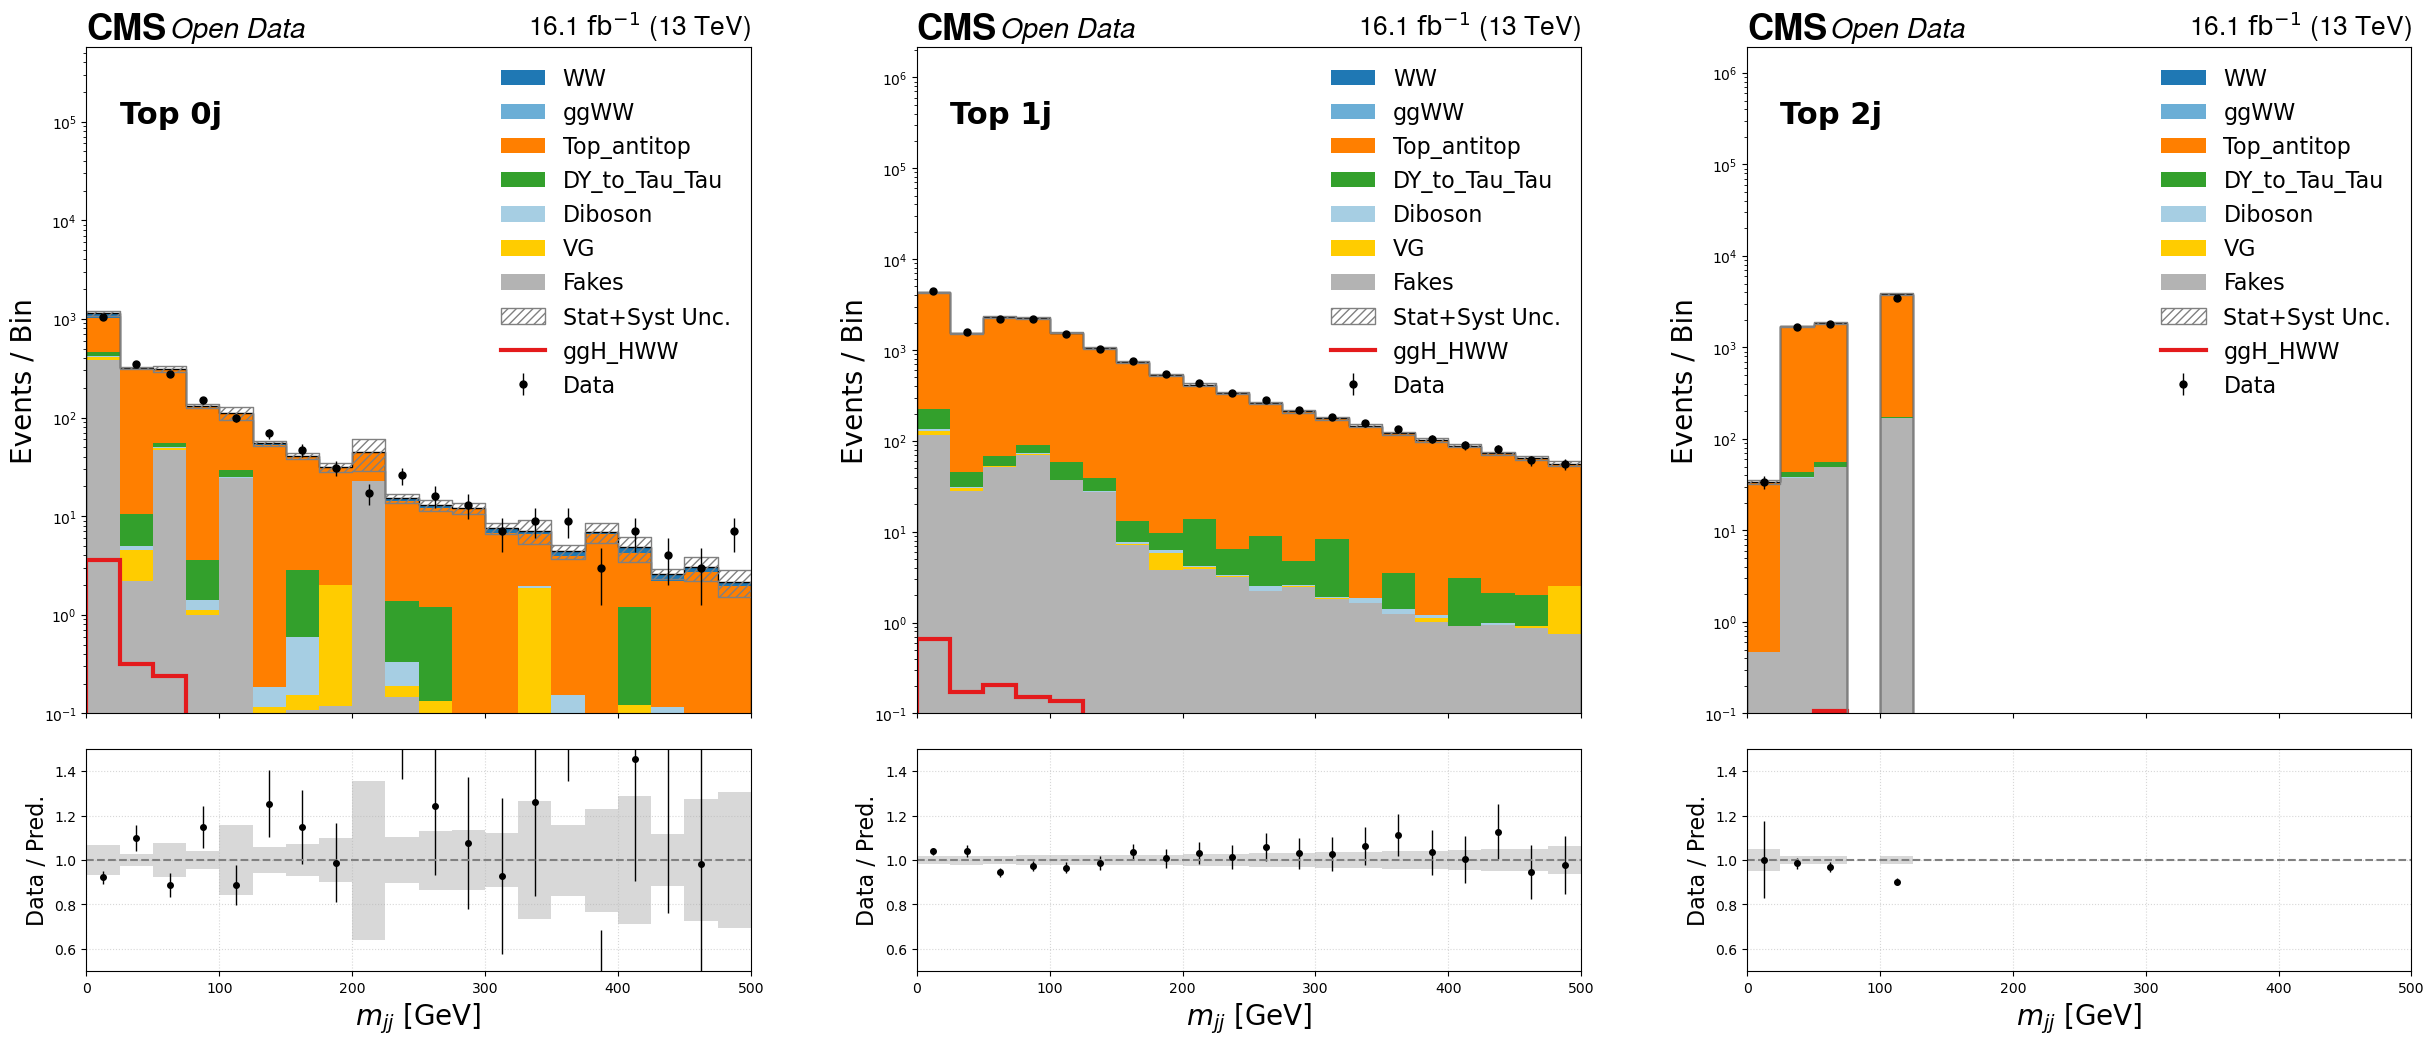

Plotting mjj in Control_Region_Tau...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Control_Region_Tau_mjj.png


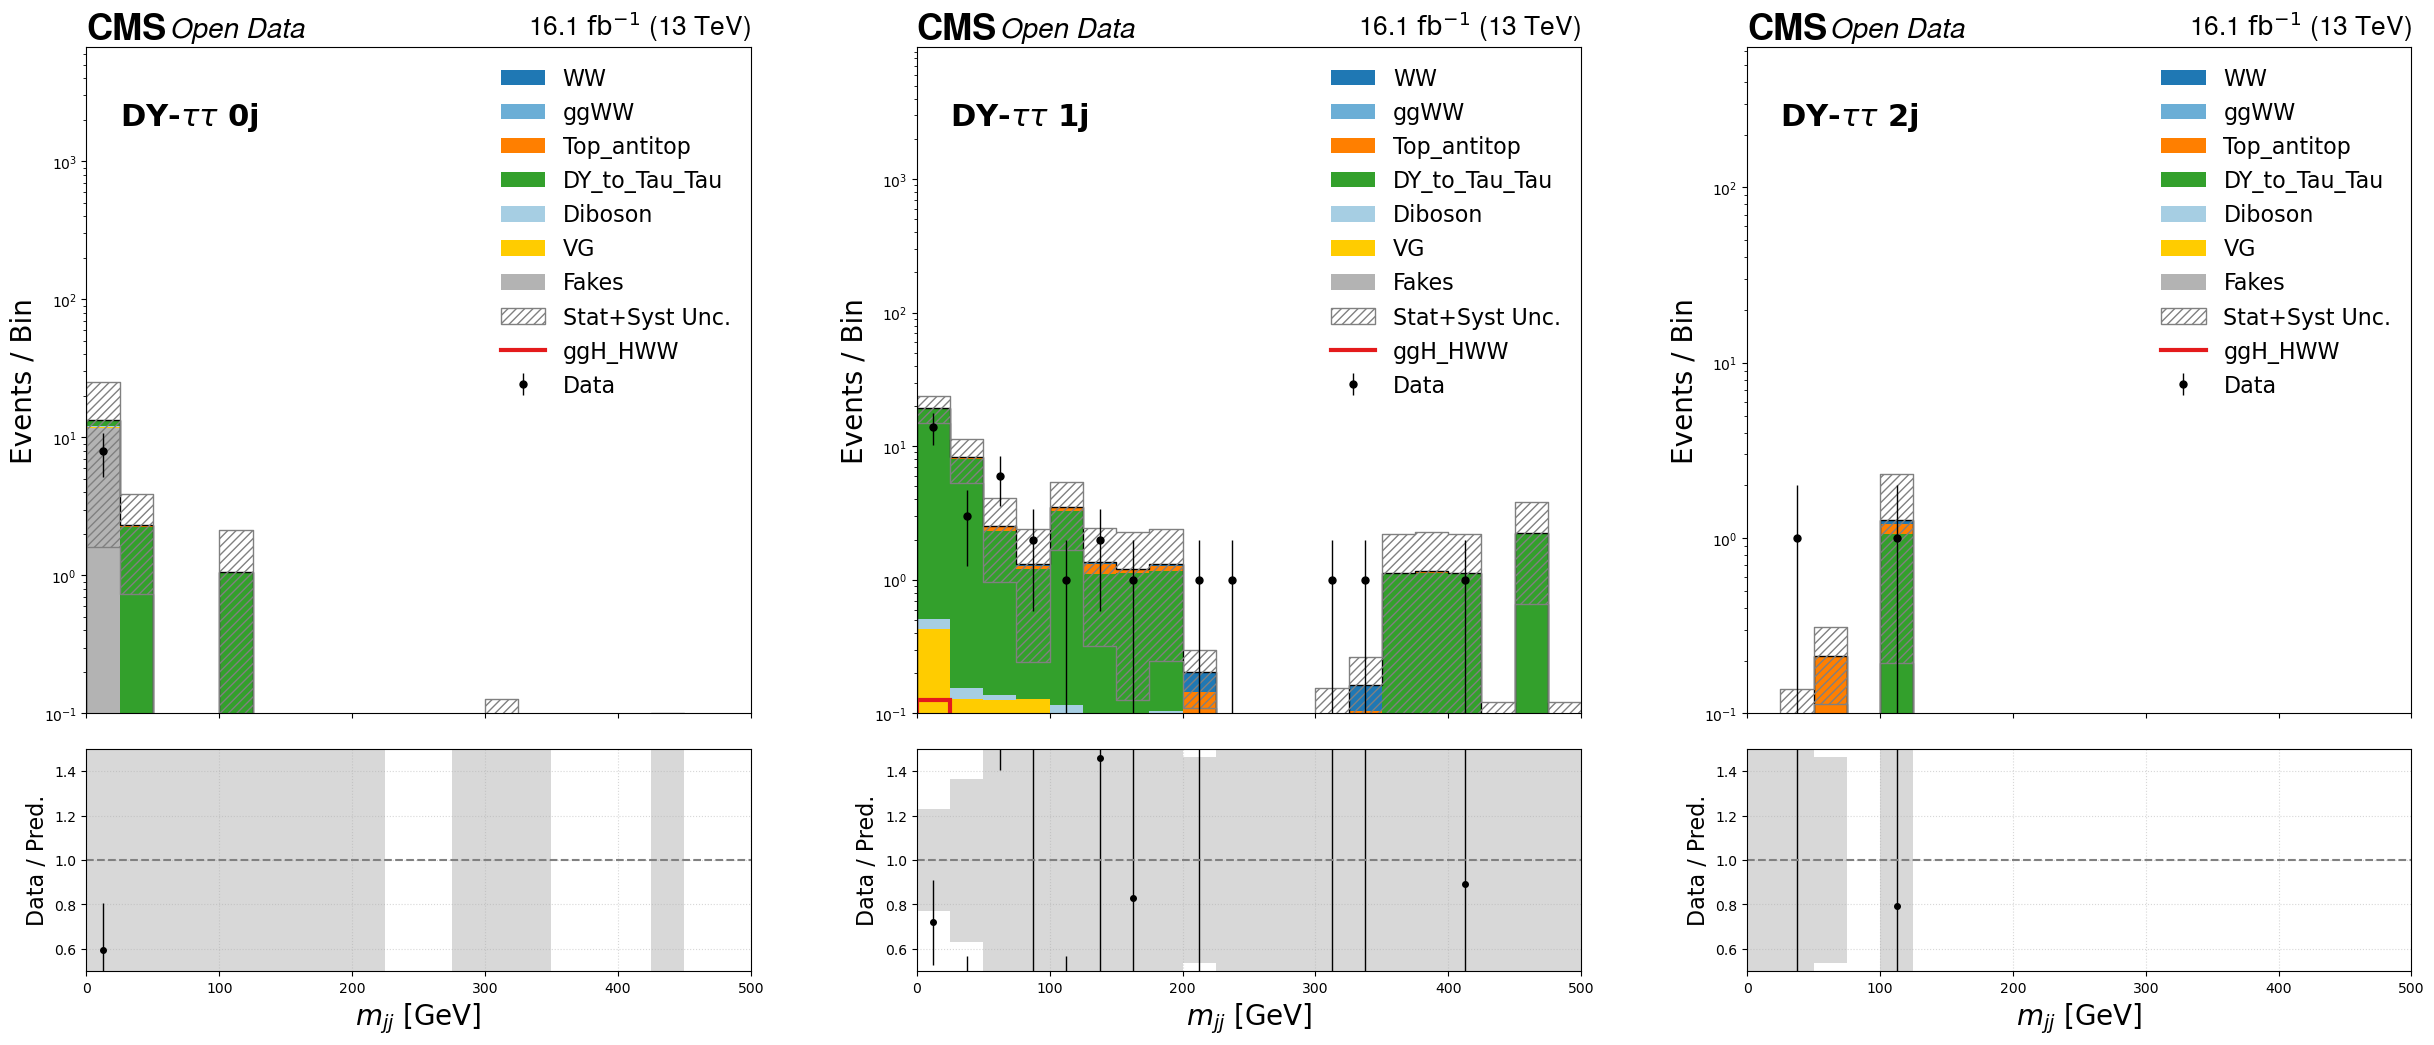

Plotting leading_pt in Signal_Region...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Signal_Region_leading_pt.png


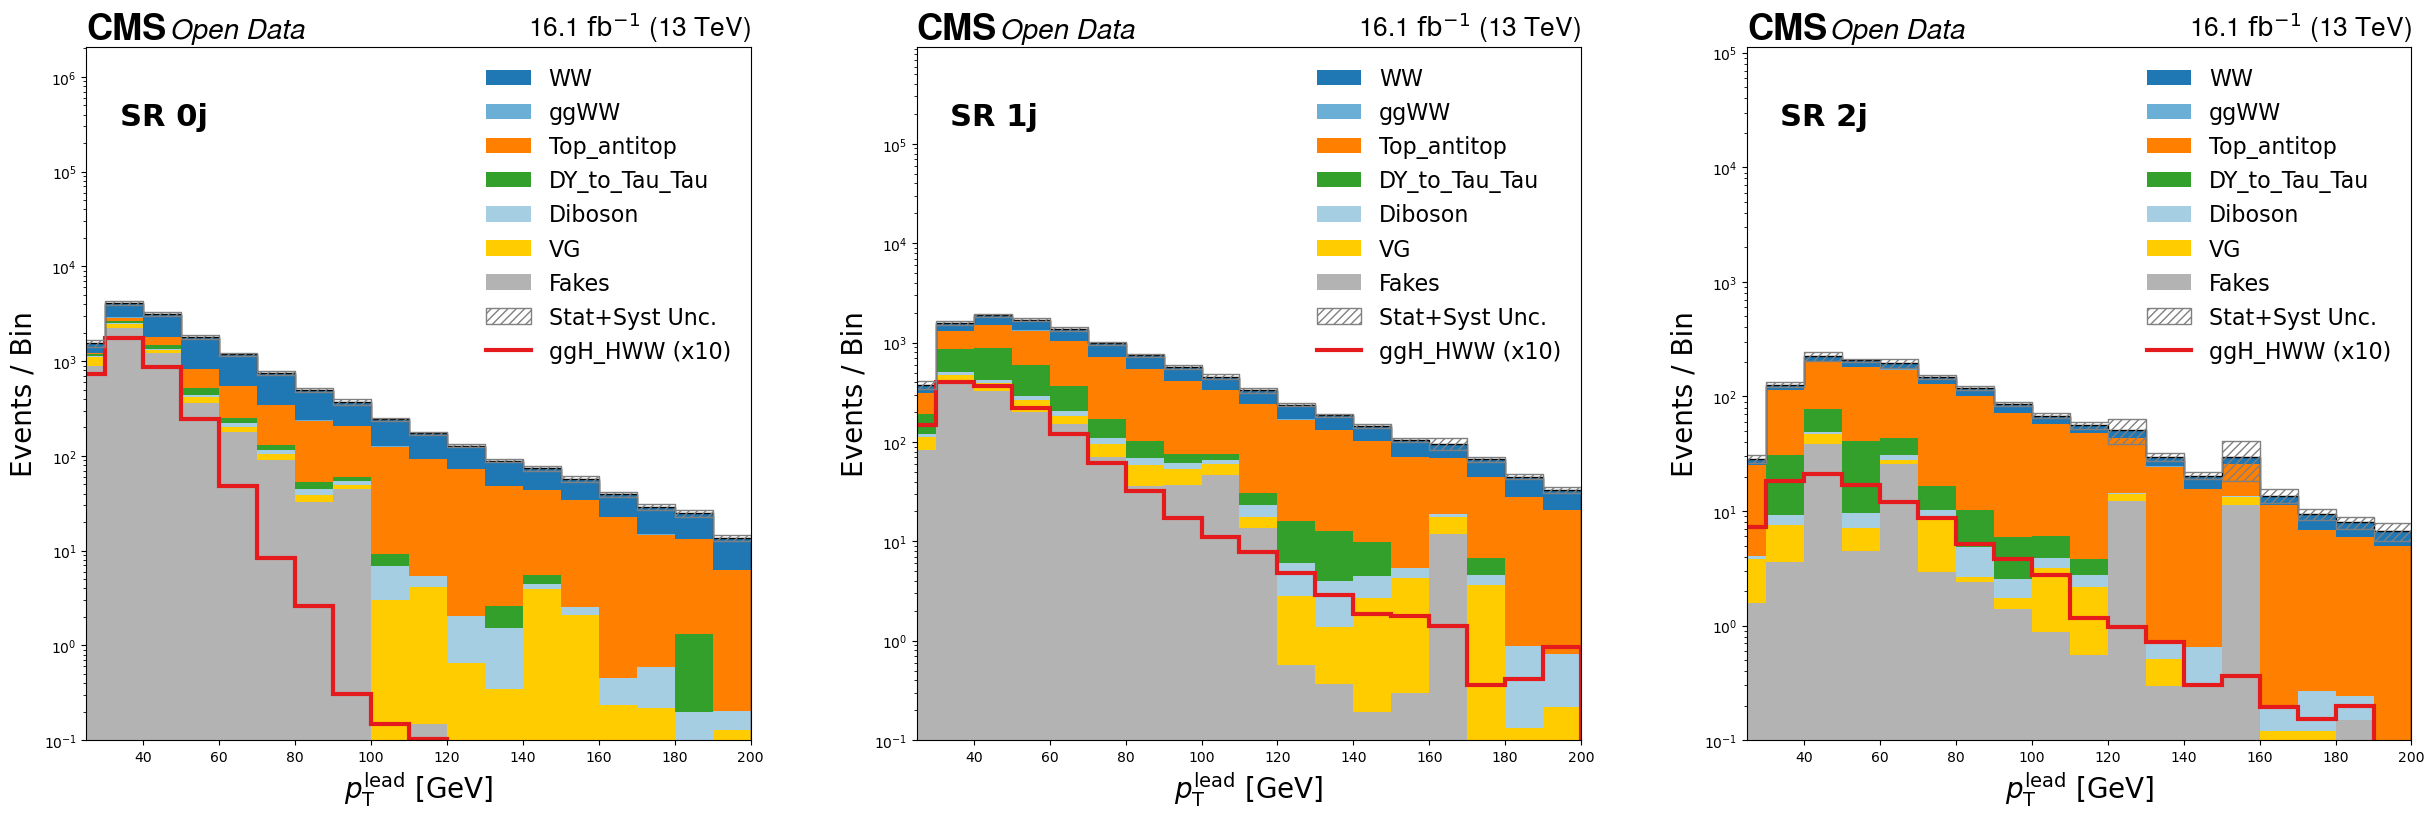

Plotting leading_pt in Control_Region_Top...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Control_Region_Top_leading_pt.png


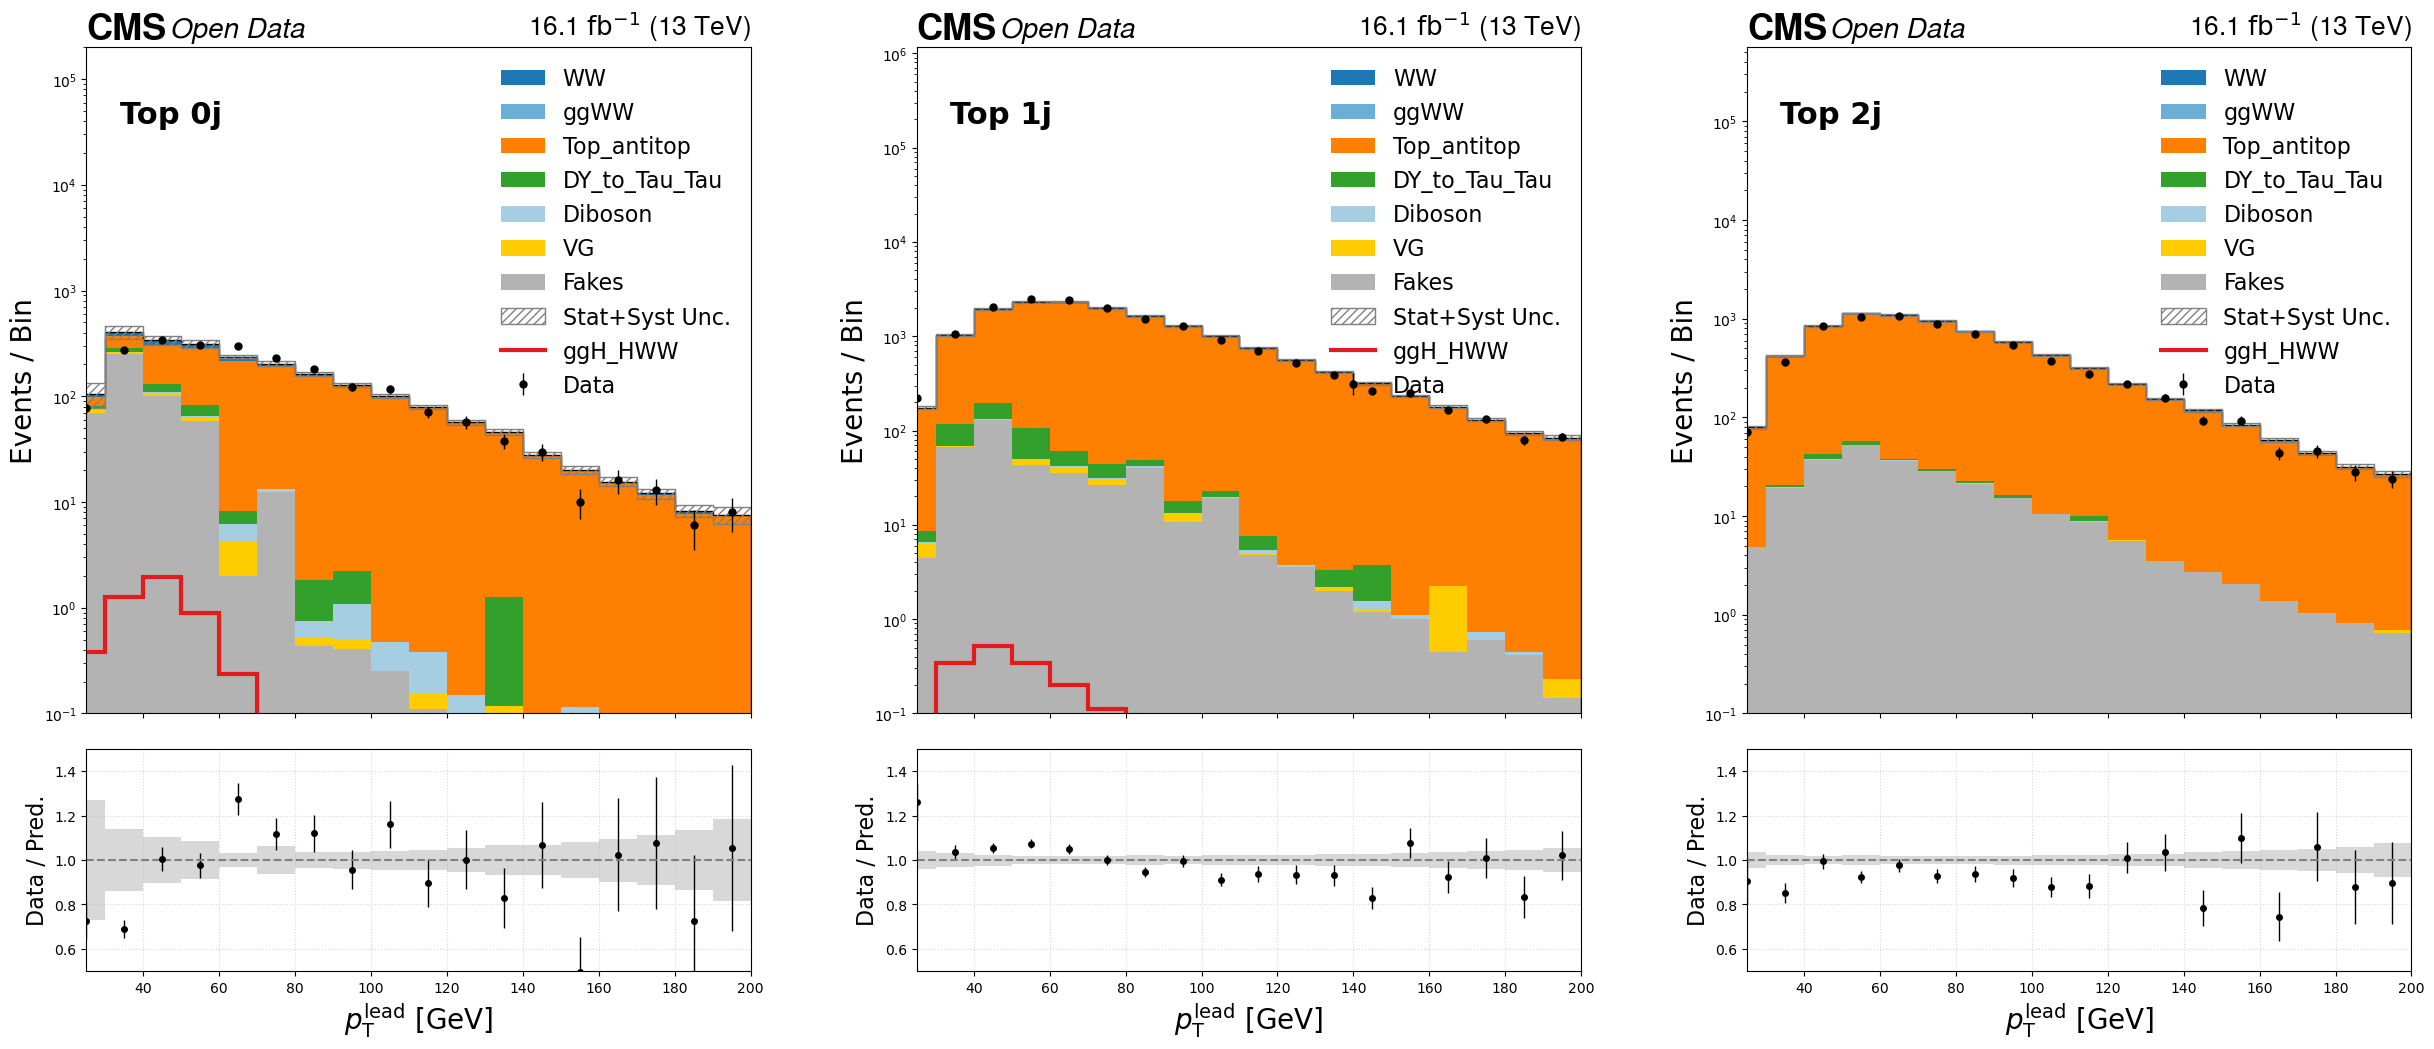

Plotting leading_pt in Control_Region_Tau...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Control_Region_Tau_leading_pt.png


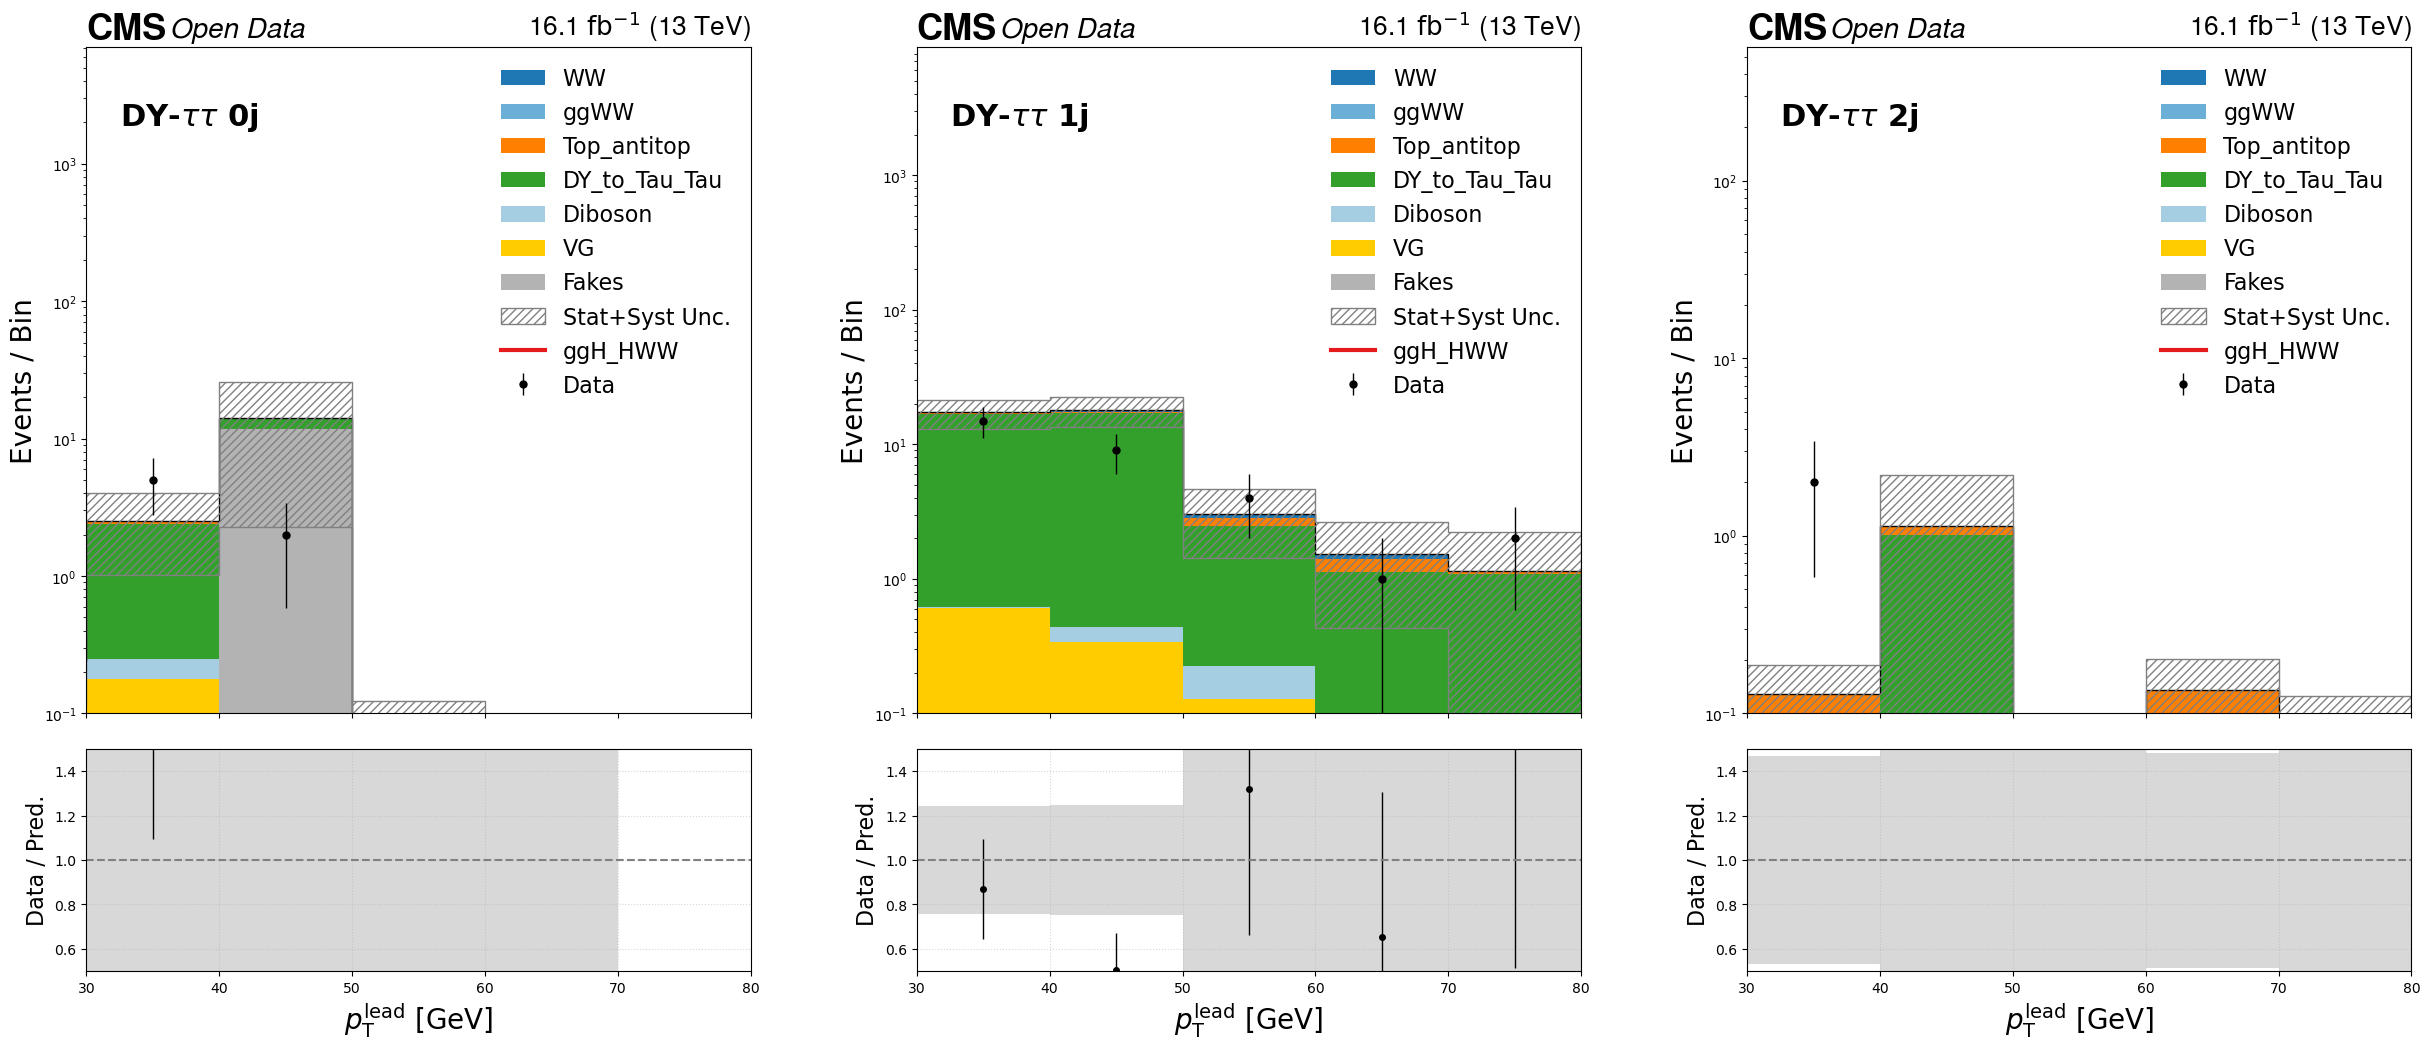

Plotting subleading_pt in Signal_Region...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Signal_Region_subleading_pt.png


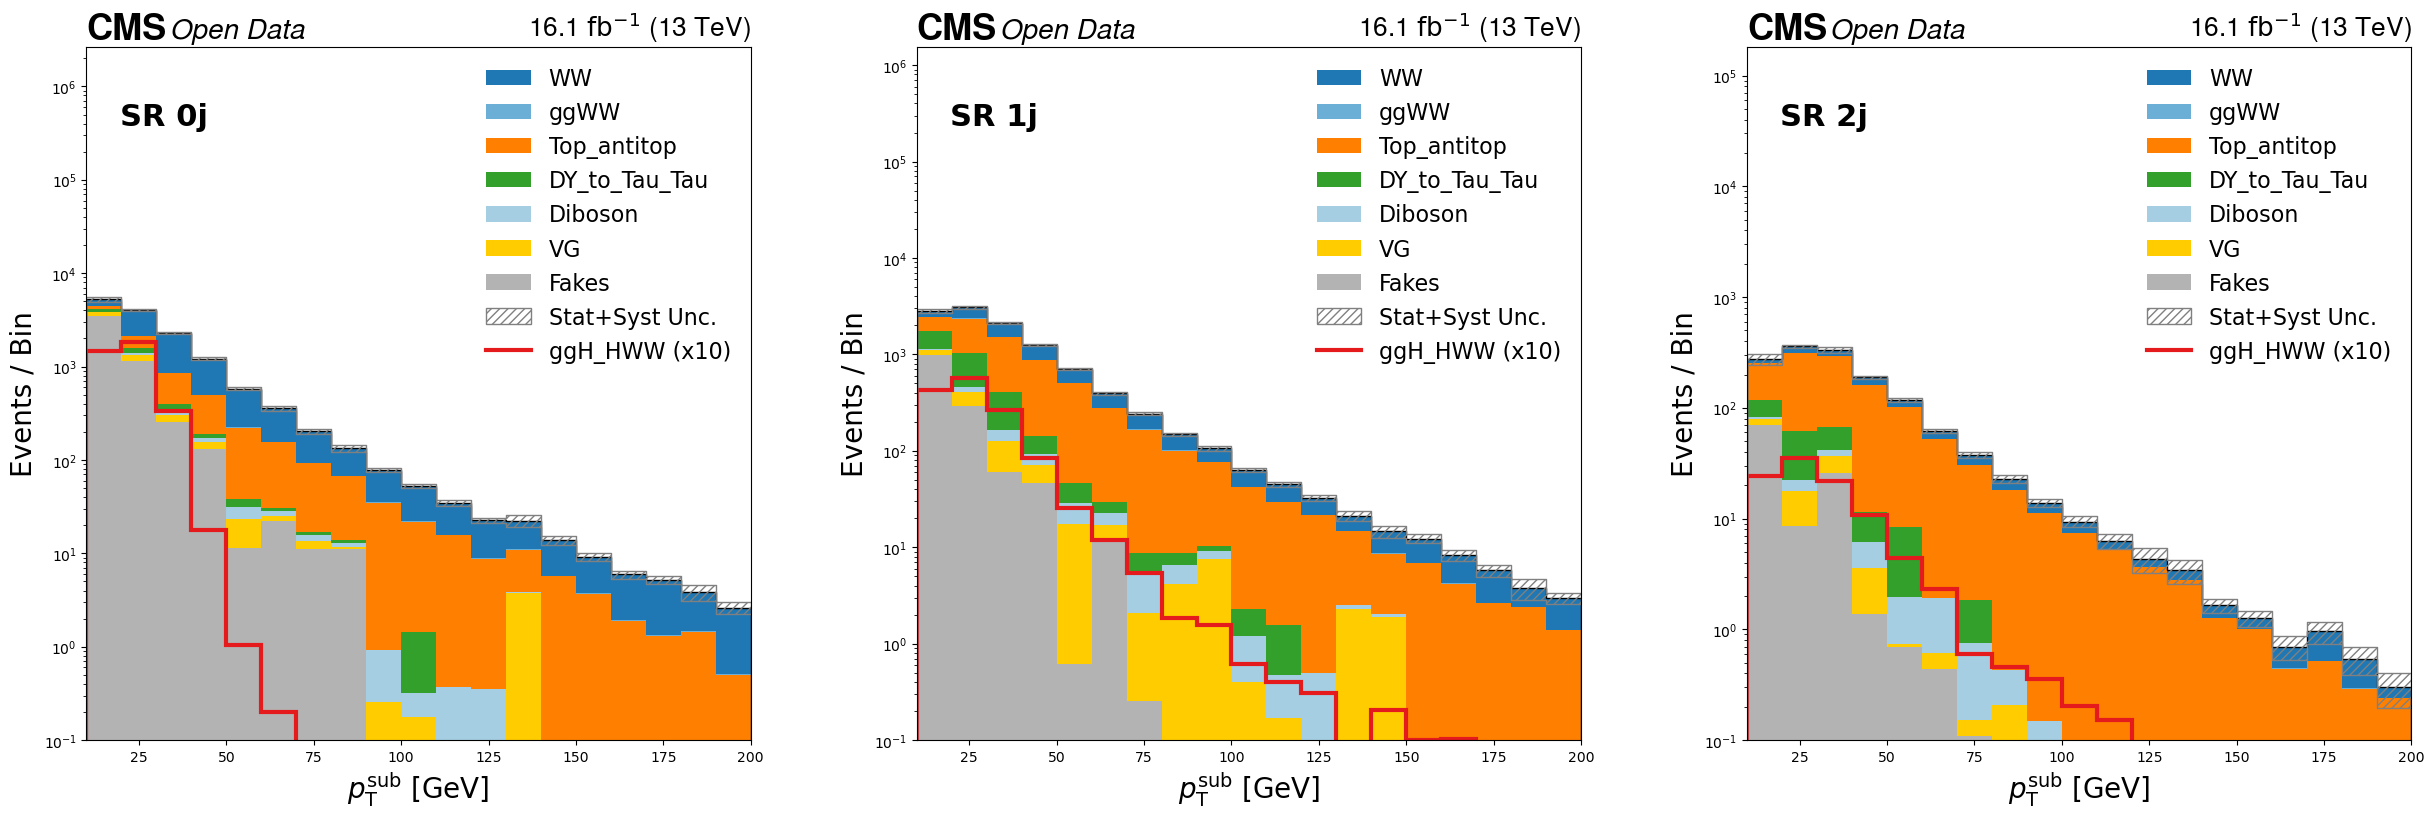

Plotting subleading_pt in Control_Region_Top...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Control_Region_Top_subleading_pt.png


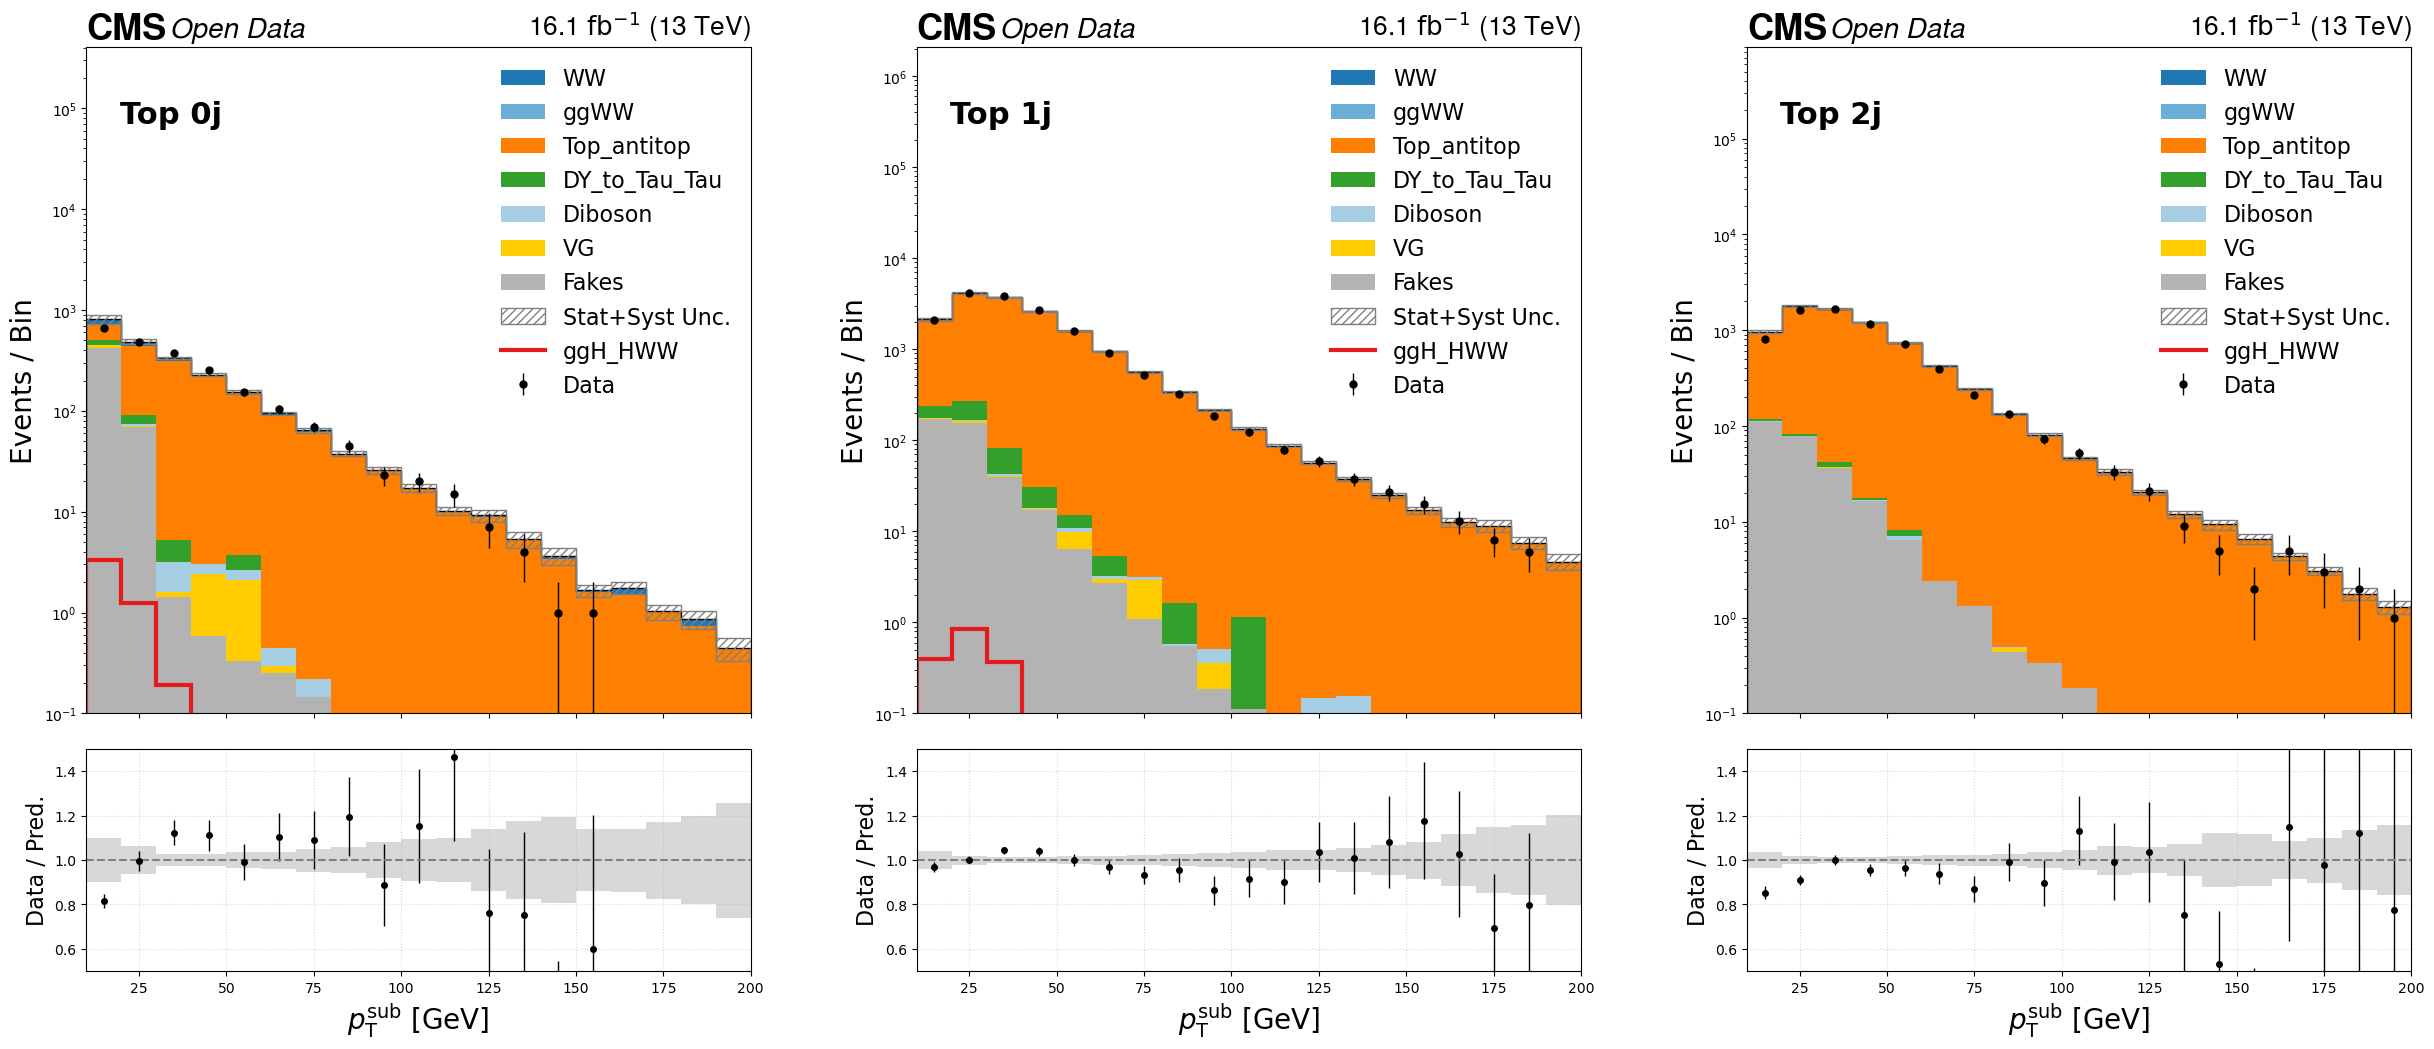

Plotting subleading_pt in Control_Region_Tau...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Control_Region_Tau_subleading_pt.png


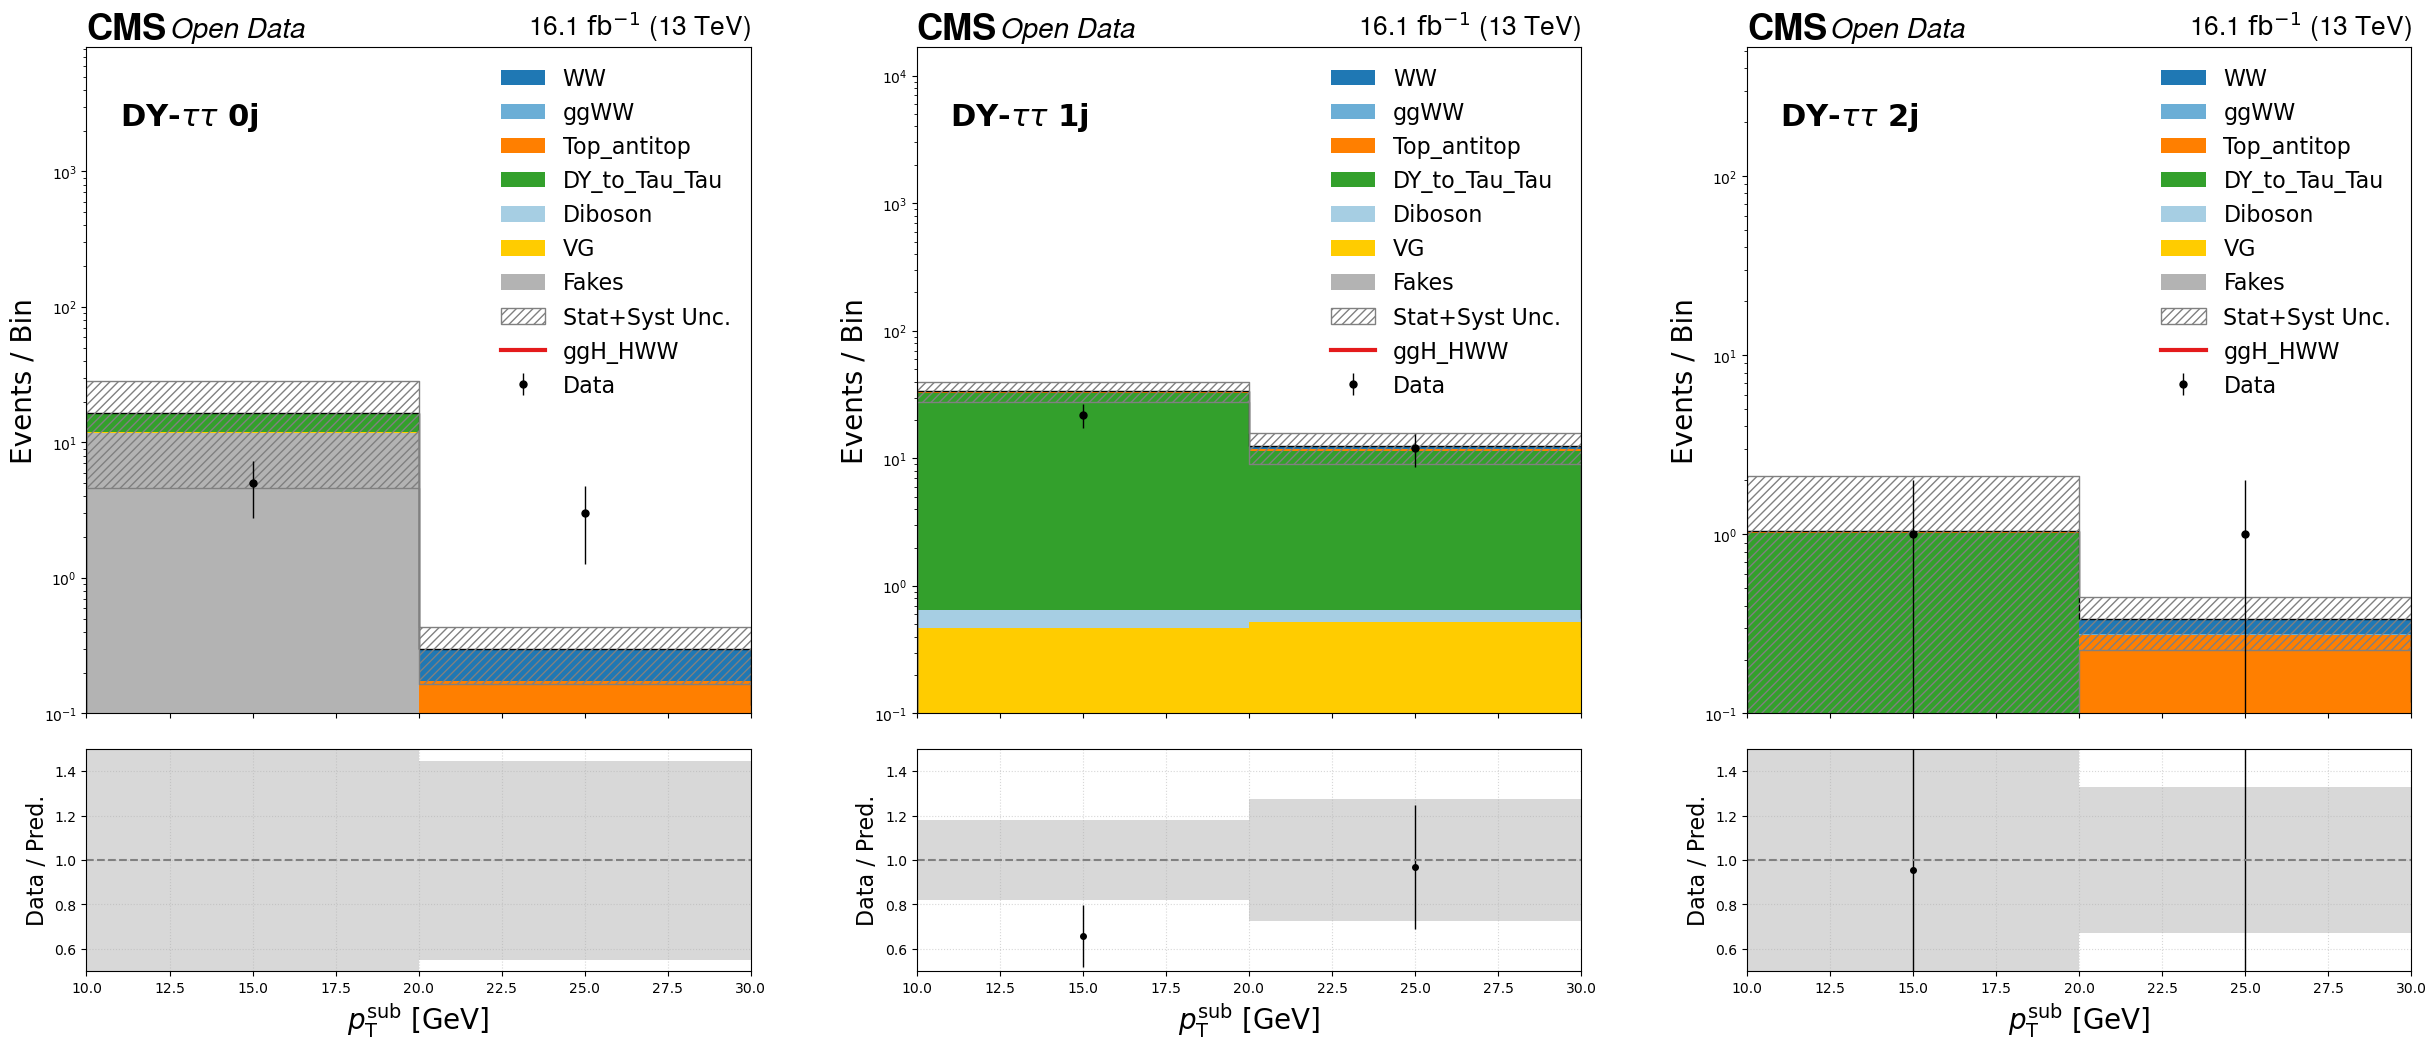


All plots saved to: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked


In [47]:
print("\n" + "="*70)
print("GENERATING STACKED PLOTS...")
print("="*70)

output_dir = PLOTS_DIR / "Stacked"
output_dir.mkdir(parents=True, exist_ok=True)

for variable in VAR_LABELS.keys():
    try:
        create_stacked_plots(
            variable=variable, 
            hist_data_all=hist_data_final, 
            output_dir=output_dir
        )
    except Exception as e:
        print(f"FAILED to plot {variable}: {e}")
        import traceback
        traceback.print_exc()

print(f"\nAll plots saved to: {output_dir}")

In [48]:
client.close()

In [49]:
del client